https://stats.stackexchange.com/questions/157012/area-under-precision-recall-curve-auc-of-pr-curve-and-average-precision-ap

https://stackoverflow.com/questions/38787612/how-to-extract-feature-importances-from-an-sklearn-pipeline
https://towardsdatascience.com/how-to-get-feature-importances-from-any-sklearn-pipeline-167a19f1214

https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

https://link.springer.com/article/10.1007/s13748-016-0094-0

https://stackoverflow.com/questions/62663370/using-pipeline-with-gridsearchcv
https://medium.com/@cmukesh8688/sklearn-pipeline-gridsearchcv-54f5552bbf4e

https://medium.com/analytics-vidhya/a-random-forest-classifier-with-imbalanced-data-7ef4d9ebedb8

In [55]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [56]:
import os
import datetime
import time
import pandas as pd
import warnings
from collections import Counter
import matplotlib.pyplot as plt
from myTools import *

from sklearn.model_selection import train_test_split

import sklearn
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc, precision_recall_curve, f1_score
from numpy import mean, std
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import KBinsDiscretizer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.inspection import permutation_importance

from numpy import percentile

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 999
pd.set_option("max_colwidth", 200)



from pickle import dump
from pickle import load

from sklearn.metrics import r2_score

from sklearn.preprocessing import PowerTransformer


# Import, transformation des données et création d'un jeu de validation

## Import et transformations

### Jeu de données par défaut

In [57]:
t1 = time.time()

print(datetime.datetime.now())

#########################################
# CHARGEMENT DES FICHIERS
#########################################

dfApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv',",")
dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
dfBureauBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv',",")
dfPreviousApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv',",")
dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")
dfCreditCardBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv',",")
dfInstallmentsPayments = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv',",")

t2 = time.time()
print("{} - {} - fichiers chargés".format(datetime.datetime.now(), t2-t1))
t1 = t2


#########################################
# MARQUAGE DES VALEURS MANQUANTES
#########################################

dfApplication = dfApplication.replace('XNA', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XNA', np.nan)
dfBureau = dfBureau.replace('XNA', np.nan)
dfApplication = dfApplication.replace('XAP', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XAP', np.nan)
dfBureau = dfBureau.replace('XAP', np.nan)
dfBureauBalance = dfBureauBalance.replace('X', np.nan)

dfApplication = dfApplication.replace('Unknown', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('Unknown', np.nan)
dfBureau = dfBureau.replace('Unknown', np.nan)
dfApplication = dfApplication.replace('Unknown', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('Unknown', np.nan)
dfBureau = dfBureau.replace('Unknown', np.nan)



t2 = time.time()
print("{} - {} - marquage des valeurs manquantes".format(datetime.datetime.now(), t2-t1))
t1 = t2




#########################################
# TRANSFORMATION DE VARIABLES
#########################################

# On remonte le dernier statut des tables de niveau 3 dans PreviousApplication

dfPreviousApplicationStatus = pd.concat([dfPosCashBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']],dfCreditCardBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']]])
tmp = dfPreviousApplicationStatus.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'MONTHS_BALANCE':'max'}).reset_index(drop=False)
dfPreviousApplicationStatus = dfPreviousApplicationStatus.merge(tmp, left_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], right_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])
del dfPreviousApplicationStatus['MONTHS_BALANCE']
dfPreviousApplicationStatus = dfPreviousApplicationStatus.rename(columns={'NAME_CONTRACT_STATUS': 'LAST_NAME_CONTRACT_STATUS'})
dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationStatus, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'], how='left')

dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.LAST_NAME_CONTRACT_STATUS == 'Completed'].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 0
dfPreviousApplication.at[dfPreviousApplication[(dfPreviousApplication.LAST_NAME_CONTRACT_STATUS != 'Completed') & (~dfPreviousApplication.LAST_NAME_CONTRACT_STATUS.isnull())].index, "LAST_NAME_CONTRACT_STATUS_TMP"] = 1
dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
del dfPreviousApplication['LAST_NAME_CONTRACT_STATUS_TMP']
dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'] = dfPreviousApplication['LAST_NAME_CONTRACT_STATUS'].astype(float)

del dfCreditCardBalance['NAME_CONTRACT_STATUS']
del dfPosCashBalance['NAME_CONTRACT_STATUS']


t2 = time.time()
print("{} - {} - remontée de name_contract_status".format(datetime.datetime.now(), t2-t1))
t1 = t2




#########################################
# RENOMMAGE DE COLONNES
#########################################

def newColNames(df, suffix):
    cols = []
    keys = ['SK_ID_CURR','SK_ID_PREV','SK_ID_BUREAU']
    for col in df:
        if col not in keys:
            col = suffix + '_' + col
        cols.append(col)
    return cols
newColNames(dfPreviousApplication, 'PREV')


dfPreviousApplication.columns = newColNames(dfPreviousApplication, 'PREV')
dfPosCashBalance.columns = newColNames(dfPosCashBalance, 'POSCASH')
dfInstallmentsPayments.columns = newColNames(dfInstallmentsPayments, 'INSTALPAYMT')
dfCreditCardBalance.columns = newColNames(dfCreditCardBalance, 'CREDCARD')
dfBureau.columns = newColNames(dfBureau, 'BURO')
dfBureauBalance.columns = newColNames(dfBureauBalance, 'BUROBAL')



t2 = time.time()
print("{} - {} - suppression de variables et renommage de colonnes".format(datetime.datetime.now(), t2-t1))
t1 = t2



#########################################
# MISE A PLAT DES DONNEES
#########################################


dfBureauBalance = TransformUnique(dfBureauBalance, ['SK_ID_BUREAU'])
dfPosCashBalance = TransformUnique(dfPosCashBalance, ['SK_ID_CURR','SK_ID_PREV'])
dfCreditCardBalance = TransformUnique(dfCreditCardBalance, ['SK_ID_CURR','SK_ID_PREV'])
dfInstallmentsPayments = TransformUnique(dfInstallmentsPayments, ['SK_ID_CURR','SK_ID_PREV'])

dfPreviousApplication = dfPreviousApplication.merge(dfCreditCardBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
dfPreviousApplication = dfPreviousApplication.merge(dfPosCashBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
dfPreviousApplication = dfPreviousApplication.merge(dfInstallmentsPayments, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')

dfBureau = dfBureau.merge(dfBureauBalance, left_on='SK_ID_BUREAU', right_on = 'SK_ID_BUREAU', how='left')

dfPreviousApplication = TransformUnique(dfPreviousApplication, ['SK_ID_CURR'])
dfBureau = TransformUnique(dfBureau, ['SK_ID_CURR'])


dfApplication = dfApplication.merge(dfPreviousApplication, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfApplication = dfApplication.merge(dfBureau, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')


t2 = time.time()
print("{} - {} - mise à plat".format(datetime.datetime.now(), t2-t1))
t1 = t2



#########################################
# Suppression des colonnes ID
#########################################


del dfApplication['SK_ID_PREV']
del dfApplication['SK_ID_BUREAU']
del dfApplication['INSTALPAYMT_NUM_INSTALMENT_VERSION']
del dfApplication['INSTALPAYMT_NUM_INSTALMENT_NUMBER']


#########################################
# SUPPRESSION DES COLONNES SANS INFORMATION
#########################################

counts = dfApplication.nunique()
counts = counts[counts==1]
to_del = list(counts.index)
dfApplication.drop(to_del, axis=1, inplace=True)


t2 = time.time()
print("{} - {} - suppression de colonnes".format(datetime.datetime.now(), t2-t1))
t1 = t2

#########################################
# GESTION DES QUELQUES VALEURS NUMERIQUES MANQUANTES
#########################################

dfApplication['OWN_CAR_AGE'] = dfApplication['OWN_CAR_AGE'].replace(np.nan, 100)
dfApplication['PREV_LAST_NAME_CONTRACT_STATUS'] = dfApplication['PREV_LAST_NAME_CONTRACT_STATUS'].replace(np.nan, -1)

for col in dfApplication.columns:
    if (col[0:4] in ['PREV','POSC','CRED','INST','BURO']) & (dfApplication[col].dtypes in ['int64','float64']):
        dfApplication[col] = dfApplication[col].replace(np.nan, 0)


dfApplicationDefault = dfApplication

t2 = time.time()
print("{} - {} - missing default".format(datetime.datetime.now(), t2-t1))
t1 = t2

if False:
    del dfApplicationDefault['EXT_SOURCE_1']
    del dfApplicationDefault['EXT_SOURCE_2']
    del dfApplicationDefault['EXT_SOURCE_3']




2021-06-27 17:40:38.928975
2021-06-27 17:41:03.089164 - 24.160172700881958 - fichiers chargés
2021-06-27 17:42:09.954997 - 66.8658344745636 - marquage des valeurs manquantes
2021-06-27 17:42:19.899008 - 9.944013595581055 - remontée de name_contract_status
2021-06-27 17:42:19.900074 - 0.0010766983032226562 - suppression de variables et renommage de colonnes
2021-06-27 17:42:57.522438 - 37.62235188484192 - mise à plat
2021-06-27 17:43:04.616351 - 7.093914985656738 - suppression de colonnes
2021-06-27 17:43:04.754655 - 0.13829278945922852 - missing default


### Jeu de données travaillé

In [58]:

t1 = time.time()

print(datetime.datetime.now())

#########################################
# CHARGEMENT DES FICHIERS
#########################################

dfApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/application_train.csv',",")
dfBureau = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau.csv',",")
dfBureauBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/bureau_balance.csv',",")
dfPreviousApplication = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/previous_application.csv',",")
dfPosCashBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/POS_CASH_balance.csv',",")
dfCreditCardBalance = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/credit_card_balance.csv',",")
dfInstallmentsPayments = pd.read_csv(os.getcwd() + '/Projet+Mise+en+prod+-+home-credit-default-risk/installments_payments.csv',",")

t2 = time.time()
print("{} - {} - fichiers chargés".format(datetime.datetime.now(), t2-t1))
t1 = t2


#########################################
# MARQUAGE DES VALEURS MANQUANTES
#########################################

dfApplication = dfApplication.replace('XNA', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XNA', np.nan)
dfBureau = dfBureau.replace('XNA', np.nan)
dfApplication = dfApplication.replace('XAP', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('XAP', np.nan)
dfBureau = dfBureau.replace('XAP', np.nan)
dfBureauBalance = dfBureauBalance.replace('X', np.nan)

dfApplication = dfApplication.replace('Unknown', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('Unknown', np.nan)
dfBureau = dfBureau.replace('Unknown', np.nan)
dfApplication = dfApplication.replace('Unknown', np.nan)
dfPreviousApplication = dfPreviousApplication.replace('Unknown', np.nan)
dfBureau = dfBureau.replace('Unknown', np.nan)


t2 = time.time()
print("{} - {} - marquage des valeurs manquantes".format(datetime.datetime.now(), t2-t1))
t1 = t2


#########################################
# SUPPRESSION DE LIGNES
#########################################

dfPreviousApplication = dfPreviousApplication[(dfPreviousApplication.FLAG_LAST_APPL_PER_CONTRACT == 'Y') & (dfPreviousApplication.NFLAG_LAST_APPL_IN_DAY == 1)]
dfPreviousApplication = dfPreviousApplication[dfPreviousApplication.NAME_CONTRACT_STATUS.isin(['Approved','Refused'])]
dfInstallmentsPayments = dfInstallmentsPayments[dfInstallmentsPayments.AMT_INSTALMENT != 0]


t2 = time.time()
print("{} - {} - suppression de lignes".format(datetime.datetime.now(), t2-t1))
t1 = t2



#########################################
# SUPPRESSION DE VARIABLES
#########################################


if False:

    # APPLICATION

    del dfApplication['OBS_60_CNT_SOCIAL_CIRCLE'] # corr 1 avec OBS_60_CNT_SOCIAL_CIRCLE
    del dfApplication['DEF_60_CNT_SOCIAL_CIRCLE'] # corr 0.86 avec DEF_30_CNT_SOCIAL_CIRCLE
    del dfApplication['OWN_CAR_AGE'] # corr 0.97 avec FLAG_OWN_CAR
    del dfApplication['CNT_FAM_MEMBERS'] # corr 0.97 avec CNT_CHILDREN
    del dfApplication['AMT_GOODS_PRICE'] # corr 0.99 avec AMT_CREDIT
    del dfApplication['REGION_RATING_CLIENT_W_CITY'] # corr 0.96 avec REGION_RATING_CLIENT


    # Trop de valeurs identiques
    del dfApplication['FLAG_MOBIL']
    del dfApplication['FLAG_CONT_MOBILE']
    del dfApplication['REG_REGION_NOT_LIVE_REGION']
    for col in dfApplication.columns:
        if (col[0:13] == 'FLAG_DOCUMENT') & (col[-2:] not in ['_3','_6','_8']):
            del dfApplication[col]


    # PREVIOUS APPLICATION

    # Trop de valeurs manquantes
    del dfPreviousApplication['RATE_INTEREST_PRIMARY']
    del dfPreviousApplication['RATE_INTEREST_PRIVILEGED']
    del dfPreviousApplication['NAME_CASH_LOAN_PURPOSE']

    # Trop de valeurs identiques
    del dfPreviousApplication['NAME_PAYMENT_TYPE']

    # corr > 0.9 avec AMT_CREDIT
    del dfPreviousApplication['AMT_GOODS_PRICE']

    # corr 0.9 avec NAME_CONTRACT_TYPE
    del dfPreviousApplication['NAME_PORTFOLIO']

    # corr > 0.95 avec DAYS_DECISION
    del dfPreviousApplication['DAYS_FIRST_DRAWING']
    del dfPreviousApplication['DAYS_FIRST_DUE']
    del dfPreviousApplication['DAYS_LAST_DUE_1ST_VERSION']
    del dfPreviousApplication['DAYS_LAST_DUE']
    del dfPreviousApplication['DAYS_TERMINATION']


    # Champs purement techniques
    del dfInstallmentsPayments['NUM_INSTALMENT_VERSION']
    del dfInstallmentsPayments['NUM_INSTALMENT_NUMBER']


    # Trop de valeurs identiques
    del dfBureau['CREDIT_CURRENCY']
    del dfBureau['CNT_CREDIT_PROLONG']
    del dfBureau['CREDIT_DAY_OVERDUE']
    del dfBureau['AMT_CREDIT_SUM_OVERDUE']

    # Fortement corrélés à DAYS_CREDIT
    del dfBureau['DAYS_CREDIT_UPDATE']
    del dfBureau['DAYS_ENDDATE_FACT']


    # Mauvaise qualité de données
    del dfBureau['DAYS_CREDIT_ENDDATE']


    # Trop souvent manquant et ne peut pas se déduire d'autres champs
    del dfBureau['AMT_ANNUITY']


    
#########################################
# TRANSFORMATION DE VARIABLES
#########################################

# APPLICATION


# Recalcul des champs REQ
dfApplication['AMT_REQ_CREDIT_BUREAU_YEAR'] = dfApplication.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_MON + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_QRT + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_YEAR

dfApplication['AMT_REQ_CREDIT_BUREAU_QRT'] = dfApplication.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_MON + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_QRT

dfApplication['AMT_REQ_CREDIT_BUREAU_MON'] = dfApplication.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_WEEK + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_MON

dfApplication['AMT_REQ_CREDIT_BUREAU_WEEK'] = dfApplication.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_DAY + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_WEEK

dfApplication['AMT_REQ_CREDIT_BUREAU_DAY'] = dfApplication.AMT_REQ_CREDIT_BUREAU_HOUR + \
                                                dfApplication.AMT_REQ_CREDIT_BUREAU_DAY



t2 = time.time()
print("{} - {} - feature engineering sur REQ".format(datetime.datetime.now(), t2-t1))
t1 = t2






# Sans emploi = O DAYS_EMPLOYED
days_employed = dfApplication['DAYS_EMPLOYED'].values
days_employed = [np.min([0,x]) for x in days_employed]
dfApplication['DAYS_EMPLOYED'] = pd.Series(days_employed)



t2 = time.time()
print("{} - {} - feature engineering sur days_employed".format(datetime.datetime.now(), t2-t1))
t1 = t2


# Création d'une variable indiquant si la personne vit seule
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Married'].index, "SINGLE_FLAG"] = 0
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Civil marriage'].index, "SINGLE_FLAG"] = 0
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Single / not married'].index, "SINGLE_FLAG"] = 1
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Separated'].index, "SINGLE_FLAG"] = 1
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Widow'].index, "SINGLE_FLAG"] = 1
dfApplication.at[dfApplication[dfApplication.NAME_FAMILY_STATUS == 'Unknown'].index, "SINGLE_FLAG"] = 1
dfApplication['SINGLE_FLAG'] = dfApplication['SINGLE_FLAG'].astype(float)


t2 = time.time()
print("{} - {} - feature engineering sur FAMILY_STATUS".format(datetime.datetime.now(), t2-t1))
t1 = t2



# Variables living: on compte combien de nuls
livingCols = ['SK_ID_CURR']
for col in dfApplication.columns:
    if col[-4:] in ['MEDI','_AVG','MODE']:
        livingCols.append(col)
dfLiving = dfApplication[livingCols].copy()
dfLiving['NB_LIVING_NOT_PROVIDED'] = dfLiving.apply(lambda x: x.isnull().sum(), axis='columns').astype('int64')
dfLiving = dfLiving[['SK_ID_CURR','NB_LIVING_NOT_PROVIDED']]
dfApplication = dfApplication.merge(dfLiving, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
if False:
    for col in dfApplication.columns:
        if col[-4:] in ['MEDI','_AVG','MODE']:
            del dfApplication[col]

del dfLiving 


t2 = time.time()
print("{} - {} - feature engineering sur champs MODE/MEDI/AVG".format(datetime.datetime.now(), t2-t1))
t1 = t2



# Variables documents: on compte combien de documents fournis
docCols = ['SK_ID_CURR']
for col in dfApplication.columns:
    if col.find("DOCUM") > 0:
        docCols.append(col)
dfDoc = dfApplication[docCols].copy()
dfDoc['NB_DOC_FURNISHED'] = dfDoc.sum(axis=1) - dfDoc['SK_ID_CURR']
dfDoc['NB_DOC_FURNISHED'] = dfDoc['NB_DOC_FURNISHED'].astype('int64')
dfDoc = dfDoc[['SK_ID_CURR','NB_DOC_FURNISHED']]
dfApplication = dfApplication.merge(dfDoc, left_on='SK_ID_CURR', right_on='SK_ID_CURR')
if False:
    for col in dfApplication.columns:
        if col.find("DOCUM") > 0:
            del dfApplication[col]     

del dfDoc


t2 = time.time()
print("{} - {} - feature engineering sur champs documents".format(datetime.datetime.now(), t2-t1))
t1 = t2




# PREV APPLICATION ET BUREAU



# Creation d'une variable donnant les écart de temps entre les crédits précédents
#https://www.kaggle.com/shanth84/home-credit-bureau-data-feature-engineering
df1 = dfBureau[['SK_ID_CURR','SK_ID_BUREAU','DAYS_CREDIT']]
df1.columns = ['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']
df2 = dfPreviousApplication[['SK_ID_CURR','SK_ID_PREV','DAYS_DECISION']]
dfDays = pd.concat([df1,df2])
grp = dfDays[['SK_ID_CURR', 'SK_ID_PREV', 'DAYS_DECISION']].groupby(by = ['SK_ID_CURR'])
grp1 = grp.apply(lambda x: x.sort_values(['DAYS_DECISION'], ascending = False)).reset_index(drop = True)#rename(index = str, columns = {'DAYS_CREDIT': 'DAYS_CREDIT_DIFF'})
grp1['DAYS_DECISION1'] = grp1['DAYS_DECISION']*-1
grp1['PREVBURO_DAYS_DIFF'] = grp1.groupby(by = ['SK_ID_CURR'])['DAYS_DECISION1'].diff()
grp1['PREVBURO_DAYS_DIFF'] = grp1['PREVBURO_DAYS_DIFF'].fillna(0).astype('uint32')
del grp1['DAYS_DECISION1'], grp1['DAYS_DECISION'], grp1['SK_ID_CURR']
dfDays = dfDays.merge(grp1, left_on='SK_ID_PREV', right_on='SK_ID_PREV')
del dfDays['DAYS_DECISION']
del dfDays['SK_ID_PREV']
dfDays = dfDays.groupby('SK_ID_CURR').mean().reset_index(drop=False)
dfDays['PREVBURO_DAYS_DIFF'] = dfDays['PREVBURO_DAYS_DIFF'].astype(float)

dfApplication = dfApplication.merge(dfDays, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

del dfDays


t2 = time.time()
print("{} - {} - PREV DAYS_DIFF".format(datetime.datetime.now(), t2-t1))
t1 = t2







# PREV APPLICATION

# Création d'une variable CONTRACT_STATUS

# On remonte le dernier statut des tables de niveau 3 dans PreviousApplication
dfPreviousApplicationStatus = pd.concat([dfPosCashBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']],dfCreditCardBalance[['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE','NAME_CONTRACT_STATUS']]])
tmp = dfPreviousApplicationStatus.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'MONTHS_BALANCE':'max'}).reset_index(drop=False)
dfPreviousApplicationStatus = dfPreviousApplicationStatus.merge(tmp, left_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], right_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])
del dfPreviousApplicationStatus['MONTHS_BALANCE']
dfPreviousApplicationStatus = dfPreviousApplicationStatus.rename(columns={'NAME_CONTRACT_STATUS': 'LAST_NAME_CONTRACT_STATUS'})
dfPreviousApplication = dfPreviousApplication.merge(dfPreviousApplicationStatus, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on=['SK_ID_CURR','SK_ID_PREV'], how='left')

dfPreviousApplication['CONTRACT_STATUS'] = dfPreviousApplication.apply(lambda x: np.where(x.NAME_CONTRACT_STATUS=='Refused','Refused',np.where(x.LAST_NAME_CONTRACT_STATUS=='Completed','Completed','Active')), axis=1)
del dfPreviousApplication['NAME_CONTRACT_STATUS']
del dfPreviousApplication['LAST_NAME_CONTRACT_STATUS']

del dfPreviousApplicationStatus

t2 = time.time()
print("{} - {} - gestion du contract_status".format(datetime.datetime.now(), t2-t1))
t1 = t2



# Depuis quand date le dernier crédit encore actif?
dfCreditLastDay = pd.concat([dfBureau[dfBureau.CREDIT_ACTIVE == 'Active'][['SK_ID_CURR','DAYS_CREDIT']],dfPreviousApplication[dfPreviousApplication.CONTRACT_STATUS == 'Active'][['SK_ID_CURR','DAYS_DECISION']].rename(columns={'DAYS_DECISION':'DAYS_CREDIT'})])
dfCreditLastDay.columns = ['SK_ID_CURR','PREVBURO_LAST_DAYS_DECISION']
dfCreditLastDay = dfCreditLastDay.groupby('SK_ID_CURR').max().reset_index(drop=False)
dfApplication = dfApplication.merge(dfCreditLastDay, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfApplication['PREVBURO_LAST_DAYS_DECISION'] = dfApplication['PREVBURO_LAST_DAYS_DECISION'].fillna(0).astype(float)
del dfCreditLastDay

t2 = time.time()
print("{} - {} - last days decision".format(datetime.datetime.now(), t2-t1))
t1 = t2



# Remontée dans dfApplication du nombre de previous active, completed et refused
dfPreviousRefused = dfPreviousApplication[dfPreviousApplication.CONTRACT_STATUS == 'Refused']
dfNbPreviousRefused = pd.DataFrame(dfPreviousRefused.groupby('SK_ID_CURR').size(), columns=['PREV_NB_REFUSED']).reset_index(drop=False)
dfPreviousActive = dfPreviousApplication[dfPreviousApplication.CONTRACT_STATUS == 'Active']
dfNbPreviousActive = pd.DataFrame(dfPreviousActive.groupby('SK_ID_CURR').size(), columns=['PREV_NB_ACTIVE']).reset_index(drop=False)
dfPreviousCompleted = dfPreviousApplication[dfPreviousApplication.CONTRACT_STATUS == 'Completed']
dfNbPreviousCompleted = pd.DataFrame(dfPreviousCompleted.groupby('SK_ID_CURR').size(), columns=['PREV_NB_COMPLETED']).reset_index(drop=False)
dfApplication = dfApplication.merge(dfNbPreviousRefused, right_on='SK_ID_CURR', left_on='SK_ID_CURR', how='left')
dfApplication = dfApplication.merge(dfNbPreviousActive, right_on='SK_ID_CURR', left_on='SK_ID_CURR', how='left')
dfApplication = dfApplication.merge(dfNbPreviousCompleted, right_on='SK_ID_CURR', left_on='SK_ID_CURR', how='left')

del dfNbPreviousRefused
del dfNbPreviousActive
del dfNbPreviousCompleted


t2 = time.time()
print("{} - {} - remonée nb active, completed, refused".format(datetime.datetime.now(), t2-t1))
t1 = t2


# Séparation des refused et des completed/active
dfPreviousApplicationRefused = dfPreviousApplication[dfPreviousApplication.CONTRACT_STATUS == 'Refused']
dfPreviousApplication = dfPreviousApplication[dfPreviousApplication.CONTRACT_STATUS != 'Refused']
del dfPreviousApplication['CODE_REJECT_REASON']

# Remontée dans dfApplication du code de rejet le plus courant pour chaque client
dfPreviousApplicationRefused = ColMode(dfPreviousApplicationRefused, ['CODE_REJECT_REASON'], ['SK_ID_CURR'])
dfPreviousApplicationRefused = dfPreviousApplicationRefused.rename(columns={'CODE_REJECT_REASON':'PREV_CODE_REJECT_REASON'})
dfApplication = dfApplication.merge(dfPreviousApplicationRefused, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfApplication['PREV_CODE_REJECT_REASON'] = dfApplication['PREV_CODE_REJECT_REASON'].fillna('none')
del dfPreviousApplicationRefused

t2 = time.time()
print("{} - {} - remontée de code_reject_reason".format(datetime.datetime.now(), t2-t1))
t1 = t2


# Remontée dans dfApplication des montants previous
# Crédits remboursés
dfPrevAmtCompleted = dfPreviousApplication[dfPreviousApplication.CONTRACT_STATUS == 'Completed'][['SK_ID_CURR','AMT_CREDIT']].groupby('SK_ID_CURR').agg({'AMT_CREDIT':'sum'}).reset_index(drop=False).rename(columns={'AMT_CREDIT':'PREV_AMT_COMPLETED'})
dfApplication = dfApplication.merge(dfPrevAmtCompleted, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfApplication['PREV_AMT_COMPLETED'] = dfApplication['PREV_AMT_COMPLETED'].fillna(0).astype('float')
del dfPrevAmtCompleted
# Crédits revolving actifs
dfPrevAmtRevolving = dfPreviousApplication[(dfPreviousApplication.CONTRACT_STATUS == 'Active') & (dfPreviousApplication.NAME_CONTRACT_TYPE == 'Revolving loans')][['SK_ID_CURR','AMT_CREDIT']].groupby('SK_ID_CURR').agg({'AMT_CREDIT':'sum'}).reset_index(drop=False).rename(columns={'AMT_CREDIT':'PREV_AMT_REVOLVING'})
dfApplication = dfApplication.merge(dfPrevAmtRevolving, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfApplication['PREV_AMT_REVOLVING'] = dfApplication['PREV_AMT_REVOLVING'].fillna(0).astype('float')
del dfPrevAmtRevolving
# Crédits classiques actifs: 1 - remontée du montant total dans application
dfPrevAmtCreditActive = dfPreviousApplication[(dfPreviousApplication.CONTRACT_STATUS == 'Active') & (dfPreviousApplication.NAME_CONTRACT_TYPE != 'Revolving loans')][['SK_ID_CURR','AMT_CREDIT']].groupby('SK_ID_CURR').agg({'AMT_CREDIT':'sum'}).reset_index(drop=False).rename(columns={'AMT_CREDIT':'PREV_AMT_CREDIT_ACTIVE'})
dfApplication = dfApplication.merge(dfPrevAmtCreditActive, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfApplication['PREV_AMT_CREDIT_ACTIVE'] = dfApplication['PREV_AMT_CREDIT_ACTIVE'].fillna(0).astype('float')
# Crédits classiques actifs: 2 - remontée dans previous du nombre de paiement effectué
dfPaymentsDone = pd.DataFrame(dfInstallmentsPayments[['SK_ID_PREV','SK_ID_CURR']].groupby(['SK_ID_PREV','SK_ID_CURR']).size(), columns=['CNT_PAYMENT_DONE']).reset_index(drop=False)
dfPreviousApplication = dfPreviousApplication.merge(dfPaymentsDone, left_on=['SK_ID_PREV','SK_ID_CURR'], right_on=['SK_ID_PREV','SK_ID_CURR'], how='left')
dfPreviousApplication['CNT_PAYMENT_DONE'] = dfPreviousApplication['CNT_PAYMENT_DONE'].fillna(0).astype('float')
del dfPaymentsDone
# Crédits classiques actifs: 3 - estimation d'un ratio d'avancement du remboursement
dfPreviousApplication['RATIO_CNT_PAYMENT'] = dfPreviousApplication.apply(lambda x: np.where(x.CONTRACT_STATUS=='Completed', 1, np.where(x.CNT_PAYMENT==0, 0, x.CNT_PAYMENT_DONE/(x.CNT_PAYMENT+0.1))), axis=1)
# Crédits classiques actifs: 4 - application du ratio à AMT_CREDIT
dfPreviousApplication['AMT_CREDIT_RATIO'] = dfPreviousApplication.apply(lambda x: x.RATIO_CNT_PAYMENT * x.AMT_CREDIT, axis=1)
# Crédits classiques actifs: 5 - calcul d'un indicateur global par client du niveau de remboursement de ses crédits actifs
tmp = dfPreviousApplication[(dfPreviousApplication.CONTRACT_STATUS == 'Active') & (dfPreviousApplication.NAME_CONTRACT_TYPE != 'Revolving loans')]
tmp = tmp[['SK_ID_CURR','AMT_CREDIT_RATIO']].groupby('SK_ID_CURR').agg({'AMT_CREDIT_RATIO':'sum'}).reset_index(drop=False).rename(columns={'AMT_CREDIT_RATIO':'SUM_AMT_CREDIT_RATIO'})
dfPrevAmtCreditActive = dfPrevAmtCreditActive.merge(tmp, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfPrevAmtCreditActive['PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC'] = dfPrevAmtCreditActive.apply(lambda x: x.SUM_AMT_CREDIT_RATIO / x.PREV_AMT_CREDIT_ACTIVE , axis=1)
dfPrevAmtCreditActive = dfPrevAmtCreditActive[['SK_ID_CURR','PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC']]
dfApplication = dfApplication.merge(dfPrevAmtCreditActive, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
del dfPrevAmtCreditActive
dfApplication['PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC'] = dfApplication['PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC'].fillna(0).astype('float')
#Annuité des crédits actifs
dfPrevAmtAnnuity = dfPreviousApplication[dfPreviousApplication.CONTRACT_STATUS == 'Active'][['SK_ID_CURR','AMT_ANNUITY']]
dfPrevAmtAnnuity = dfPrevAmtAnnuity.groupby('SK_ID_CURR').agg({'AMT_ANNUITY':'sum'}).reset_index(drop=False).rename(columns={'AMT_ANNUITY':'PREV_AMT_ANNUITY_ACTIVE'})
dfApplication = dfApplication.merge(dfPrevAmtAnnuity, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfApplication['PREV_AMT_ANNUITY_ACTIVE'] = dfApplication['PREV_AMT_ANNUITY_ACTIVE'].fillna(0)
dfApplication['PREV_AMT_ANNUITY_ACTIVE'] = dfApplication['PREV_AMT_ANNUITY_ACTIVE'].astype('float')
del dfPrevAmtAnnuity

cols = ['CNT_PAYMENT_DONE', 'RATIO_CNT_PAYMENT', 'AMT_CREDIT_RATIO']
for col in cols:
    del dfPreviousApplication[col]
    
t2 = time.time()
print("{} - {} - remonté dans application des montants de previous".format(datetime.datetime.now(), t2-t1))
t1 = t2



# Création d'une variable ratio Annuity / Income
dfApplication = dfApplication.reset_index(drop=True)
annuity = dfApplication.AMT_ANNUITY.values
prev_annuity = dfApplication.PREV_AMT_ANNUITY_ACTIVE.values
income = dfApplication.AMT_INCOME_TOTAL.values
ratio_annuity_income = (prev_annuity + annuity) / income
dfApplication['RATIO_ANNUITY_INCOME'] = pd.Series(ratio_annuity_income).astype(float)

t2 = time.time()
print("{} - {} - calcul ratio annuity/income".format(datetime.datetime.now(), t2-t1))
t1 = t2


# On ordonne NAME_YIELD_GROUP
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'high'].index, "NAME_YIELD_GROUP_ORD"] = 3
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'middle'].index, "NAME_YIELD_GROUP_ORD"] = 2
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_normal'].index, "NAME_YIELD_GROUP_ORD"] = 1
dfPreviousApplication.at[dfPreviousApplication[dfPreviousApplication.NAME_YIELD_GROUP == 'low_action'].index, "NAME_YIELD_GROUP_ORD"] = 1
dfPreviousApplication['NAME_YIELD_GROUP_ORD'] = dfPreviousApplication['NAME_YIELD_GROUP_ORD'].astype(float)  

t2 = time.time()
print("{} - {} - PREV NAME_YIELD_GROUP".format(datetime.datetime.now(), t2-t1))
t1 = t2



# Numérisation de NAME_PRODUCT_TYPE
dfXSell = dfPreviousApplication[dfPreviousApplication.NAME_PRODUCT_TYPE == 'x-sell'][['SK_ID_CURR']].drop_duplicates()
dfXSell['X_SELL'] = 1
dfPreviousApplication = dfPreviousApplication.merge(dfXSell, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfPreviousApplication['X_SELL'] = dfPreviousApplication['X_SELL'].fillna(0).astype(float)

t2 = time.time()
print("{} - {} - PREV XSELL".format(datetime.datetime.now(), t2-t1))
t1 = t2





# BUREAU

# Remontée dans dfApplication du montant total de crédits actifs
tmp = dfBureau[dfBureau.CREDIT_ACTIVE == 'Active'][['SK_ID_CURR','AMT_CREDIT_SUM']].groupby('SK_ID_CURR').agg({'AMT_CREDIT_SUM':'sum'}).reset_index(drop=False).rename(columns={'AMT_CREDIT_SUM':'BURO_AMT_CREDIT_ACTIVE'})
dfApplication = dfApplication.merge(tmp, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfApplication['BURO_AMT_CREDIT_ACTIVE'] = dfApplication['BURO_AMT_CREDIT_ACTIVE'].fillna(0).astype(float)

# Remontée dans dfApplication du montant total de crédits cloturés
tmp = dfBureau[dfBureau.CREDIT_ACTIVE == 'Closed'][['SK_ID_CURR','AMT_CREDIT_SUM']].groupby('SK_ID_CURR').agg({'AMT_CREDIT_SUM':'sum'}).reset_index(drop=False).rename(columns={'AMT_CREDIT_SUM':'BURO_AMT_CREDIT_COMPLETED'})
dfApplication = dfApplication.merge(tmp, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')
dfApplication['BURO_AMT_CREDIT_COMPLETED'] = dfApplication['BURO_AMT_CREDIT_COMPLETED'].fillna(0).astype(float)

del tmp


t2 = time.time()
print("{} - {} - remonté montants BURO".format(datetime.datetime.now(), t2-t1))
t1 = t2



# INSTALLMENTS

# Création de variables d'écart entre les montants et échéances attendus et réels
diff_days = dfInstallmentsPayments.DAYS_INSTALMENT.values - dfInstallmentsPayments.DAYS_ENTRY_PAYMENT.values
diff_amt = (dfInstallmentsPayments.AMT_INSTALMENT.values - dfInstallmentsPayments.AMT_PAYMENT.values) / dfInstallmentsPayments.AMT_INSTALMENT.values
days_entry = dfInstallmentsPayments.DAYS_ENTRY_PAYMENT.values
diff_days_pos = [np.max([x,0]) for x in diff_days] / np.sqrt(1-days_entry)
diff_days_neg = [np.min([x,0]) for x in diff_days] / np.sqrt(1-days_entry)
diff_amt_pos = [np.max([x,0]) for x in diff_amt] / np.sqrt(1-days_entry)
diff_amt_neg = [np.min([x,0]) for x in diff_amt] / np.sqrt(1-days_entry)

dfInstallmentsPayments = dfInstallmentsPayments.reset_index(drop=True)
dfInstallmentsPayments['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS'] = pd.Series(diff_days_pos)
dfInstallmentsPayments['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG'] = pd.Series(diff_days_neg)
dfInstallmentsPayments['INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS'] = pd.Series(diff_amt_pos)
dfInstallmentsPayments['INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG'] = pd.Series(diff_amt_neg)

dfInstallmentsPayments = dfInstallmentsPayments[['SK_ID_CURR','INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS','INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG','INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_POS','INSTALPAYMT_DIFF_AMT_INSTALLMENT_PAYMENT_NEG']]
dfInstallmentsPayments = dfInstallmentsPayments.groupby('SK_ID_CURR').mean().reset_index(drop=False)
dfApplication = dfApplication.merge(dfInstallmentsPayments, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

del dfInstallmentsPayments
del diff_days
del diff_amt
del days_entry
del diff_days_pos
del diff_days_neg
del diff_amt_pos
del diff_amt_neg



t2 = time.time()
print("{} - {} - INSTALLMENT".format(datetime.datetime.now(), t2-t1))
t1 = t2



# POS CASH

# Remontée des DPD dans dfApplication
# On donne moins d'importance aux Days Past Due anciens


pos_cash_dpd = dfPosCashBalance['SK_DPD'].values
pos_cash_dpd_def = dfPosCashBalance['SK_DPD_DEF'].values
pos_cash_month_bal = dfPosCashBalance['MONTHS_BALANCE'].values
pos_cash_dpd = pos_cash_dpd / np.sqrt(1-pos_cash_month_bal) 
pos_cash_dpd_def = pos_cash_dpd_def / np.sqrt(1-pos_cash_month_bal) 

dfPosCashBalance = dfPosCashBalance.reset_index(drop=True)
dfPosCashBalance['POSCASH_SK_DPD'] = pd.Series(pos_cash_dpd)
dfPosCashBalance['POSCASH_SK_DPD_DEF'] = pd.Series(pos_cash_dpd_def)

dfPosCashDPD = dfPosCashBalance[['SK_ID_CURR','POSCASH_SK_DPD','POSCASH_SK_DPD_DEF']]
dfPosCashDPD = dfPosCashDPD.groupby('SK_ID_CURR').mean().reset_index(drop=False)

dfApplication = dfApplication.merge(dfPosCashDPD, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

dfApplication['POSCASH_SK_DPD'] = dfApplication['POSCASH_SK_DPD'].fillna(0)
dfApplication['POSCASH_SK_DPD_DEF'] = dfApplication['POSCASH_SK_DPD_DEF'].fillna(0)


del dfPosCashDPD
del pos_cash_dpd
del pos_cash_dpd_def
del pos_cash_month_bal


t2 = time.time()
print("{} - {} - POSCASH DPD".format(datetime.datetime.now(), t2-t1))
t1 = t2


tmp = dfPosCashBalance[dfPosCashBalance.NAME_CONTRACT_STATUS.isin(['Active', 'Completed'])]
tmp = dfPosCashBalance.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'MONTHS_BALANCE':'max'}).reset_index(drop=False)
tmp = dfPosCashBalance.merge(tmp, left_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], right_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])
tmp = tmp[['SK_ID_CURR','CNT_INSTALMENT_FUTURE']].groupby('SK_ID_CURR').agg({'CNT_INSTALMENT_FUTURE':'sum'}).reset_index(drop=False)
tmp = tmp.rename(columns={'CNT_INSTALMENT_FUTURE':'POSCASH_CNT_INSTALMENT_FUTURE_LEFT'})
dfApplication = dfApplication.merge(tmp, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

tmp = dfPosCashBalance[dfPosCashBalance.NAME_CONTRACT_STATUS.isin(['Active', 'Completed'])]
tmp = dfPosCashBalance.groupby(['SK_ID_CURR','SK_ID_PREV']).agg({'MONTHS_BALANCE':'min'}).reset_index(drop=False)
tmp = dfPosCashBalance.merge(tmp, left_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'], right_on=['SK_ID_CURR','SK_ID_PREV','MONTHS_BALANCE'])
tmp = tmp[['SK_ID_CURR','CNT_INSTALMENT_FUTURE']].groupby('SK_ID_CURR').agg({'CNT_INSTALMENT_FUTURE':'sum'}).reset_index(drop=False)
tmp = tmp.rename(columns={'CNT_INSTALMENT_FUTURE':'POSCASH_CNT_INSTALMENT_FUTURE_TOTAL'})
dfApplication = dfApplication.merge(tmp, left_on='SK_ID_CURR', right_on='SK_ID_CURR')

dfApplication['POSCASH_CNT_INSTALMENT_FUTURE_DONE'] = dfApplication['POSCASH_CNT_INSTALMENT_FUTURE_TOTAL'] - dfApplication['POSCASH_CNT_INSTALMENT_FUTURE_LEFT']
dfApplication['POSCASH_CNT_INSTALMENT_FUTURE_DONE'] = dfApplication['POSCASH_CNT_INSTALMENT_FUTURE_DONE'].fillna(0)
dfApplication['POSCASH_CNT_INSTALMENT_FUTURE_LEFT'] = dfApplication['POSCASH_CNT_INSTALMENT_FUTURE_LEFT'].fillna(0)


del dfApplication['POSCASH_CNT_INSTALMENT_FUTURE_TOTAL']
del dfPosCashBalance['CNT_INSTALMENT_FUTURE']


del dfPosCashBalance




t2 = time.time()
print("{} - {} - POSCASH CNT_INSTALMENT_FUTURE".format(datetime.datetime.now(), t2-t1))
t1 = t2



# CREDIT CARD BALANCE

# Remontée des DPD dans dfApplication
# On donne moins d'importance aux Days Past Due anciens


cred_card_dpd = dfCreditCardBalance['SK_DPD'].values
cred_card_dpd_def = dfCreditCardBalance['SK_DPD_DEF'].values
cred_card_month_bal = dfCreditCardBalance['MONTHS_BALANCE'].values
cred_card_dpd = cred_card_dpd / np.sqrt(1-cred_card_month_bal) 
cred_card_dpd_def = cred_card_dpd_def / np.sqrt(1-cred_card_month_bal) 

dfCreditCardBalance = dfCreditCardBalance.reset_index(drop=True)
dfCreditCardBalance['CREDCARD_SK_DPD'] = pd.Series(cred_card_dpd)
dfCreditCardBalance['CREDCARD_SK_DPD_DEF'] = pd.Series(cred_card_dpd_def)

dfCreditCardDPD = dfCreditCardBalance[['SK_ID_CURR','CREDCARD_SK_DPD','CREDCARD_SK_DPD_DEF']]
dfCreditCardDPD = dfCreditCardDPD.groupby('SK_ID_CURR').mean().reset_index(drop=False)

dfApplication = dfApplication.merge(dfCreditCardDPD, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

dfApplication['CREDCARD_SK_DPD'] = dfApplication['CREDCARD_SK_DPD'].fillna(0)
dfApplication['CREDCARD_SK_DPD_DEF'] = dfApplication['CREDCARD_SK_DPD_DEF'].fillna(0)

del dfCreditCardBalance
del dfCreditCardDPD
del cred_card_dpd
del cred_card_dpd_def
del cred_card_month_bal






t2 = time.time()
print("{} - {} - CREDITCARD".format(datetime.datetime.now(), t2-t1))
t1 = t2



# BUREAU BALANCE


t2 = time.time()
print("{} - {} - mise à zéro des status balance bureau C et X".format(datetime.datetime.now(), t2-t1))
t1 = t2

dfBureauBalance = dfBureauBalance.merge(dfBureau[['SK_ID_BUREAU','SK_ID_CURR']], left_on='SK_ID_BUREAU', right_on='SK_ID_BUREAU').reset_index(drop=True)


# Création d'une variable indiquant le niveau de DPD (day past due) du client sur Bureau
# On donne moins d'importance aux Days Past Due anciens

dfBureauBalance.at[dfBureauBalance[dfBureauBalance.STATUS.isin(['C','X'])].index, 'STATUS'] = '0'
dfBureauBalance['STATUS'] = dfBureauBalance['STATUS'].astype(float)

buro_bal_status = dfBureauBalance['STATUS'].values
buro_bal_month_bal = dfBureauBalance['MONTHS_BALANCE'].values
buro_bal_status = buro_bal_status / np.sqrt(1-buro_bal_month_bal) 

dfBureauBalance = dfBureauBalance.reset_index(drop=True)
dfBureauBalance['STATUS'] = pd.Series(buro_bal_status)

dfBureauBalance = dfBureauBalance.rename(columns={'STATUS':'BUROBAL_SK_DPD'})
del dfBureauBalance['SK_ID_BUREAU']
del dfBureauBalance['MONTHS_BALANCE']


dfBureauBalance = dfBureauBalance.groupby('SK_ID_CURR').sum().reset_index(drop=False)

dfApplication = dfApplication.merge(dfBureauBalance, left_on='SK_ID_CURR', right_on='SK_ID_CURR', how='left')

dfApplication['BUROBAL_SK_DPD'] = dfApplication['BUROBAL_SK_DPD'].fillna(0)

del dfBureauBalance
del buro_bal_status
del buro_bal_month_bal



t2 = time.time()
print("{} - {} - BUROBAL".format(datetime.datetime.now(), t2-t1))
t1 = t2






#########################################
# RENOMMAGE DE COLONNES
#########################################

def newColNames(df, suffix):
    cols = []
    keys = ['SK_ID_CURR','SK_ID_PREV','SK_ID_BUREAU']
    for col in df:
        if col not in keys:
            col = suffix + '_' + col
        cols.append(col)
    return cols

dfPreviousApplication.columns = newColNames(dfPreviousApplication, 'PREV')
#dfPosCashBalance.columns = newColNames(dfPosCashBalance, 'POSCASH')
#dfInstallmentsPayments.columns = newColNames(dfInstallmentsPayments, 'INSTALPAYMT')
#dfCreditCardBalance.columns = newColNames(dfCreditCardBalance, 'CREDCARD')
dfBureau.columns = newColNames(dfBureau, 'BURO')
#dfBureauBalance.columns = newColNames(dfBureauBalance, 'BUROBAL')



t2 = time.time()
print("{} - {} - renommage de colonnes".format(datetime.datetime.now(), t2-t1))
t1 = t2



#########################################
# MISE A PLAT DES DONNEES
#########################################



#dfBureauBalance = TransformUnique(dfBureauBalance, ['SK_ID_BUREAU'])
#dfPosCashBalance = TransformUnique(dfPosCashBalance, ['SK_ID_CURR','SK_ID_PREV'])
#dfCreditCardBalance = TransformUnique(dfCreditCardBalance, ['SK_ID_CURR','SK_ID_PREV'])
#dfInstallmentsPayments = TransformUnique(dfInstallmentsPayments, ['SK_ID_CURR','SK_ID_PREV'])

#dfPreviousApplication = dfPreviousApplication.merge(dfCreditCardBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
#dfPreviousApplication = dfPreviousApplication.merge(dfPosCashBalance, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
#dfPreviousApplication = dfPreviousApplication.merge(dfInstallmentsPayments, left_on=['SK_ID_CURR','SK_ID_PREV'], right_on = ['SK_ID_CURR','SK_ID_PREV'], how='left')
#dfBureau = dfBureau.merge(dfBureauBalance, left_on='SK_ID_BUREAU', right_on = 'SK_ID_BUREAU', how='left')

dfPreviousApplication = TransformUnique(dfPreviousApplication, ['SK_ID_CURR'])
dfBureau = TransformUnique(dfBureau, ['SK_ID_CURR'])

dfApplication = dfApplication.merge(dfPreviousApplication, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')
dfApplication = dfApplication.merge(dfBureau, left_on='SK_ID_CURR', right_on = 'SK_ID_CURR', how='left')


t2 = time.time()
print("{} - {} - mise à plat".format(datetime.datetime.now(), t2-t1))
t1 = t2



#########################################
# Suppression des colonnes ID
#########################################

#del dfApplication['SK_ID_PREV']


#########################################
# SUPPRESSION DES COLONNES SANS INFORMATION
#########################################

counts = dfApplication.nunique()
counts = counts[counts==1]
to_del = list(counts.index)
dfApplication.drop(to_del, axis=1, inplace=True)


t2 = time.time()
print("{} - {} - suppression de colonnes sans information".format(datetime.datetime.now(), t2-t1))
t1 = t2


#########################################
# GESTION DES QUELQUES VALEURS NUMERIQUES MANQUANTES
#########################################

cols = ['PREV_NFLAG_INSURED_ON_APPROVAL',
        'PREV_X_SELL']
dfApplication[cols] = dfApplication[cols].replace(np.nan, -1)


for col in dfApplication.columns:
    if (col[0:4] in ['PREV','POSC','CRED','INST','BURO']) & (dfApplication[col].dtypes in ['int64','float64']):
        dfApplication[col] = dfApplication[col].replace(np.nan, 0)
        
# Trop de valeurs manquantes
del dfApplication['PREV_RATE_INTEREST_PRIMARY']
del dfApplication['PREV_RATE_INTEREST_PRIVILEGED']
del dfApplication['PREV_NAME_CASH_LOAN_PURPOSE']
        
        
t2 = time.time()
print("{} - {} - missing values".format(datetime.datetime.now(), t2-t1))
t1 = t2

if False:
    del dfApplication['EXT_SOURCE_1']
    del dfApplication['EXT_SOURCE_2']
    del dfApplication['EXT_SOURCE_3']

del dfApplication ['SK_ID_PREV']
del dfApplication ['SK_ID_BUREAU']





2021-06-27 17:43:04.850907
2021-06-27 17:43:28.759038 - 23.90811562538147 - fichiers chargés
2021-06-27 17:44:35.735756 - 66.97671866416931 - marquage des valeurs manquantes
2021-06-27 17:44:36.549109 - 0.8133563995361328 - suppression de lignes
2021-06-27 17:44:36.557923 - 0.008814334869384766 - feature engineering sur REQ
2021-06-27 17:44:38.563295 - 2.0053703784942627 - feature engineering sur days_employed
2021-06-27 17:44:38.823654 - 0.2603616714477539 - feature engineering sur FAMILY_STATUS
2021-06-27 17:45:24.376274 - 45.55262279510498 - feature engineering sur champs MODE/MEDI/AVG
2021-06-27 17:45:25.348372 - 0.9720985889434814 - feature engineering sur champs documents
2021-06-27 17:48:02.669106 - 157.32072615623474 - PREV DAYS_DIFF
2021-06-27 17:50:20.762361 - 138.09325909614563 - gestion du contract_status
2021-06-27 17:50:23.224130 - 2.46177077293396 - last days decision
2021-06-27 17:50:28.942427 - 5.718294382095337 - remonée nb active, completed, refused
2021-06-27 17:50:

In [63]:
for col in dfApplicationDefault.columns:
    if col not in dfApplication.columns:
        dfApplication = dfApplication.merge(dfApplicationDefault[['SK_ID_CURR',col]])

## Mise de côté d'un jeu de données de validation

In [19]:
print("Distribution de la TARGET avant création du jeu de validation")
counter = Counter(dfApplication.TARGET)
for k,v in counter.items():
    per = v / len(dfApplication.TARGET) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Distribution de la TARGET avant création du jeu de validation
Class=1, Count=24825, Percentage=8.073%
Class=0, Count=282686, Percentage=91.927%


In [65]:
dfApplication, dfApplicationVal = train_test_split(dfApplication, test_size=0.3, random_state=1)

In [67]:
print("Distribution de la TARGET après création du jeu de validation")
counter = Counter(dfApplication.TARGET)
for k,v in counter.items():
    per = v / len(dfApplication.TARGET) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Distribution de la TARGET après création du jeu de validation
Class=0, Count=186148, Percentage=91.875%
Class=1, Count=16462, Percentage=8.125%


## Sauvegarde

In [66]:
dump(dfApplication, open('dfApplicationTrain.pkl','wb'))   
dump(dfApplicationVal, open('dfApplicationVal.pkl','wb')) 
dump(dfApplicationDefault, open('dfApplicationDefault.pkl','wb')) 

## Evaluation initiale et optimisation de n_estimators sur RF et XGB

In [71]:
if False:
    del dfApplication['EXT_SOURCE_1']
    del dfApplication['EXT_SOURCE_2']
    del dfApplication['EXT_SOURCE_3']    
    del dfApplicationDefault['EXT_SOURCE_1']
    del dfApplicationDefault['EXT_SOURCE_2']
    del dfApplicationDefault['EXT_SOURCE_3']   

### Optimisation de n_estimators

In [156]:
results_n_estimators = []

if True:
    lst = [10, 25, 50, 100, 150, 200, 350, 500, 800]
    for n_estimators in lst:
        print(n_estimators)
        res = evaluateRocPrCurves(dfApplication, 
                                target='TARGET', 
                                identifier='SK_ID_CURR', 
                                model=RandomForestClassifier(n_estimators=n_estimators, max_depth=5, n_jobs=-1),
                                display_plot=False,
                                title_plot = 'Random forest | Initial | n_estimators = ' + str(n_estimators),
                                #random_state=42,
                                cv=10)
        results_n_estimators.append(res)

if True:
    lst = list((np.arange(10)+1)*2)
    lst.extend([25, 30, 35, 50])
    for n_estimators in lst:
        print(n_estimators)
        res = evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    model=XGBClassifier(n_estimators=n_estimators, max_depth=5),
                                    display_plot=False,
                                    title_plot = 'XGBoost | Initial | n_estimators = ' + str(n_estimators),
                                    #random_state=42,
                                    cv=10)
        results_n_estimators.append(res)

10
25
50
100
150
200
350
500
800
2
4
6
8
10
12
14
16
18
20
25
30
35
50


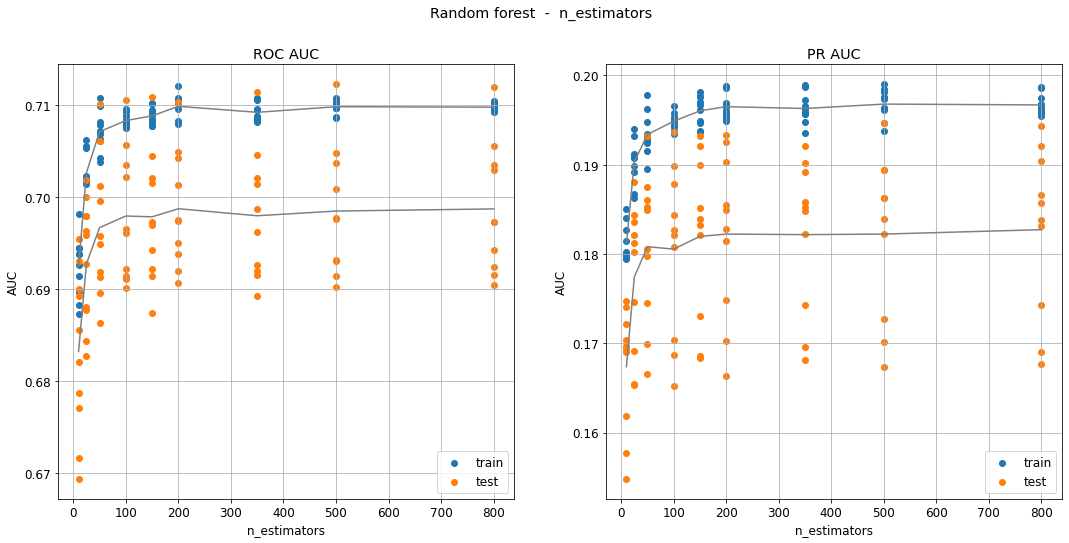

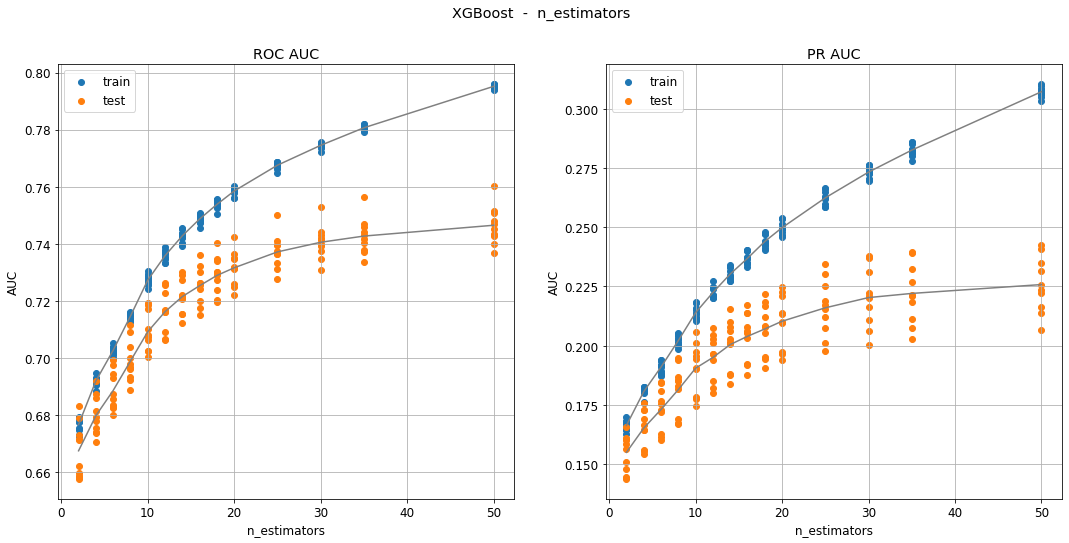

In [35]:
dfMetrics = pd.concat(results_n_estimators)
dfMetrics = dfMetrics.rename(columns={'pr_train_auc': 'pr_auc_train'})
dfMetrics['model'] = dfMetrics.apply(lambda x: x.title.split('|')[0], axis=1)
dfMetrics['parameter'] = dfMetrics.apply(lambda x: x.title.split('|')[-1].split('=')[0], axis=1)
dfMetrics['value'] = dfMetrics.apply(lambda x: float(x.title.split('|')[-1].split('=')[1]), axis=1)

dfModelParam = dfMetrics[['model','parameter']].drop_duplicates()

for index, row in dfModelParam.iterrows():
    
    m = dfMetrics[(dfMetrics.model == row.model) & (dfMetrics.parameter == row.parameter)]
    m_means = m.groupby('value').agg({'roc_auc_train':'mean','pr_auc_train':'mean','roc_auc_test':'mean','pr_auc_test':'mean'}).reset_index(drop=False)
    
    size = 1
    nbPlot = 2
    fig = plt.figure(figsize=(size * (18 * nbPlot/2), size * 8))

    sub = fig.add_subplot(1,nbPlot,1)
    plt.xlabel(row.parameter)
    plt.ylabel('AUC')
    plt.title('ROC AUC')
    #plt.axis('tight')
    plt.grid(True)
    plt.scatter(m.value.values, m.roc_auc_train.values, alpha=1, label = 'train')
    plt.plot(m_means.value, m_means.roc_auc_train, color='grey')
    plt.scatter(m.value.values, m.roc_auc_test.values, alpha=1, label = 'test')
    plt.plot(m_means.value, m_means.roc_auc_test, color='grey')
    plt.legend()
    plt.rcParams.update({'font.size':12, 'font.style':'normal'})
    plt.suptitle('ROC AUC')

    sub = fig.add_subplot(1,nbPlot,2)
    plt.xlabel(row.parameter)
    plt.ylabel('AUC')
    plt.title('PR AUC')
    #plt.axis('tight')
    plt.grid(True)
    plt.scatter(m.value.values, m.pr_auc_train.values, alpha=1, label = 'train')
    plt.plot(m_means.value, m_means.pr_auc_train, color='grey')
    plt.scatter(m.value.values, m.pr_auc_test.values, alpha=1, label = 'test')
    plt.plot(m_means.value, m_means.pr_auc_test, color='grey')
    plt.legend()
    plt.rcParams.update({'font.size':12, 'font.style':'normal'})
    plt.suptitle('PR AUC')

    plt.rcParams.update({'font.size':12, 'font.style':'normal'})
    plt.suptitle("{} - {}".format(row.model, row.parameter))

    plt.show()


### Estimation initiale

In [83]:
results = []

In [16]:
RFmodel = model=RandomForestClassifier(n_estimators=150, max_depth=5, n_jobs=-1)
XGmodel = XGBClassifier(n_estimators=30, max_depth=5)

In [85]:
results.append(evaluateRocPrCurves(dfApplicationDefault, 
                                target='TARGET', 
                                identifier='SK_ID_CURR', 
                                model=RFmodel,
                                display_plot=False,
                                title_plot = 'Random forest | Default',
                                cv=10))


results.append(evaluateRocPrCurves(dfApplicationDefault, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Default',
                            cv=10))

In [86]:
results.append(evaluateRocPrCurves(dfApplication, 
                                target='TARGET', 
                                identifier='SK_ID_CURR', 
                                model=RFmodel,
                                display_plot=False,
                                title_plot = 'Random forest | Initial',
                                cv=10))


results.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=10))

In [87]:
pd.concat(results).groupby('title').mean().reset_index().sort_values('timestamp')

title  roc_auc_train  roc_auc_test  pr_auc_train  \
0  Random forest | Default       0.693083      0.683823      0.177376   
2        XGBoost | Default       0.769454      0.735391      0.270610   
1  Random forest | Initial       0.704498      0.690862      0.194987   
3        XGBoost | Initial       0.786726      0.740878      0.300833   

   pr_auc_test  time_train  time_pred  nb_feat  nb_train     timestamp  
0     0.166367   21.880602   3.846783    199.0  276759.9  1.614592e+09  
2     0.216232   14.784975   3.750037    199.0  276759.9  1.614592e+09  
1     0.176494   15.095854   2.912123    223.0  193731.3  1.614592e+09  
3     0.222338   10.562540   2.627586    223.0  193731.3  1.614592e+09

# Sélection de variables

## Suppression de colonnes peu importantes et peu renseignées 

### Aperçu des taux de valeurs manquantes

In [23]:
statsMissingValues(dfApplication)

feature  missingRate
192       PREV_NAME_CASH_LOAN_PURPOSE    88.408739
223                    BUROBAL_STATUS    70.603047
45                     COMMONAREA_AVG    69.772412
59                    COMMONAREA_MODE    69.772412
73                    COMMONAREA_MEDI    69.772412
53            NONLIVINGAPARTMENTS_AVG    69.332008
81           NONLIVINGAPARTMENTS_MEDI    69.332008
67           NONLIVINGAPARTMENTS_MODE    69.332008
83                 FONDKAPREMONT_MODE    68.308580
51               LIVINGAPARTMENTS_AVG    68.247258
65              LIVINGAPARTMENTS_MODE    68.247258
79              LIVINGAPARTMENTS_MEDI    68.247258
63                     FLOORSMIN_MODE    67.765973
77                     FLOORSMIN_MEDI    67.765973
49                      FLOORSMIN_AVG    67.765973
72                   YEARS_BUILD_MEDI    66.418746
44                    YEARS_BUILD_AVG    66.418746
58                   YEARS_BUILD_MODE    66.418746
21                        OWN_CAR_AGE    65.982523
50                       LANDAREA_AVG    59.255216
78                      LANDAREA_MEDI    59.255216
64                      LANDAREA_MODE    59.255216
56                  BASEMENTAREA_MODE    58.466391
70                  BASEMENTAREA_MEDI    58.466391
42                   BASEMENTAREA_AVG    58.466391
54                  NONLIVINGAREA_AVG    55.090427
82                 NONLIVINGAREA_MEDI    55.090427
68                 NONLIVINGAREA_MODE    55.090427
74                     ELEVATORS_MEDI    53.244726
46                      ELEVATORS_AVG    53.244726
60                     ELEVATORS_MODE    53.244726
86                 WALLSMATERIAL_MODE    50.770474
41                     APARTMENTS_AVG    50.687783
69                    APARTMENTS_MEDI    50.687783
55                    APARTMENTS_MODE    50.687783
61                     ENTRANCES_MODE    50.283150
75                     ENTRANCES_MEDI    50.283150
47                      ENTRANCES_AVG    50.283150
66                    LIVINGAREA_MODE    50.148427
80                    LIVINGAREA_MEDI    50.148427
52                     LIVINGAREA_AVG    50.148427
84                     HOUSETYPE_MODE    50.120089
76                     FLOORSMAX_MEDI    49.705236
62                     FLOORSMAX_MODE    49.705236
48                      FLOORSMAX_AVG    49.705236
71       YEARS_BEGINEXPLUATATION_MEDI    48.738020
57       YEARS_BEGINEXPLUATATION_MODE    48.738020
43        YEARS_BEGINEXPLUATATION_AVG    48.738020
85                     TOTALAREA_MODE    48.243263
87                EMERGENCYSTATE_MODE    47.376392
152            PREV_NAME_PRODUCT_TYPE    46.782683
28                    OCCUPATION_TYPE    31.404786
148              PREV_NAME_TYPE_SUITE    22.217628
40                  ORGANIZATION_TYPE    18.029611
177              BURO_CREDIT_CURRENCY    14.365619
176                BURO_CREDIT_ACTIVE    14.365619
178                  BURO_CREDIT_TYPE    14.365619
114         AMT_REQ_CREDIT_BUREAU_DAY    13.556818
117         AMT_REQ_CREDIT_BUREAU_QRT    13.556818
116         AMT_REQ_CREDIT_BUREAU_MON    13.556818
115        AMT_REQ_CREDIT_BUREAU_WEEK    13.556818
118        AMT_REQ_CREDIT_BUREAU_YEAR    13.556818
113        AMT_REQ_CREDIT_BUREAU_HOUR    13.556818
150          PREV_NAME_GOODS_CATEGORY    13.368206
147            PREV_NAME_PAYMENT_TYPE    11.620993
154         PREV_NAME_SELLER_INDUSTRY    11.583363
155             PREV_NAME_YIELD_GROUP     6.560065
149             PREV_NAME_CLIENT_TYPE     5.689943
157              PREV_CONTRACT_STATUS     5.680652
156          PREV_PRODUCT_COMBINATION     5.680652
153                 PREV_CHANNEL_TYPE     5.680652
151               PREV_NAME_PORTFOLIO     5.680652
146   PREV_WEEKDAY_APPR_PROCESS_START     5.680652
145           PREV_NAME_CONTRACT_TYPE     5.680652
193         PREV_NAME_CONTRACT_STATUS     5.333624
191  PREV_FLAG_LAST_APPL_PER_CONTRACT     5.333624
11                    NAME_TYPE_SUITE     0.419963
89           DEF_30_CNT_SOCIAL_CIRCLE     0.329374
9

In [24]:
dfApplication = delColWIthMissing(dfApplication, 0.9)

In [25]:
dfMissing = statsMissingValues(dfApplication)
dfMissing = dfMissing[dfMissing.feature != 'TARGET']

### Jeu d'entrainement sans missing values

In [26]:
dfApplicationWithoutMissing = dfApplication.dropna().copy()

In [27]:
from collections import Counter
target = dfApplicationWithoutMissing['TARGET']
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))
print(dfApplicationWithoutMissing.shape)

Class=0, Count=389, Percentage=92.619%
Class=1, Count=31, Percentage=7.381%
(420, 225)


### Calcul des feature importance

In [28]:
imp =  evaluateFeatureImportance(dfApplicationWithoutMissing, 
                                target='TARGET', 
                                identifier='SK_ID_CURR', 
                                minmax=[], 
                                standard=[], 
                                robust=[], 
                                ordinal=[], 
                                onehot=[],
                                models=[RFmodel, XGmodel],
                                show_plot=False,
                                label_models=['Rando forest','XGBoost'],
                                title_plot='No title')

### Merge des feature importance avec les stats missing

In [29]:
dfMissing = dfMissing.merge(imp, left_on='feature', right_on='feature')

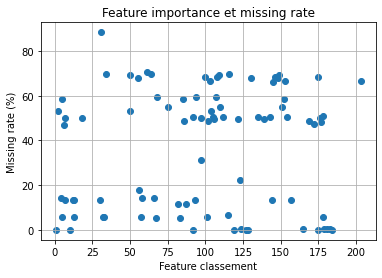

In [30]:
plt.scatter(dfMissing.bestClassement, dfMissing.missingRate)
plt.title('Feature importance et missing rate')
plt.xlabel("Feature classement")
plt.ylabel("Missing rate (%)")
plt.grid(True)
plt.show()

### Suppression des colonnes peu importantes avec un fort taux de valeurs manquantes

In [31]:
for index, row in dfMissing.iterrows():
    if (row.missingRate > 40) & (row.bestClassement > 25):
        print(row.feature)
        del dfApplication[row.feature]

PREV_NAME_CASH_LOAN_PURPOSE
BUROBAL_STATUS
COMMONAREA_AVG
COMMONAREA_MODE
COMMONAREA_MEDI
NONLIVINGAPARTMENTS_AVG
NONLIVINGAPARTMENTS_MEDI
NONLIVINGAPARTMENTS_MODE
FONDKAPREMONT_MODE
LIVINGAPARTMENTS_AVG
LIVINGAPARTMENTS_MODE
LIVINGAPARTMENTS_MEDI
FLOORSMIN_MODE
FLOORSMIN_MEDI
FLOORSMIN_AVG
YEARS_BUILD_MEDI
YEARS_BUILD_AVG
YEARS_BUILD_MODE
OWN_CAR_AGE
LANDAREA_AVG
LANDAREA_MEDI
LANDAREA_MODE
BASEMENTAREA_MODE
BASEMENTAREA_MEDI
NONLIVINGAREA_AVG
NONLIVINGAREA_MEDI
NONLIVINGAREA_MODE
ELEVATORS_MEDI
ELEVATORS_AVG
WALLSMATERIAL_MODE
APARTMENTS_AVG
APARTMENTS_MEDI
APARTMENTS_MODE
ENTRANCES_MODE
ENTRANCES_MEDI
ENTRANCES_AVG
LIVINGAREA_MODE
HOUSETYPE_MODE
FLOORSMAX_MEDI
FLOORSMAX_MODE
FLOORSMAX_AVG
YEARS_BEGINEXPLUATATION_MEDI
YEARS_BEGINEXPLUATATION_MODE
YEARS_BEGINEXPLUATATION_AVG
TOTALAREA_MODE
EMERGENCYSTATE_MODE


## Sélection des meilleures variables

In [32]:
dfApplicationWithoutMissing = dfApplication.copy()
dfApplicationWithoutMissing = dfApplicationWithoutMissing.dropna()

print(dfApplicationWithoutMissing.shape)

(21402, 179)


### Calcul des feature importance

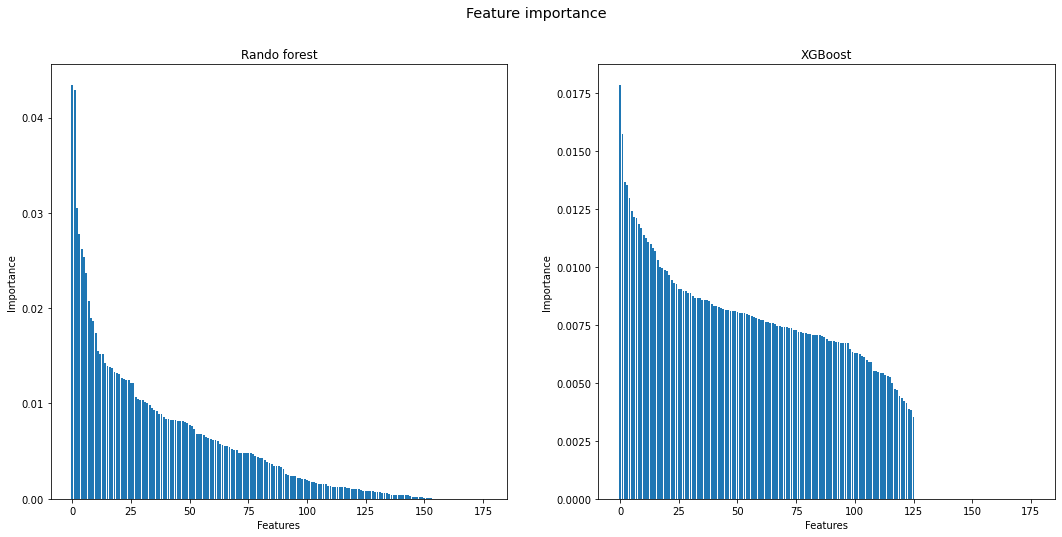

In [33]:
imp =  evaluateFeatureImportance(dfApplicationWithoutMissing, 
                                target='TARGET', 
                                identifier='SK_ID_CURR', 
                                minmax=[], 
                                standard=[], 
                                robust=[], 
                                ordinal=[], 
                                onehot=[],
                                models=[RFmodel, XGmodel],
                                show_plot=True,
                                label_models=['Rando forest','XGBoost'],
                                title_plot='Feature importance')

### Suppression de variables

In [34]:
for index, row in imp.iterrows():
    if (row.RFClassement > 30) & (row.XGClassement > 30):
        print(row.feature)
        del dfApplication[row.feature]

CREDCARD_AMT_INST_MIN_REGULARITY
BURO_CREDIT_CURRENCY
PREV_DAYS_FIRST_DRAWING
CREDCARD_MONTHS_BALANCE
PREV_CONTRACT_STATUS
CREDCARD_AMT_PAYMENT_CURRENT
INSTALPAYMT_AMT_INSTALMENT
PREV_AMT_CREDIT_ACTIVE_REIMBURSED_INDIC
POSCASH_MONTHS_BALANCE
POSCASH_SK_DPD_DEF
PREV_NAME_YIELD_GROUP_ORD
FLAG_EMP_PHONE
PREV_AMT_CREDIT
PREV_NAME_PORTFOLIO
BURO_CREDIT_DAY_OVERDUE
PREV_CHANNEL_TYPE
INSTALPAYMT_AMT_PAYMENT
ORGANIZATION_TYPE
CREDCARD_AMT_DRAWINGS_OTHER_CURRENT
NAME_FAMILY_STATUS
FLAG_DOCUMENT_8
CREDCARD_CNT_DRAWINGS_POS_CURRENT
CREDCARD_SK_DPD
BURO_DAYS_CREDIT_ENDDATE
OBS_30_CNT_SOCIAL_CIRCLE
CREDCARD_CNT_INSTALMENT_MATURE_CUM
PREV_DAYS_LAST_DUE
BUROBAL_MONTHS_BALANCE
PREV_X_SELL
PREV_AMT_DOWN_PAYMENT
BUROBAL_SK_DPD
PREV_WEEKDAY_APPR_PROCESS_START
PREV_PRODUCT_COMBINATION
BURO_AMT_CREDIT_SUM_LIMIT
PREV_LAST_NAME_CONTRACT_STATUS
PREV_AMT_ANNUITY
PREV_NAME_PAYMENT_TYPE
BURO_CNT_CREDIT_PROLONG
FLAG_DOCUMENT_7
BURO_AMT_CREDIT_MAX_OVERDUE
PREV_DAYS_FIRST_DUE
REGION_RATING_CLIENT_W_CITY
CREDCARD_AM

## Evaluation après purge des variables

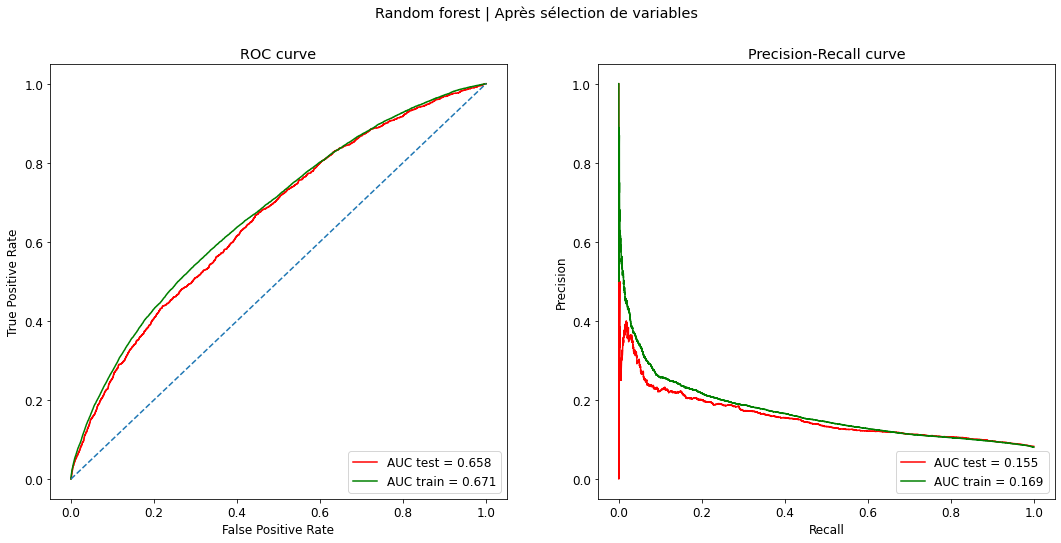

TRAIN SET: ROC AUC=0.671, PR AUC=0.169
TEST SET:  ROC AUC=0.658, PR AUC=0.155


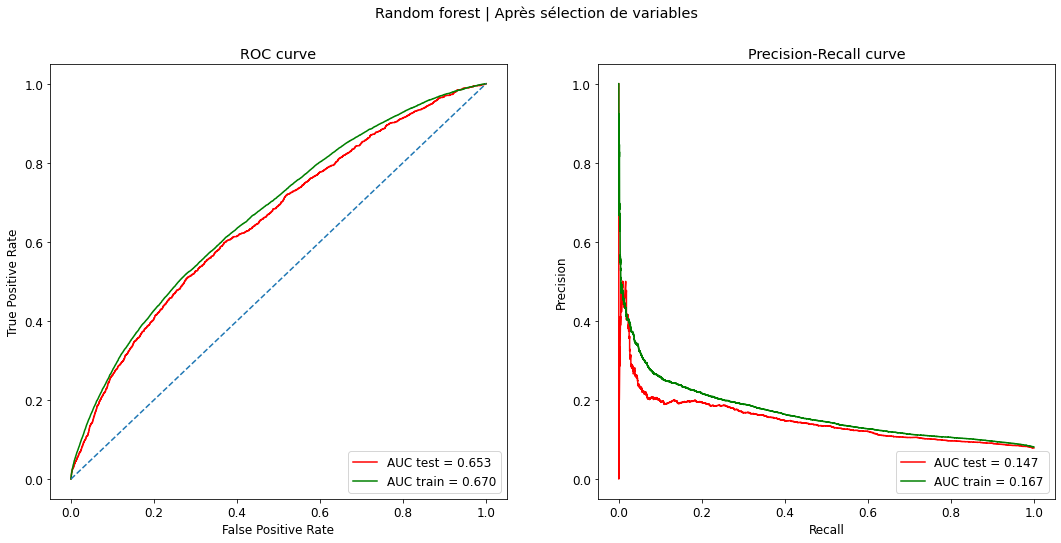

TRAIN SET: ROC AUC=0.670, PR AUC=0.167
TEST SET:  ROC AUC=0.653, PR AUC=0.147


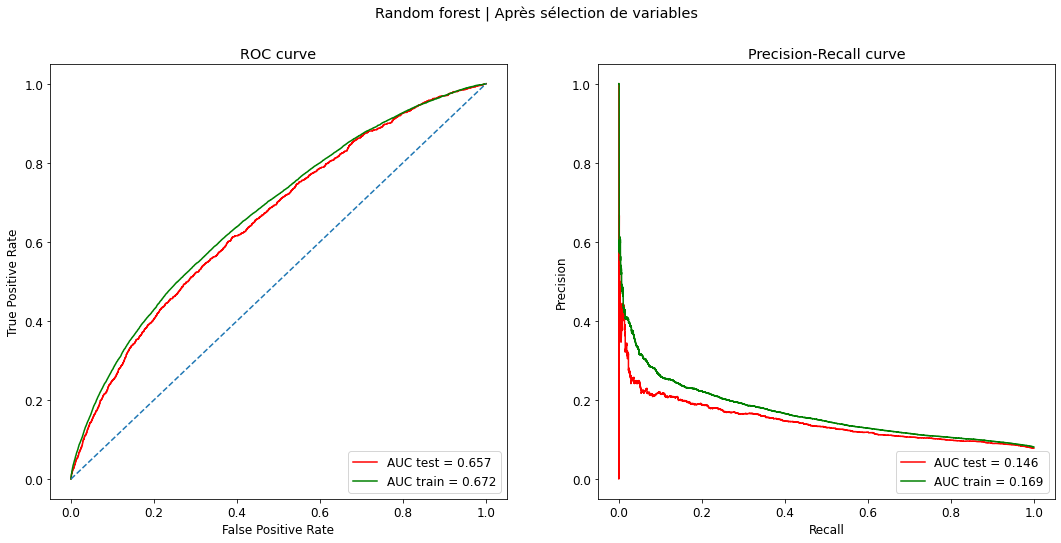

TRAIN SET: ROC AUC=0.672, PR AUC=0.169
TEST SET:  ROC AUC=0.657, PR AUC=0.146


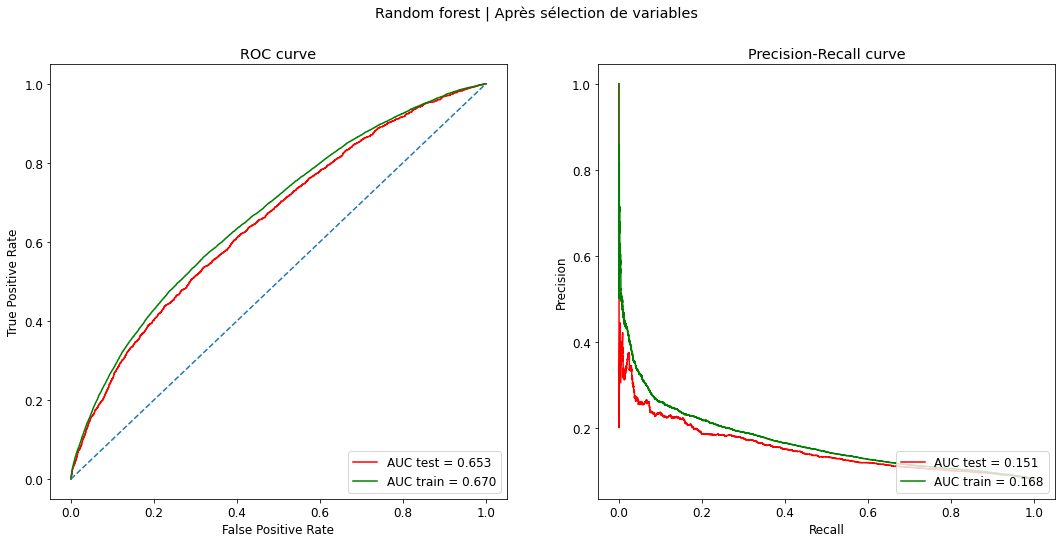

TRAIN SET: ROC AUC=0.670, PR AUC=0.168
TEST SET:  ROC AUC=0.653, PR AUC=0.151


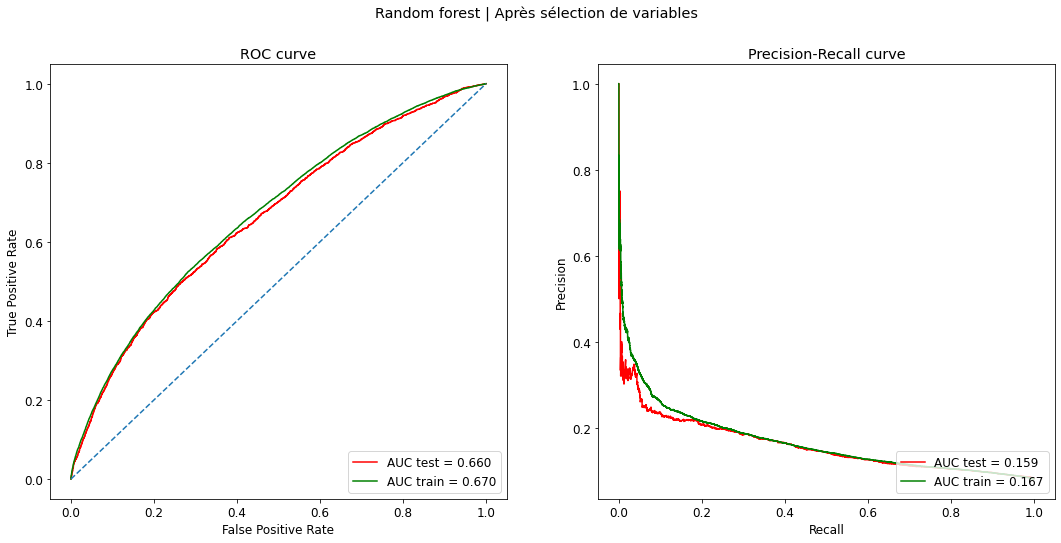

TRAIN SET: ROC AUC=0.670, PR AUC=0.167
TEST SET:  ROC AUC=0.660, PR AUC=0.159


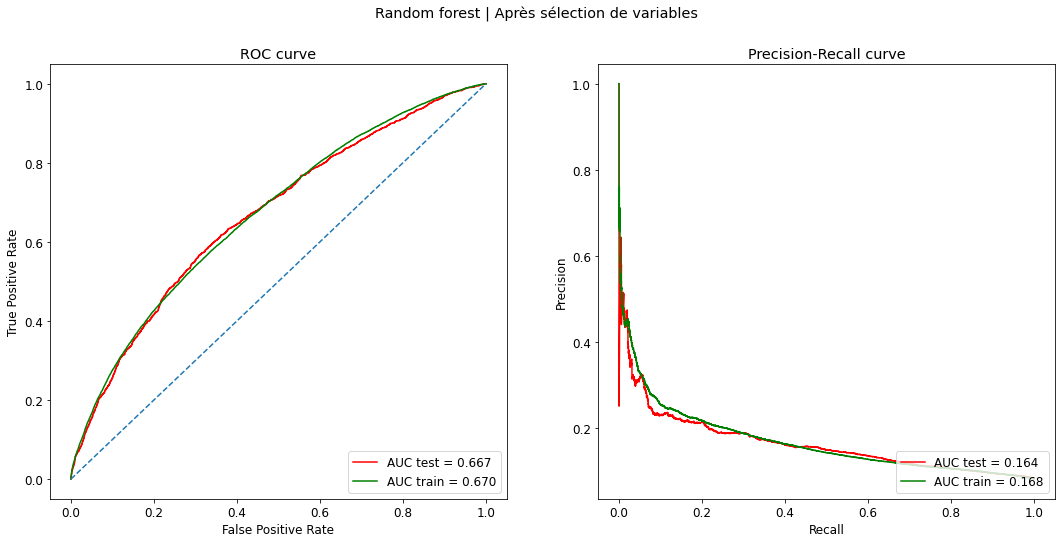

TRAIN SET: ROC AUC=0.670, PR AUC=0.168
TEST SET:  ROC AUC=0.667, PR AUC=0.164


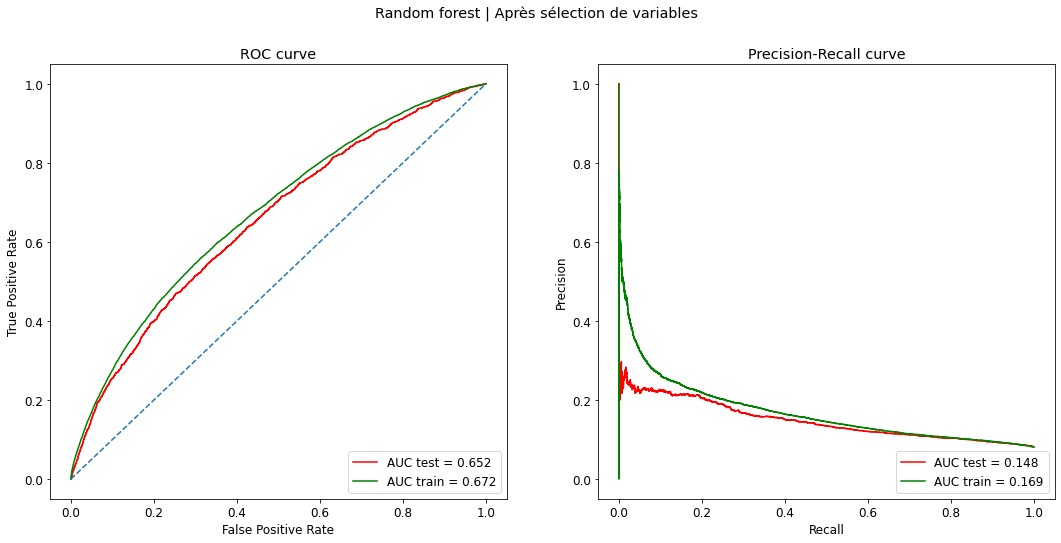

TRAIN SET: ROC AUC=0.672, PR AUC=0.169
TEST SET:  ROC AUC=0.652, PR AUC=0.148


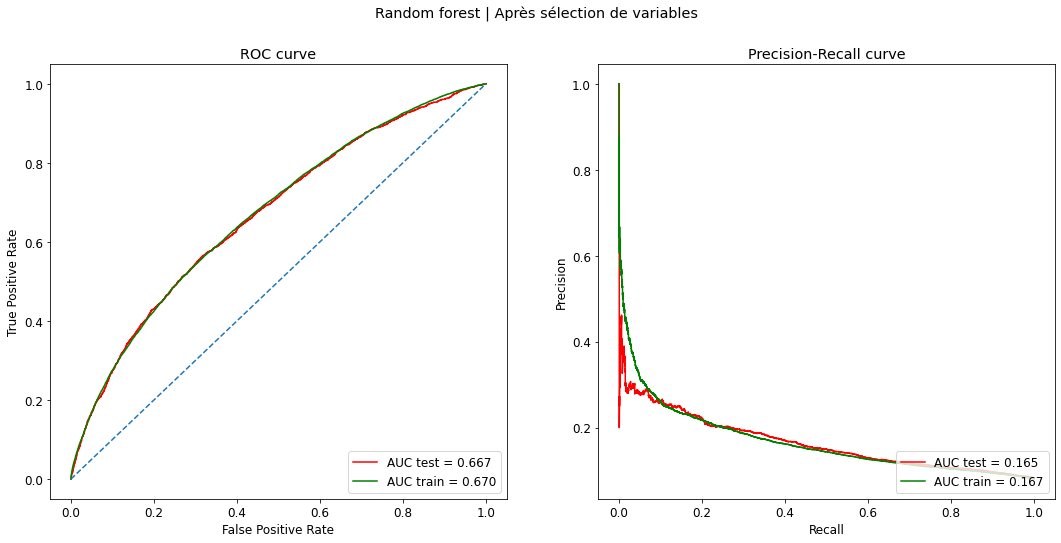

TRAIN SET: ROC AUC=0.670, PR AUC=0.167
TEST SET:  ROC AUC=0.667, PR AUC=0.165


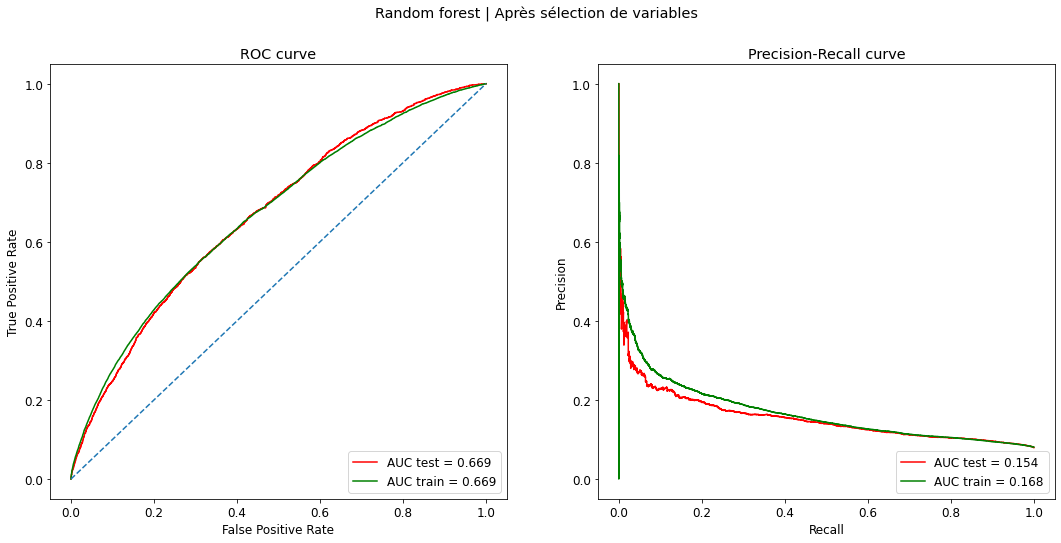

TRAIN SET: ROC AUC=0.669, PR AUC=0.168
TEST SET:  ROC AUC=0.669, PR AUC=0.154


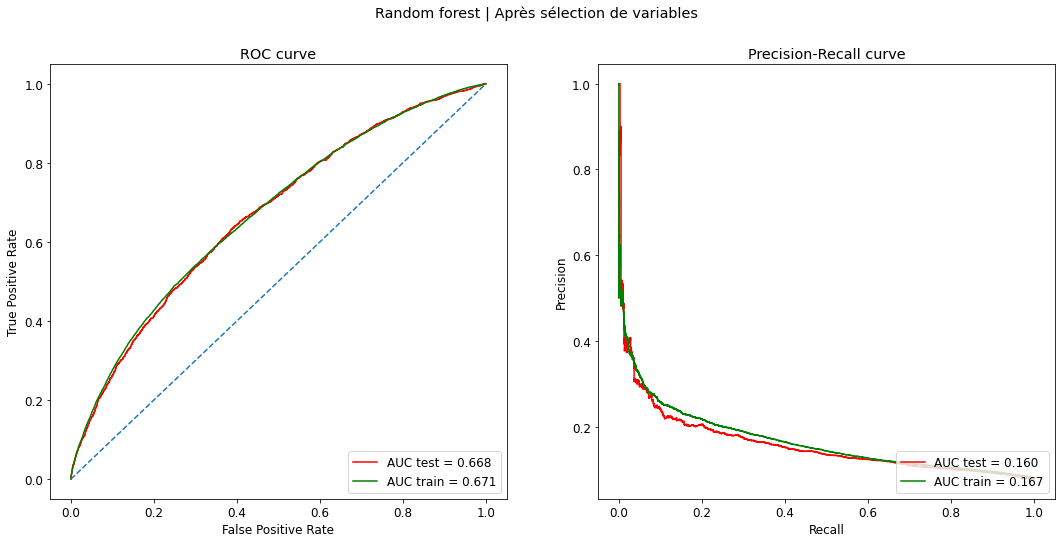

TRAIN SET: ROC AUC=0.671, PR AUC=0.167
TEST SET:  ROC AUC=0.668, PR AUC=0.160

_______________________________________________________________________________________________________________________________________
METRIQUES MOYENNES TEST:
ROC AUC = 0.660
PR AUC  = 0.155
_______________________________________________________________________________________________________________________________________
_______________________________________________________________________________________________________________________________________
METRIQUES MOYENNES TRAIN:
ROC AUC = 0.670
PR AUC  = 0.168
_______________________________________________________________________________________________________________________________________




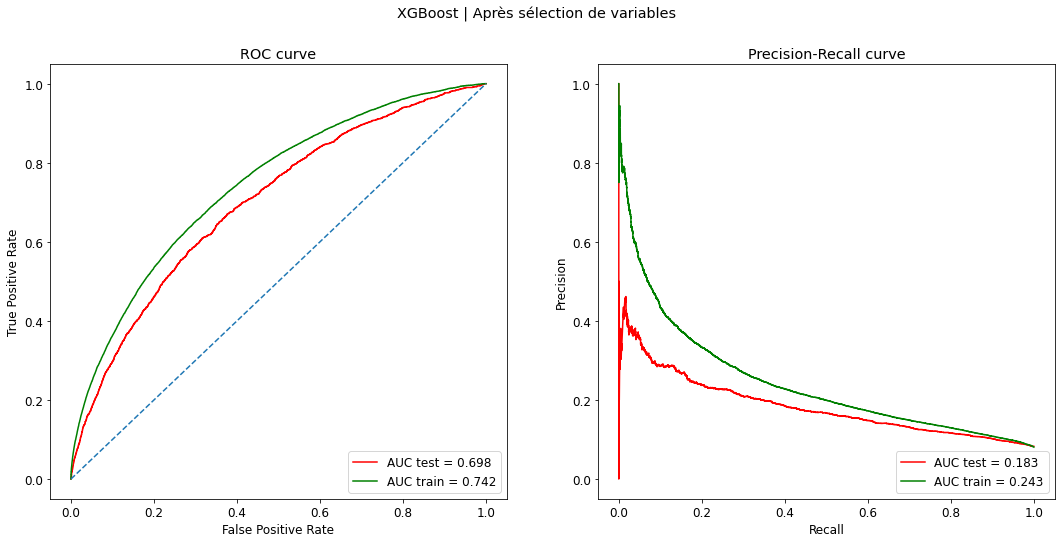

TRAIN SET: ROC AUC=0.742, PR AUC=0.243
TEST SET:  ROC AUC=0.698, PR AUC=0.183


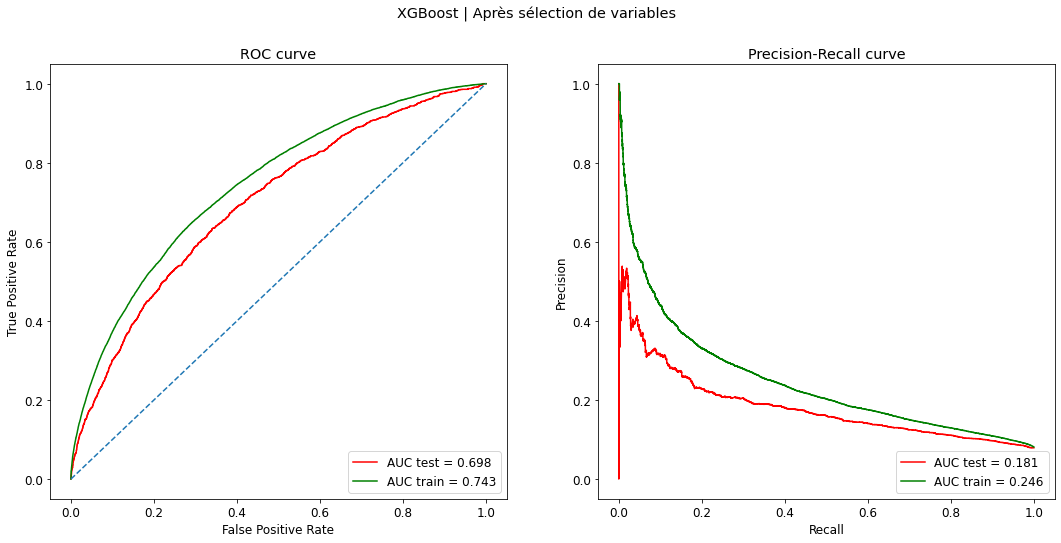

TRAIN SET: ROC AUC=0.743, PR AUC=0.246
TEST SET:  ROC AUC=0.698, PR AUC=0.181


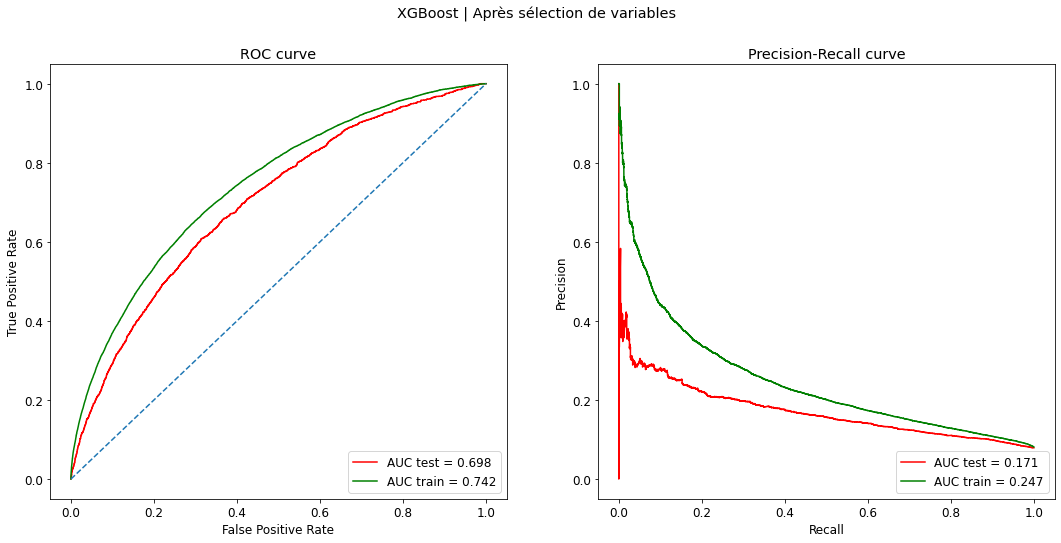

TRAIN SET: ROC AUC=0.742, PR AUC=0.247
TEST SET:  ROC AUC=0.698, PR AUC=0.171


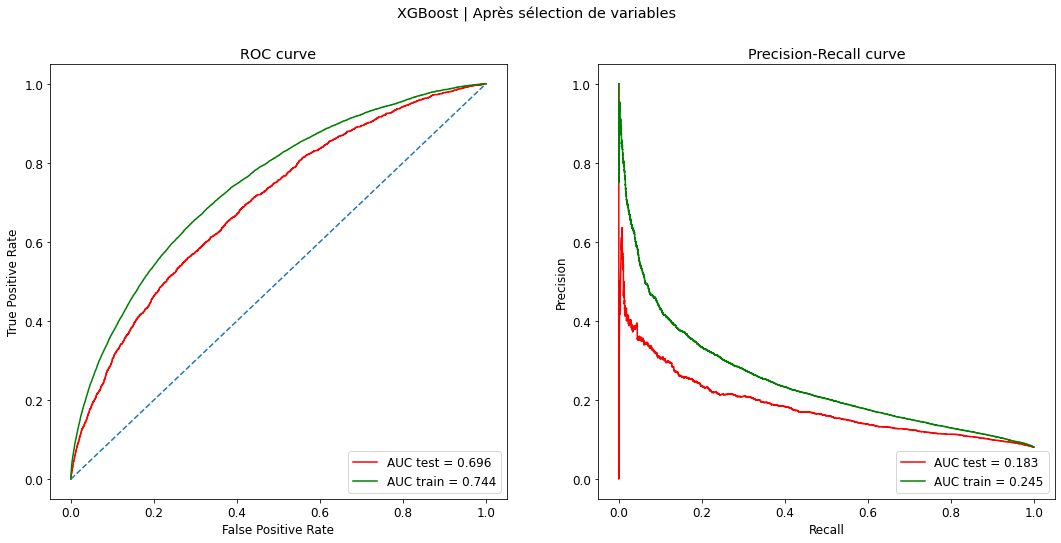

TRAIN SET: ROC AUC=0.744, PR AUC=0.245
TEST SET:  ROC AUC=0.696, PR AUC=0.183


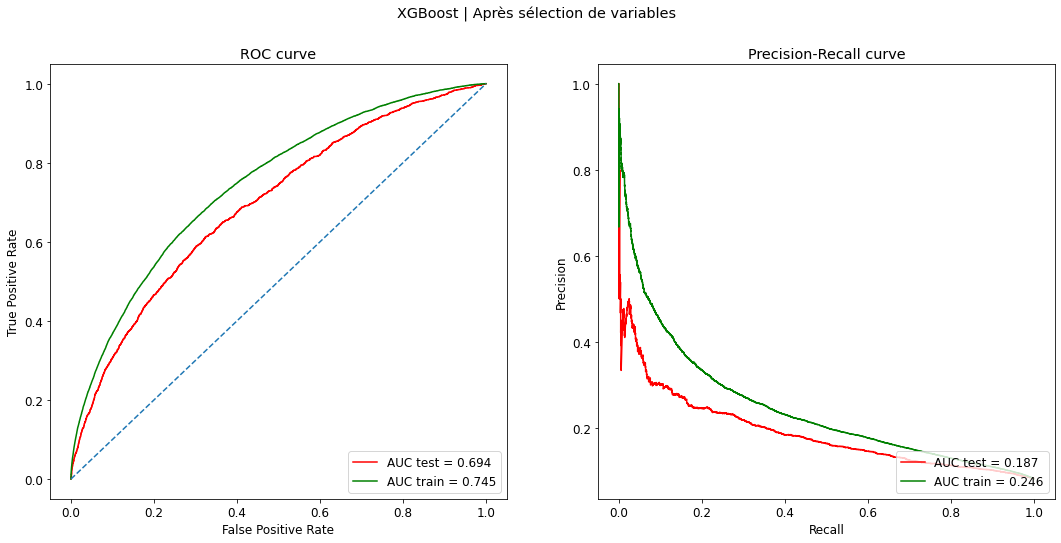

TRAIN SET: ROC AUC=0.745, PR AUC=0.246
TEST SET:  ROC AUC=0.694, PR AUC=0.187


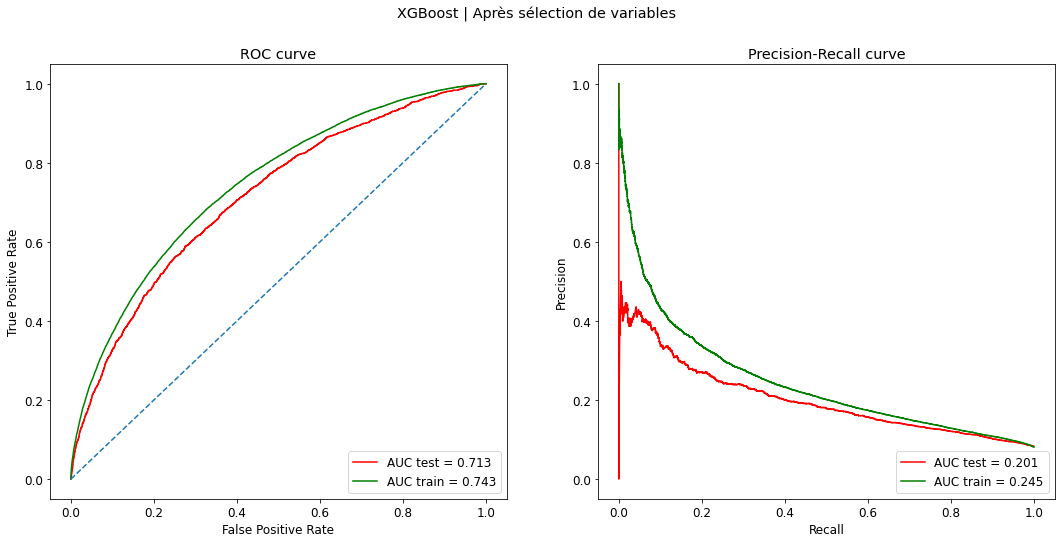

TRAIN SET: ROC AUC=0.743, PR AUC=0.245
TEST SET:  ROC AUC=0.713, PR AUC=0.201


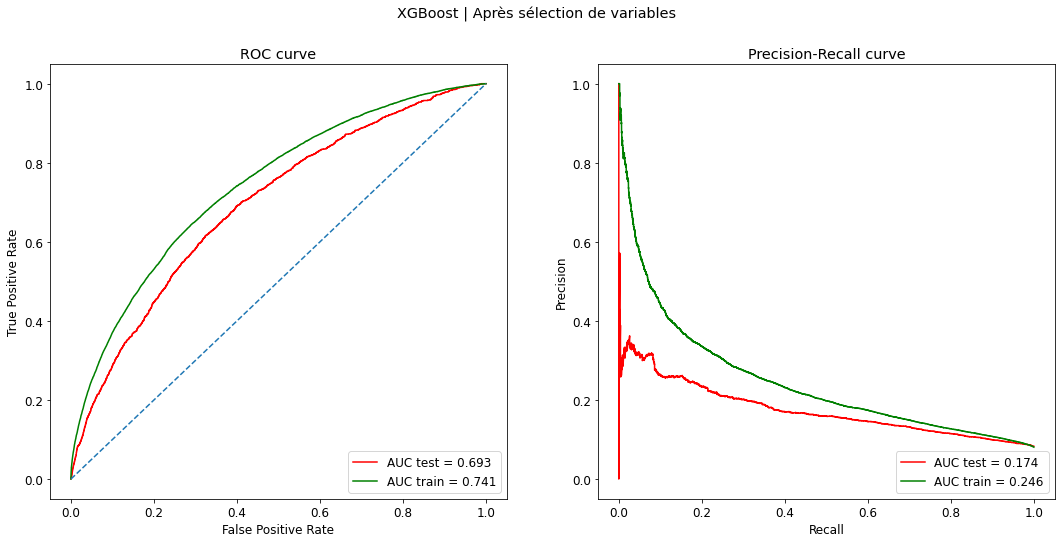

TRAIN SET: ROC AUC=0.741, PR AUC=0.246
TEST SET:  ROC AUC=0.693, PR AUC=0.174


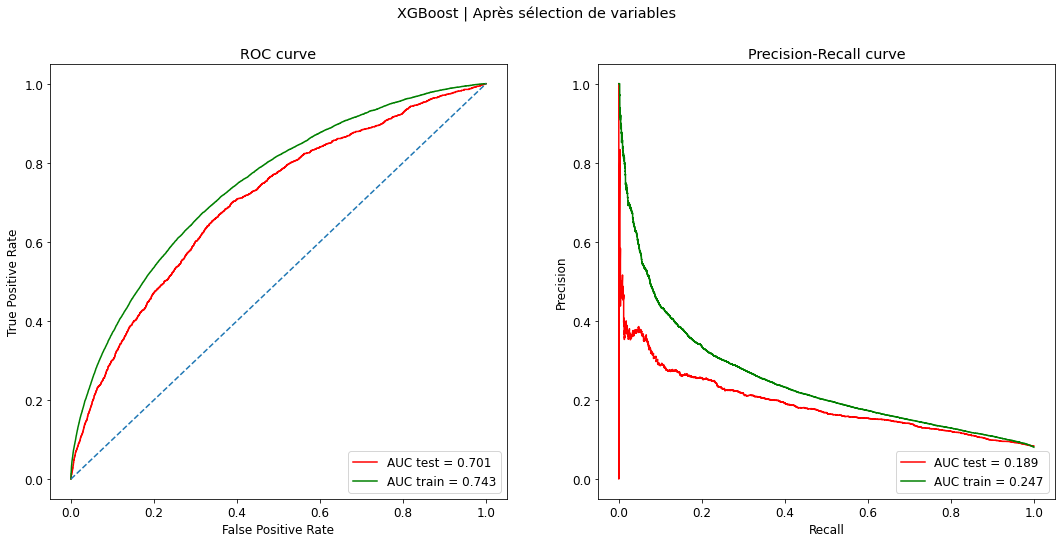

TRAIN SET: ROC AUC=0.743, PR AUC=0.247
TEST SET:  ROC AUC=0.701, PR AUC=0.189


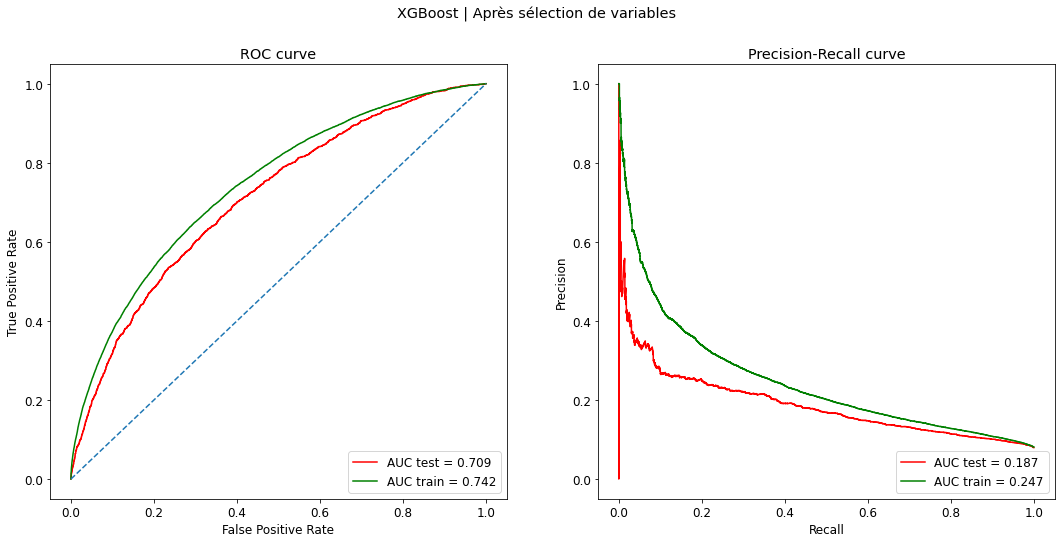

TRAIN SET: ROC AUC=0.742, PR AUC=0.247
TEST SET:  ROC AUC=0.709, PR AUC=0.187


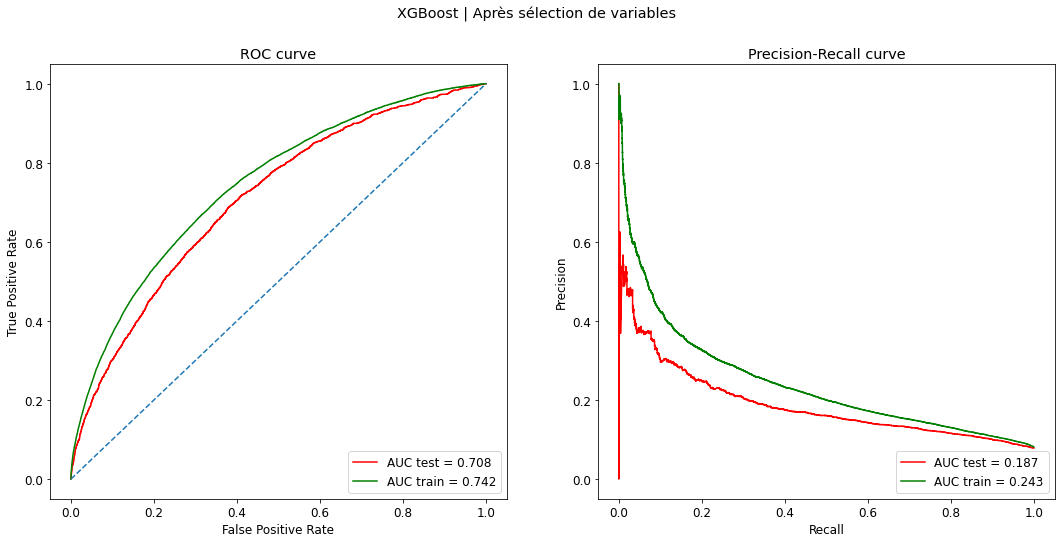

TRAIN SET: ROC AUC=0.742, PR AUC=0.243
TEST SET:  ROC AUC=0.708, PR AUC=0.187

_______________________________________________________________________________________________________________________________________
METRIQUES MOYENNES TEST:
ROC AUC = 0.701
PR AUC  = 0.184
_______________________________________________________________________________________________________________________________________
_______________________________________________________________________________________________________________________________________
METRIQUES MOYENNES TRAIN:
ROC AUC = 0.743
PR AUC  = 0.245
_______________________________________________________________________________________________________________________________________




In [145]:
results.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=RFmodel,
                            display_plot=True,
                            title_plot = 'Random forest | Après sélection de variables',
                            cv=10))


results.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=XGmodel,
                            display_plot=True,
                            title_plot = 'XGBoost | Après sélection de variables',
                            cv=10))

In [146]:
pd.concat(results).groupby('title').mean().reset_index().sort_values('timestamp')

title  roc_auc_train  roc_auc_test  \
1                       Random forest | Default       0.693083      0.683823   
4                             XGBoost | Default       0.769454      0.735391   
2                       Random forest | Initial       0.704498      0.690862   
5                             XGBoost | Initial       0.786726      0.740878   
0  Random forest | Après sélection de variables       0.670415      0.660295   
3        XGBoost | Après sélection de variables       0.742746      0.700827   

   pr_auc_train  pr_auc_test  time_train  time_pred  nb_feat  nb_train  \
1      0.177376     0.166367   21.880602   3.846783    199.0  276759.9   
4      0.270610     0.216232   14.784975   3.750037    199.0  276759.9   
2      0.194987     0.176494   15.095854   2.912123    223.0  193731.3   
5      0.300833     0.222338   10.562540   2.627586    223.0  193731.3   
0      0.167971     0.154917    7.762461   0.825087     50.0  193731.3   
3      0.245445     0.184340    3.346816   0.596764     50.0  193731.3   

      timestamp  
1  1.614592e+09  
4  1.614592e+09  
2  1.614592e+09  
5  1.614592e+09  
0  1.614604e+09  
3  1.614604e+09

# Statistiques

In [35]:
statFeat, imp = getStatsAndImp(dfApplication)

In [19]:
categorical_col = []
ordinal_col = []
numerical_col = []

for col in dfApplication.columns:
    if col not in ['TARGET','SK_ID_CURR']:
        if dfApplication[col].dtypes == 'object':
            categorical_col.append(col)
        else:
            if dfApplication[col].nunique() < 100:
                ordinal_col.append(col)
            else:
                numerical_col.append(col)

## Variables catégorielles

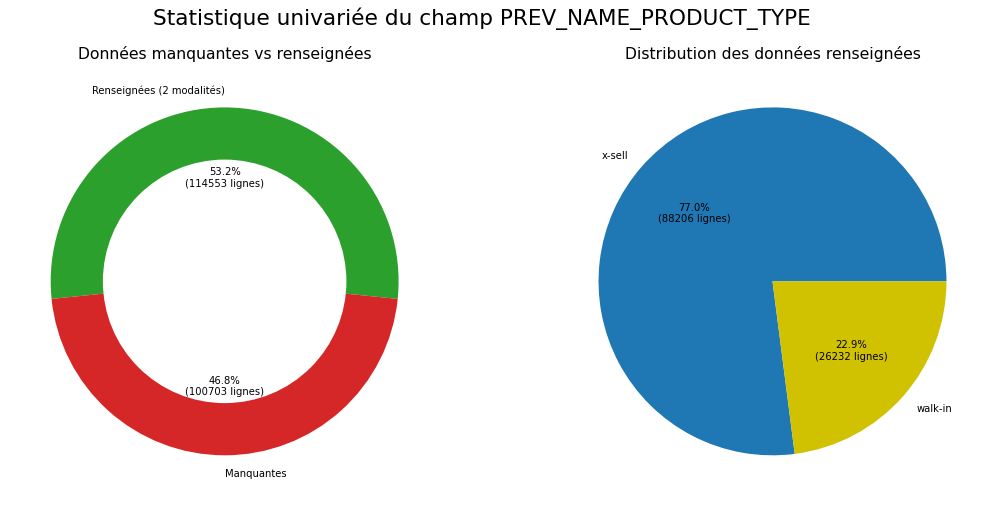

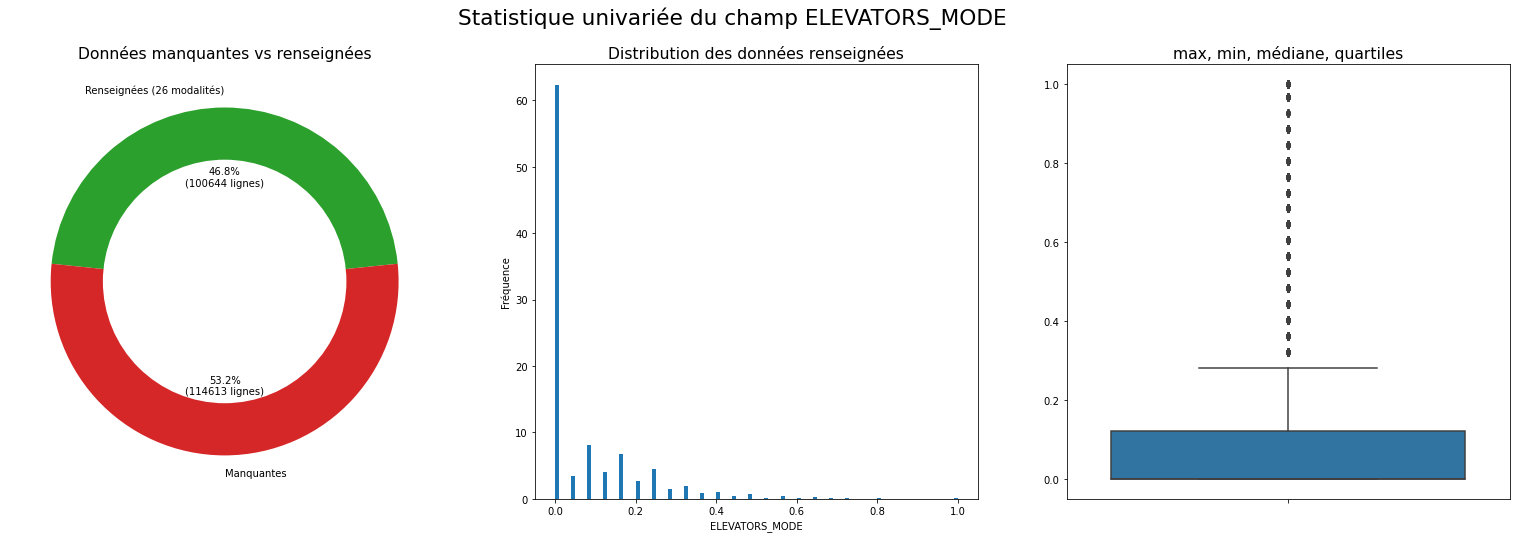

Mesures de position
 - Moyenne: 0.07
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.13
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.12
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.53
 - Kurtosis (applatissement): 8.4


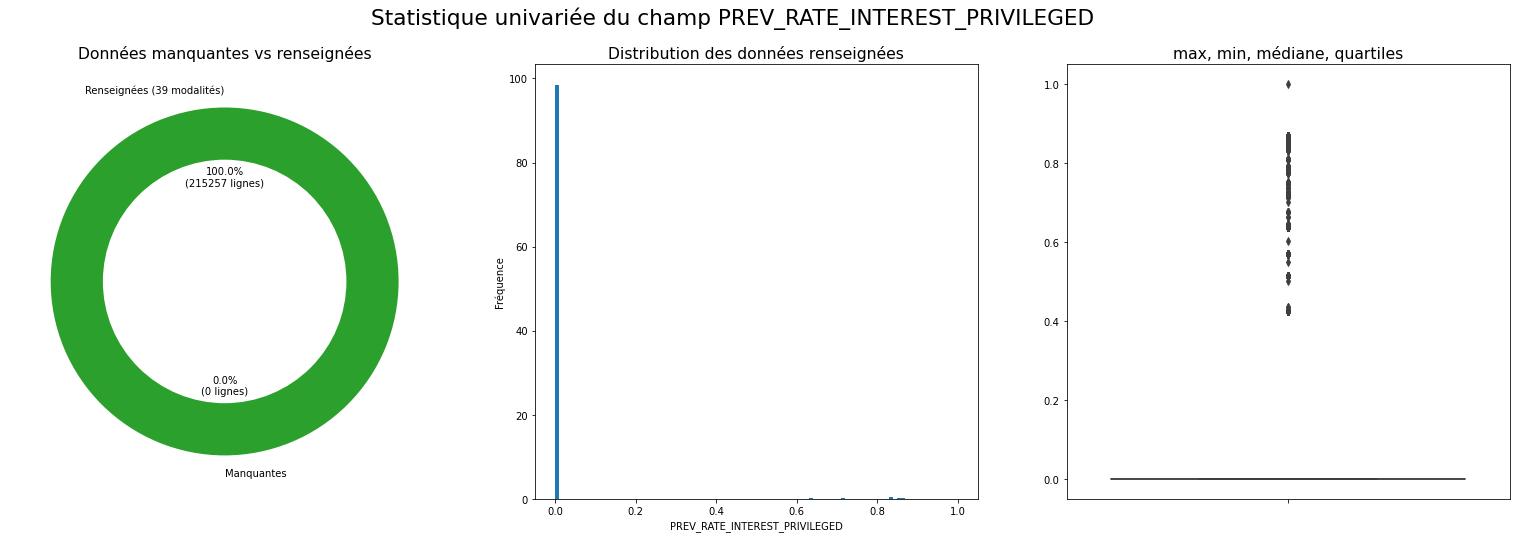

Mesures de position
 - Moyenne: 0.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.09
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 8.16
 - Kurtosis (applatissement): 65.38


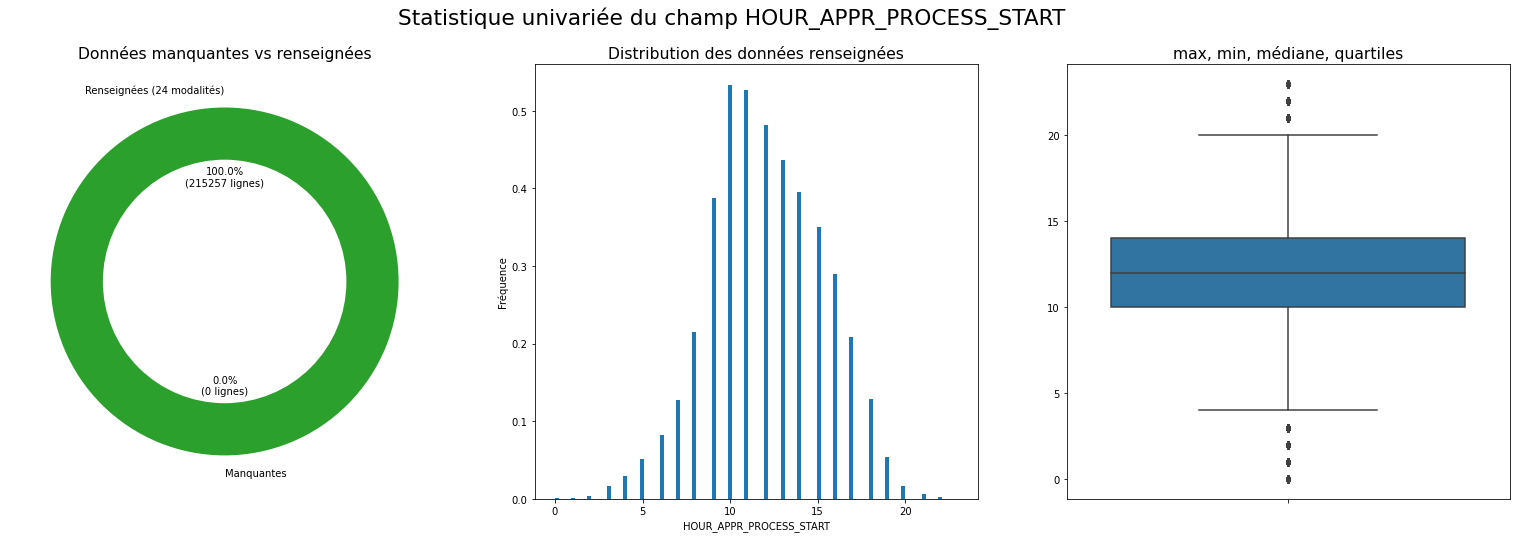

Mesures de position
 - Moyenne: 12.06
 - Médiane: 12.0
Mesures de dispertion
 - Ecart type: 3.26
 - Min: 0
 - Q25: 10.0
 - Q75: 14.0
 - Max: 23
Mesures de forme
 - Skewness (asymétrie): -0.03
 - Kurtosis (applatissement): -0.2


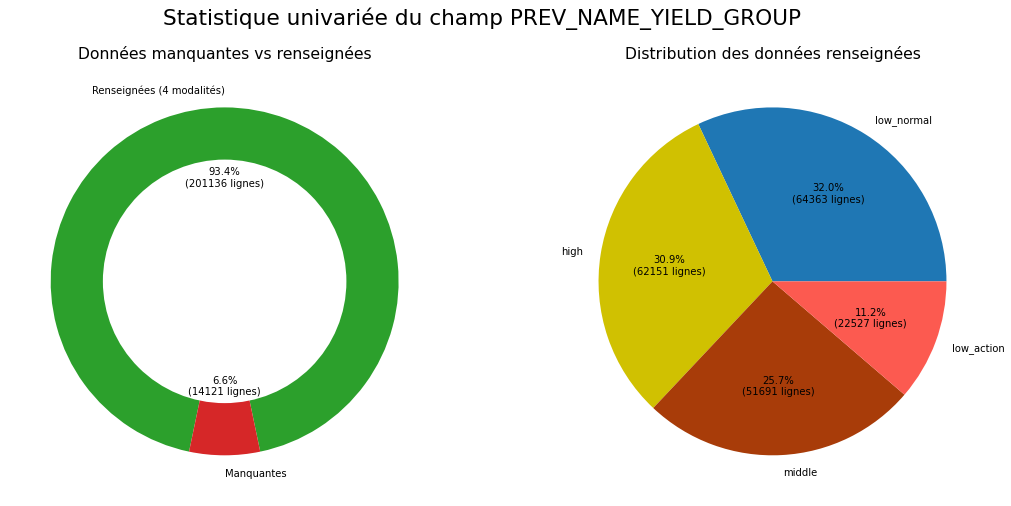

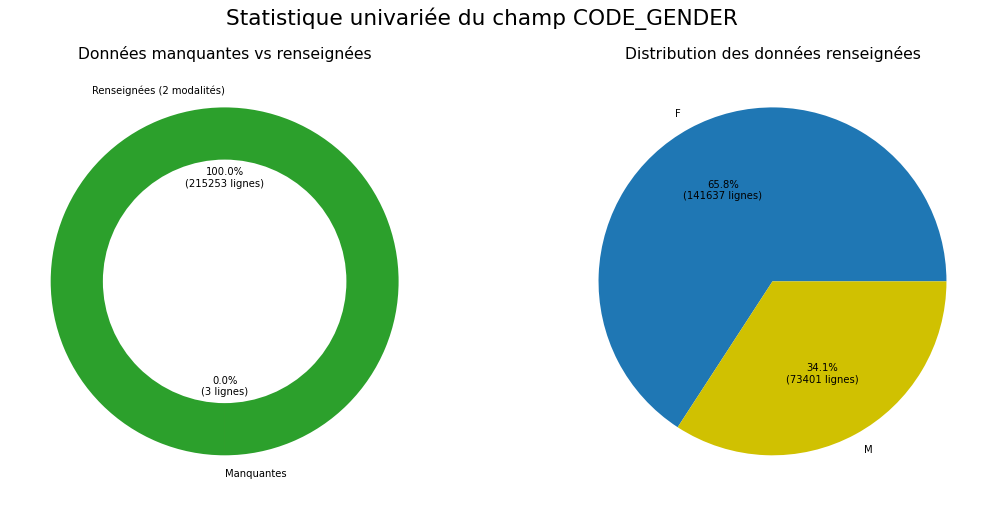

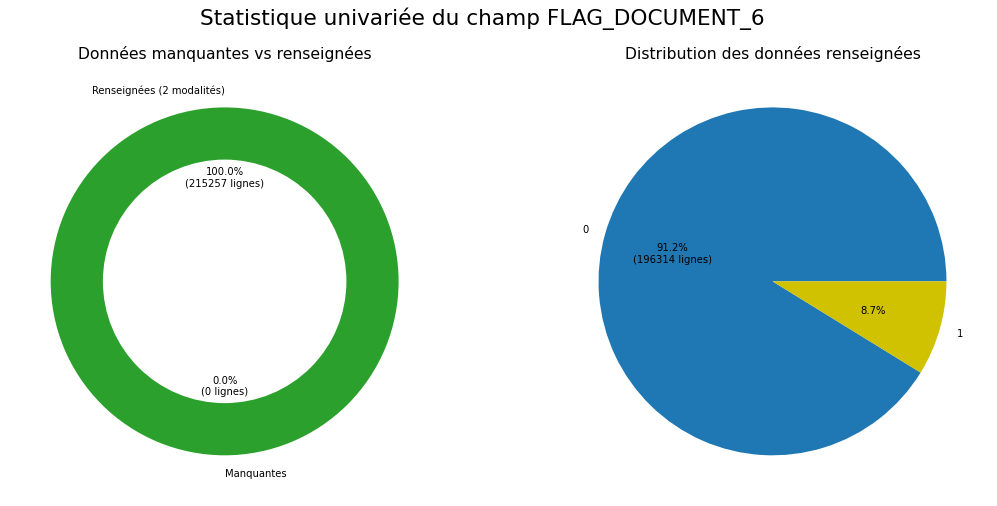

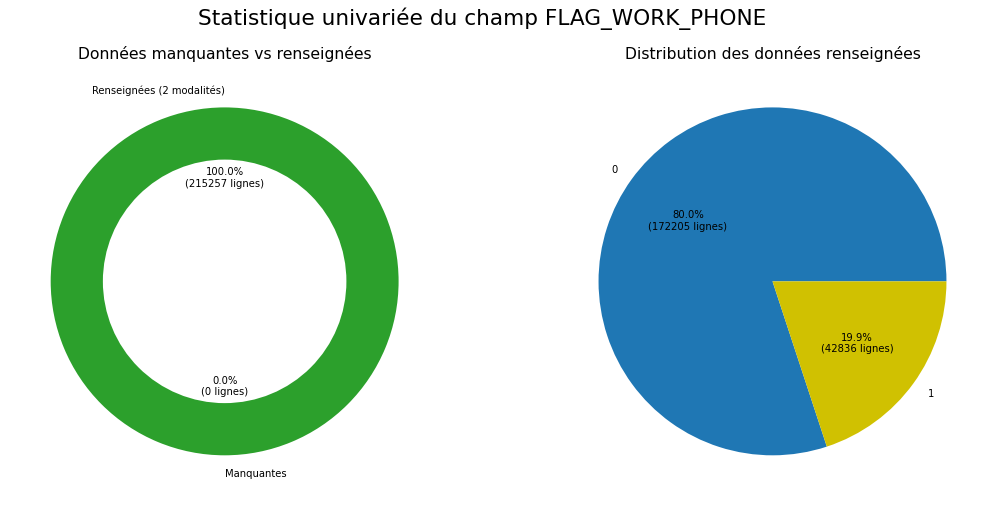

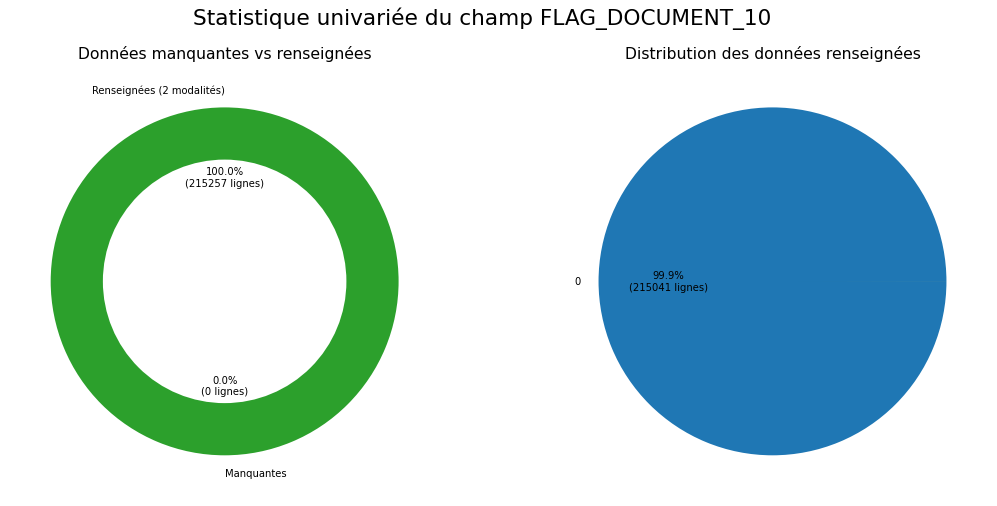

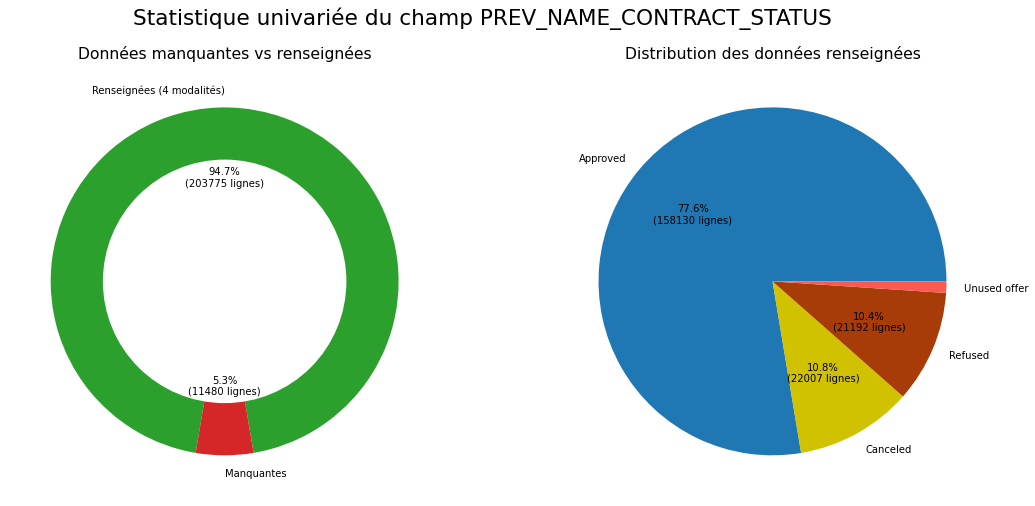

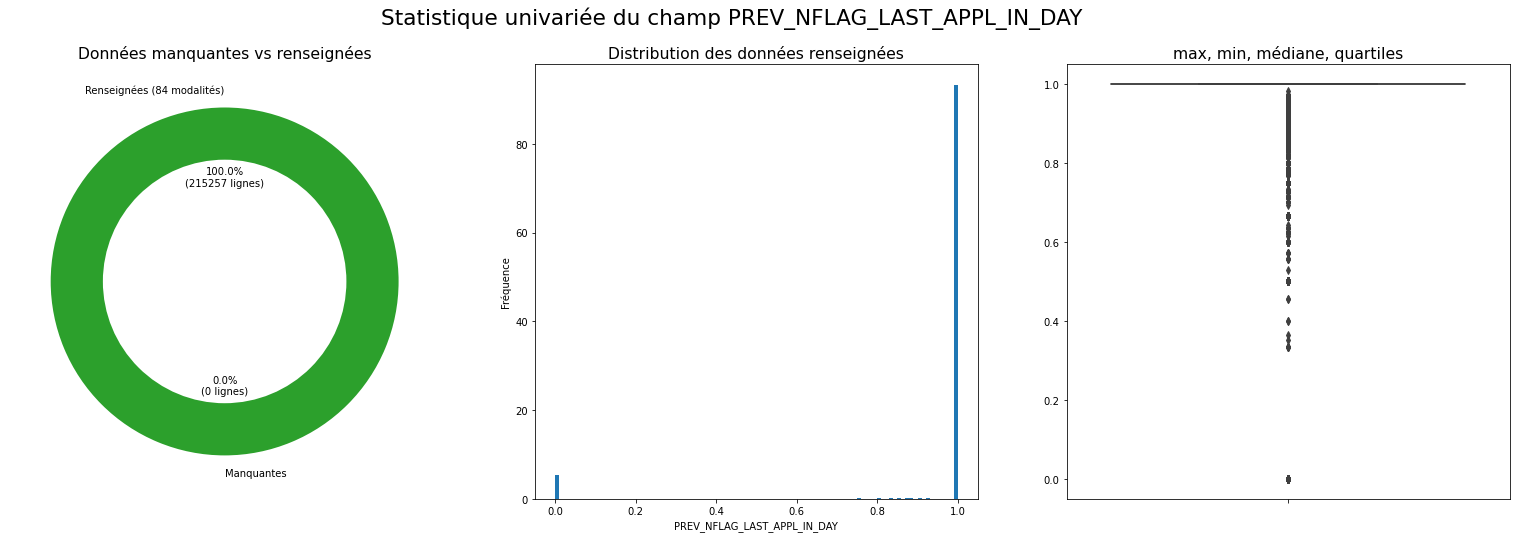

Mesures de position
 - Moyenne: 0.94
 - Médiane: 1.0
Mesures de dispertion
 - Ecart type: 0.23
 - Min: 0.0
 - Q25: 1.0
 - Q75: 1.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): -3.92
 - Kurtosis (applatissement): 13.46


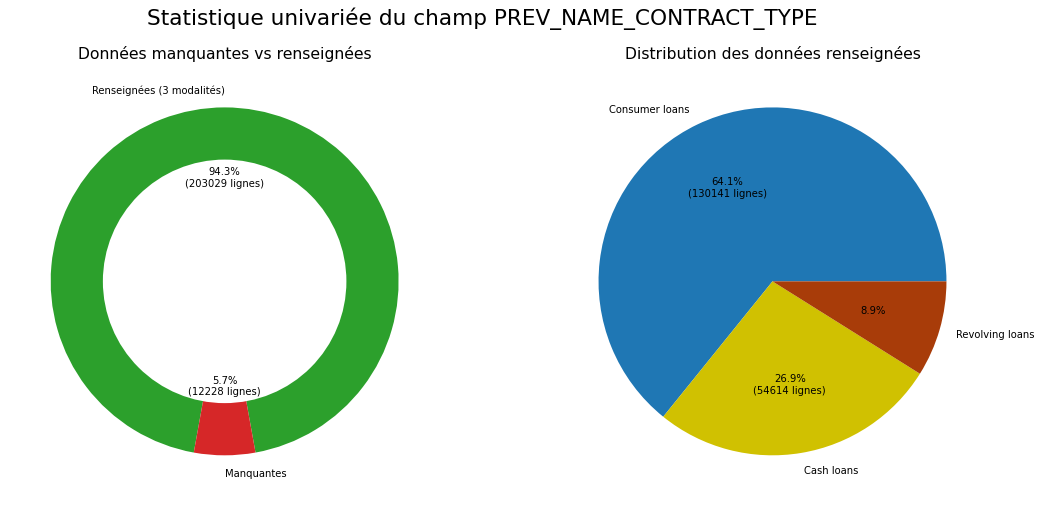

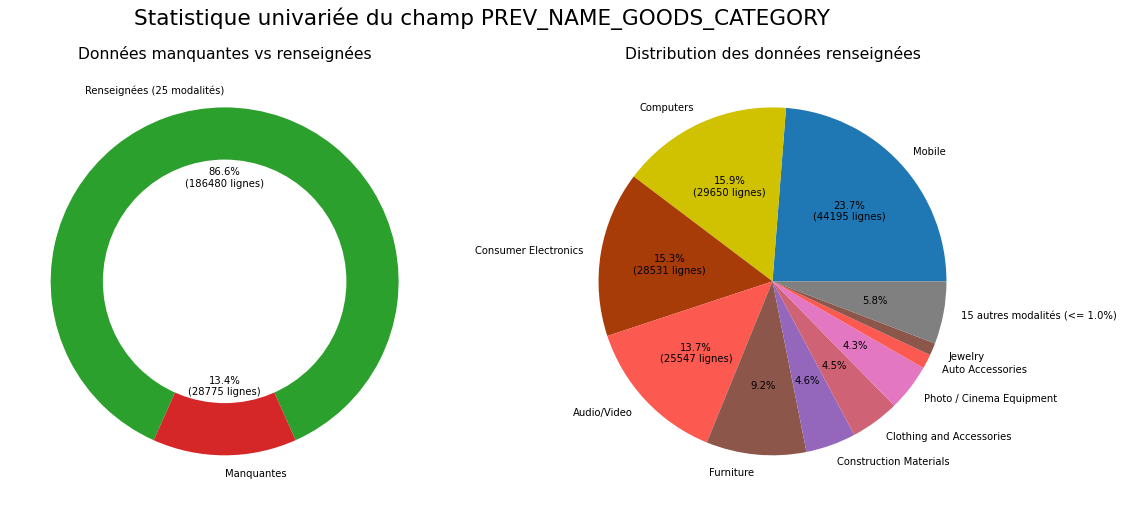

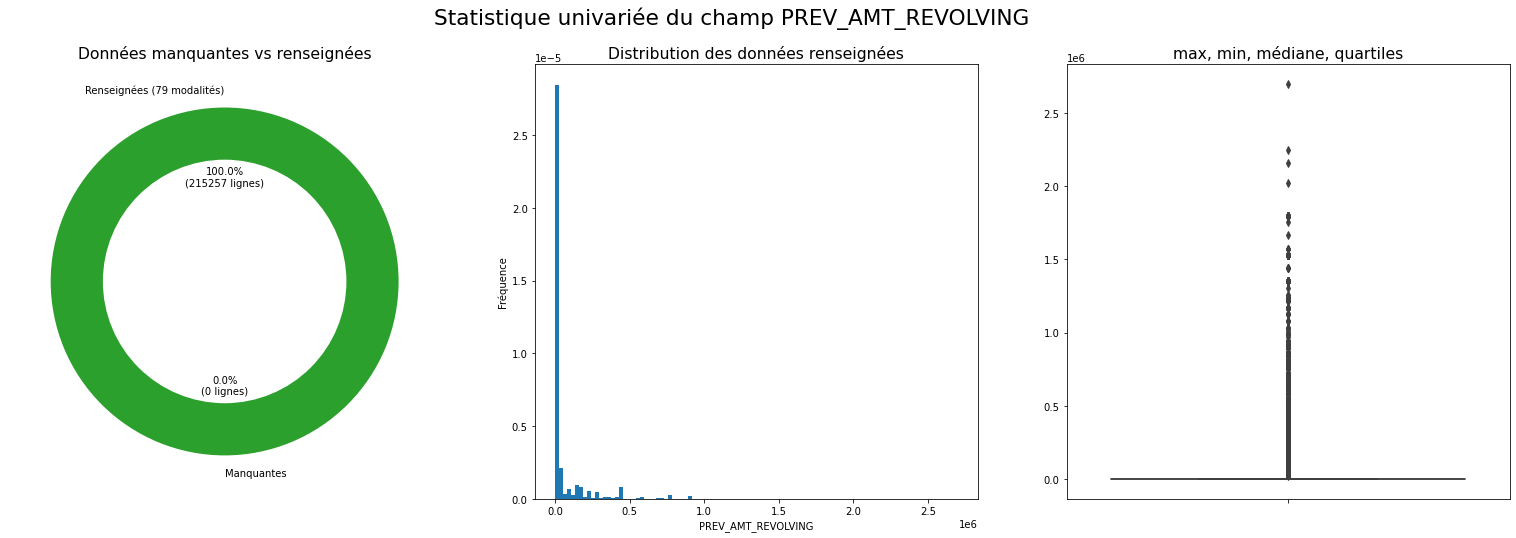

Mesures de position
 - Moyenne: 53134.21
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 143553.59
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 2700000.0
Mesures de forme
 - Skewness (asymétrie): 3.91
 - Kurtosis (applatissement): 19.18


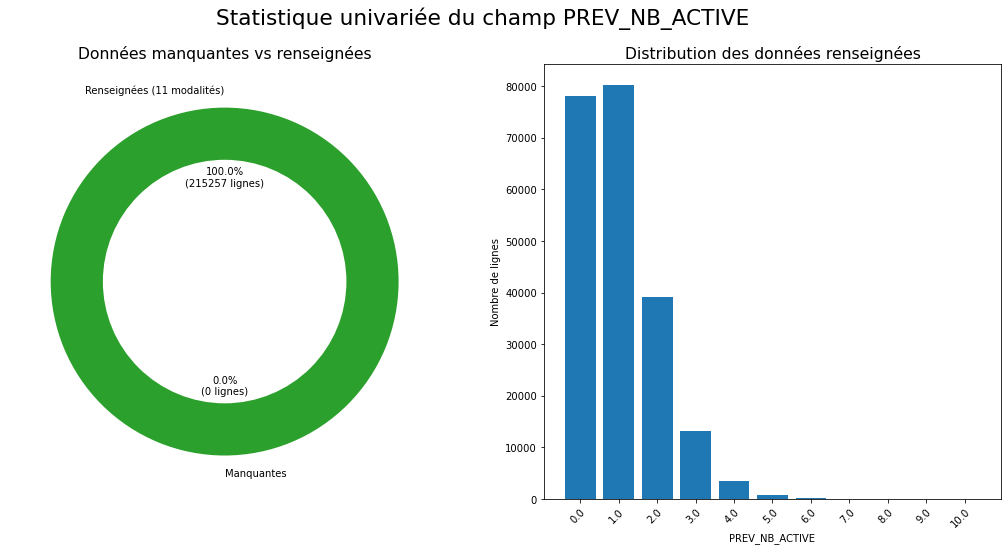

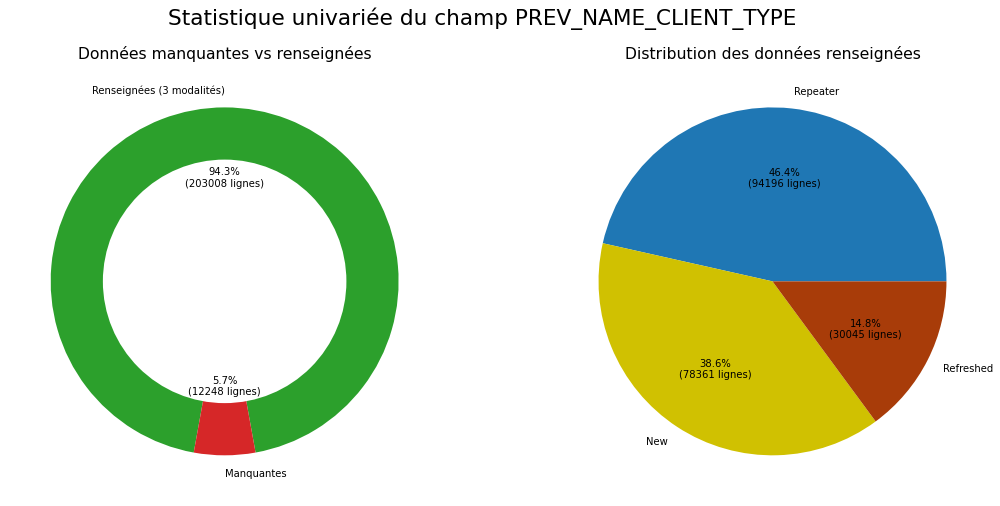

In [153]:
for col in categorical_col:
    myDf(dfApplication).Stat(col, statsNan=True)

In [154]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
statFeat[statFeat.nb_unique<100].sort_values('bestClassement')

feature  nb_unique  missing_prct  mini    q25  \
0                  ELEVATORS_MODE         26        53.245 0.000  0.000   
2         HOUR_APPR_PROCESS_START         24         0.000 0.000 10.000   
3   PREV_RATE_INTEREST_PRIVILEGED         39         0.000 0.000  0.000   
8                 FLAG_DOCUMENT_6          2         0.000 0.000  0.000   
15                FLAG_WORK_PHONE          2         0.000 0.000  0.000   
19               FLAG_DOCUMENT_10          2         0.000 0.000  0.000   
22    PREV_NFLAG_LAST_APPL_IN_DAY         84         0.000 0.000  1.000   
32             PREV_AMT_REVOLVING         79         0.000 0.000  0.000   
33                 PREV_NB_ACTIVE         11         0.000 0.000  0.000   

    median    q75        maxi      mean        std  skewness  kurtosis  \
0    0.000  0.121       1.000     0.074      0.132     2.530     8.400   
2   12.000 14.000      23.000    12.064      3.262    -0.029    -0.198   
3    0.000  0.000       1.000     0.012      0.095     8.159    65.381   
8    0.000  0.000       1.000     0.088      0.283     2.911     6.476   
15   0.000  0.000       1.000     0.199      0.400     1.504     0.263   
19   0.000  0.000       1.000     0.000      0.005   207.481 43046.400   
22   1.000  1.000       1.000     0.944      0.226    -3.920    13.458   
32   0.000  0.000 2700000.000 53134.209 143553.590     3.914    19.181   
33   1.000  2.000      10.000     1.011      1.014     1.091     1.544   

    cut_off_down  nb_outliers_down  cut_off_up  nb_outliers_up  \
0         -0.181                 0       0.302            6818   
2          4.000              1142      20.000             406   
3          0.000                 0       0.000            3233   
8          0.000                 0       0.000           18916   
15         0.000                 0       0.000           42930   
19         0.000                 0       0.000               5   
22         1.000             14341       1.000               0   
32         0.000                 0       0.000           49813   
33        -3.000                 0       5.000             237   

    bestClassement  RFClassement  XGClassement  
0                2             5             2  
2                3             8             3  
3                3             3             6  
8                9             9             9  
15              14            23            14  
19              17            20            17  
22              20            21            20  
32              30            38            30  
33              31            34            31

## Variables numériques

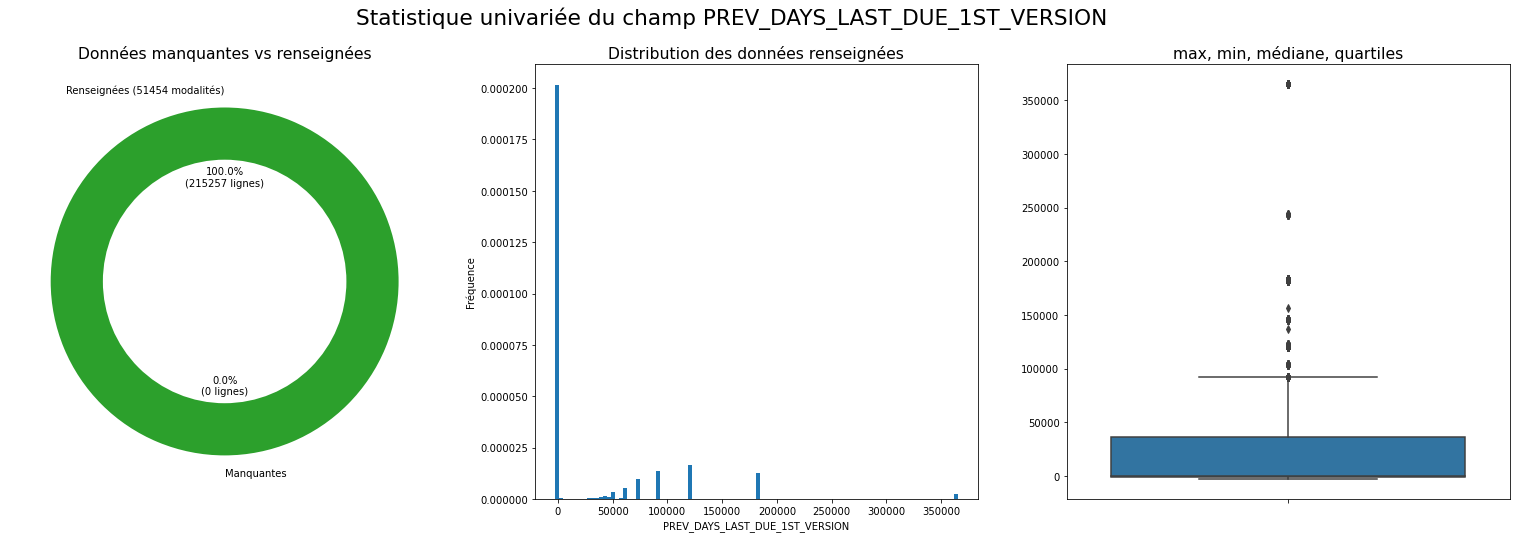

Mesures de position
 - Moyenne: 28762.2
 - Médiane: -148.25
Mesures de dispertion
 - Ecart type: 60088.42
 - Min: -2798.0
 - Q25: -755.14
 - Q75: 36316.8
 - Max: 365243.0
Mesures de forme
 - Skewness (asymétrie): 2.61
 - Kurtosis (applatissement): 8.51


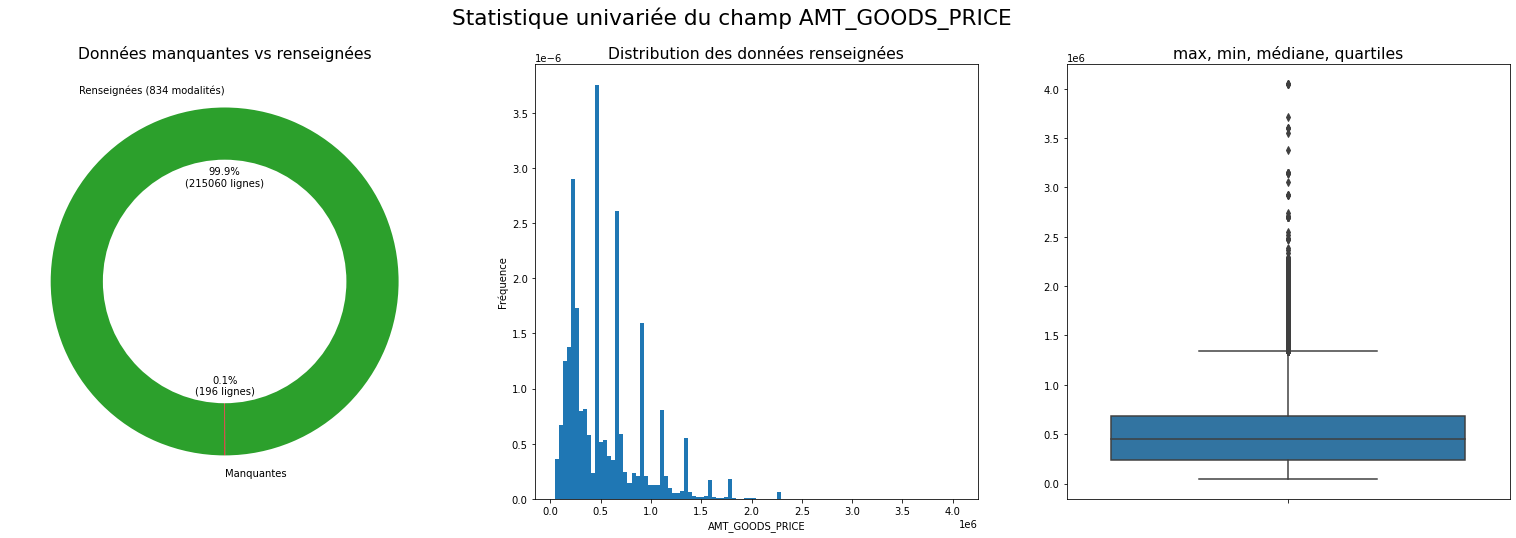

Mesures de position
 - Moyenne: 538187.97
 - Médiane: 450000.0
Mesures de dispertion
 - Ecart type: 369446.25
 - Min: 45000.0
 - Q25: 238500.0
 - Q75: 679500.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.35
 - Kurtosis (applatissement): 2.42


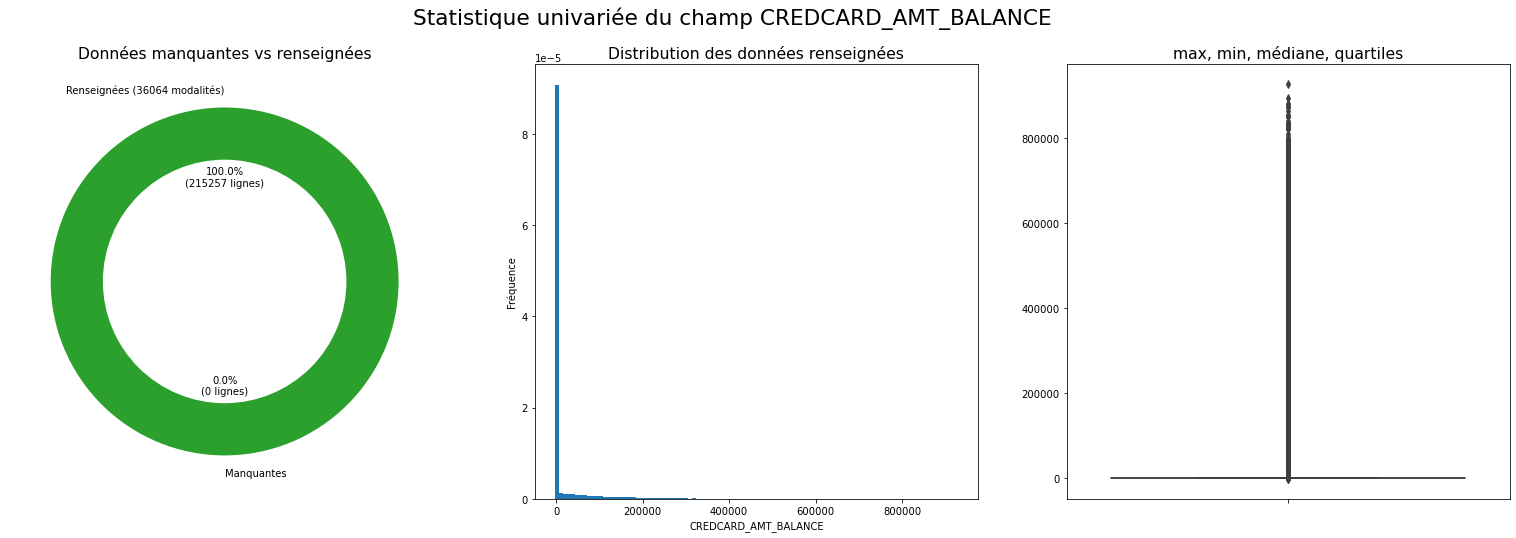

Mesures de position
 - Moyenne: 19030.1
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 65422.33
 - Min: -2625.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 928686.32
Mesures de forme
 - Skewness (asymétrie): 5.24
 - Kurtosis (applatissement): 35.16


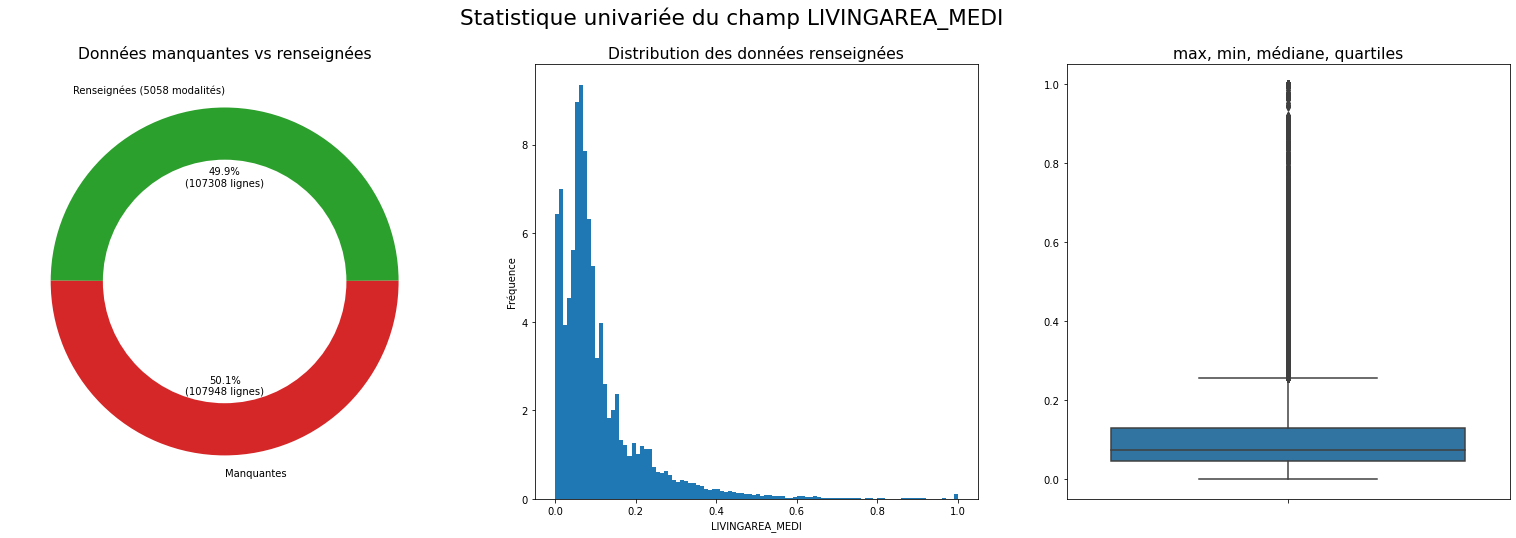

Mesures de position
 - Moyenne: 0.11
 - Médiane: 0.07
Mesures de dispertion
 - Ecart type: 0.11
 - Min: 0.0
 - Q25: 0.05
 - Q75: 0.13
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 2.85
 - Kurtosis (applatissement): 12.14


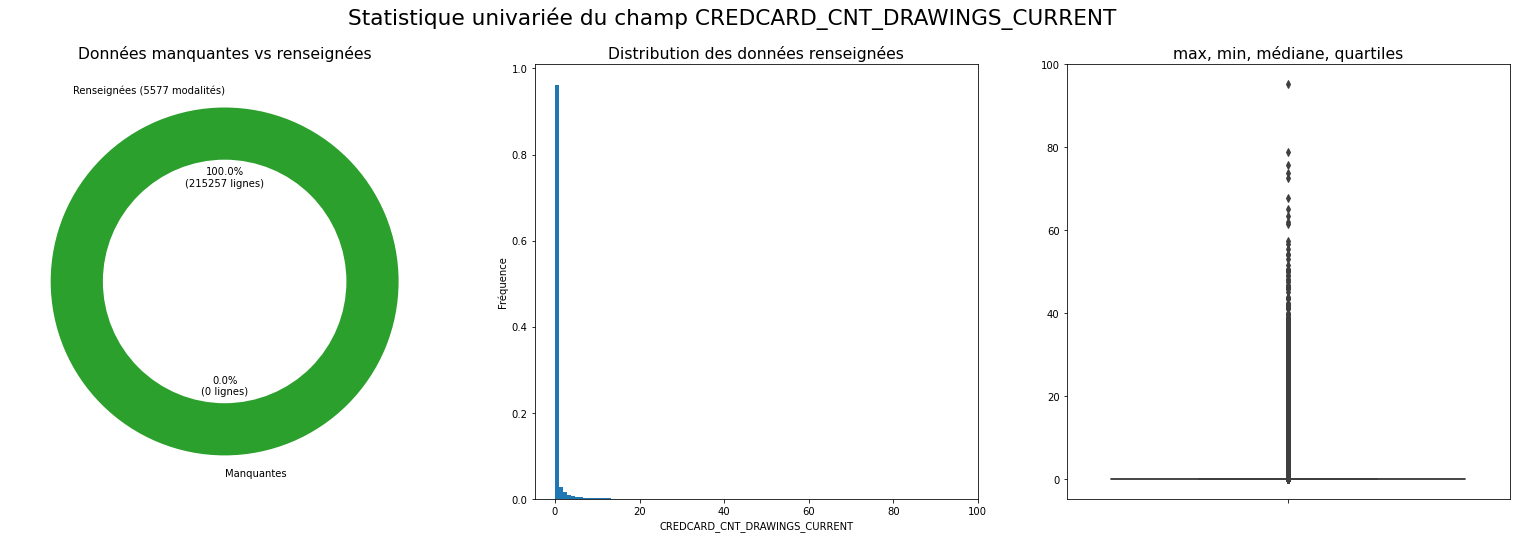

Mesures de position
 - Moyenne: 0.43
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 2.08
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 95.25
Mesures de forme
 - Skewness (asymétrie): 10.5
 - Kurtosis (applatissement): 183.34


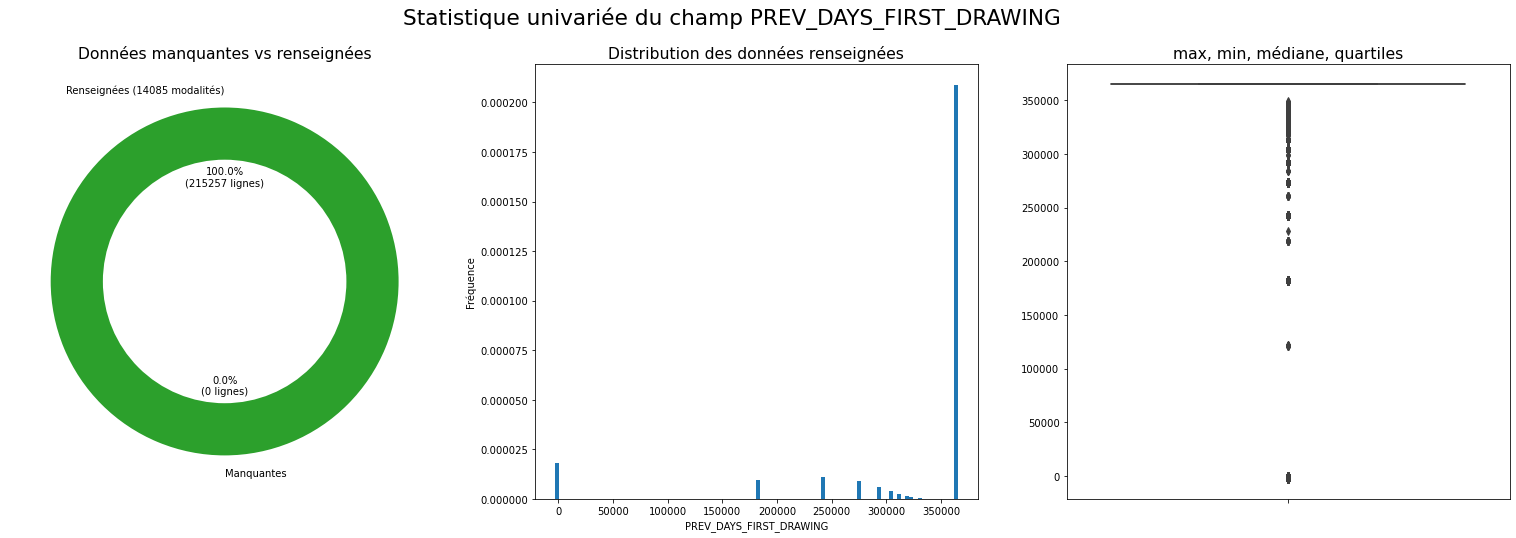

Mesures de position
 - Moyenne: 323268.26
 - Médiane: 365243.0
Mesures de dispertion
 - Ecart type: 96639.78
 - Min: -2922.0
 - Q25: 365243.0
 - Q75: 365243.0
 - Max: 365243.0
Mesures de forme
 - Skewness (asymétrie): -2.55
 - Kurtosis (applatissement): 5.5


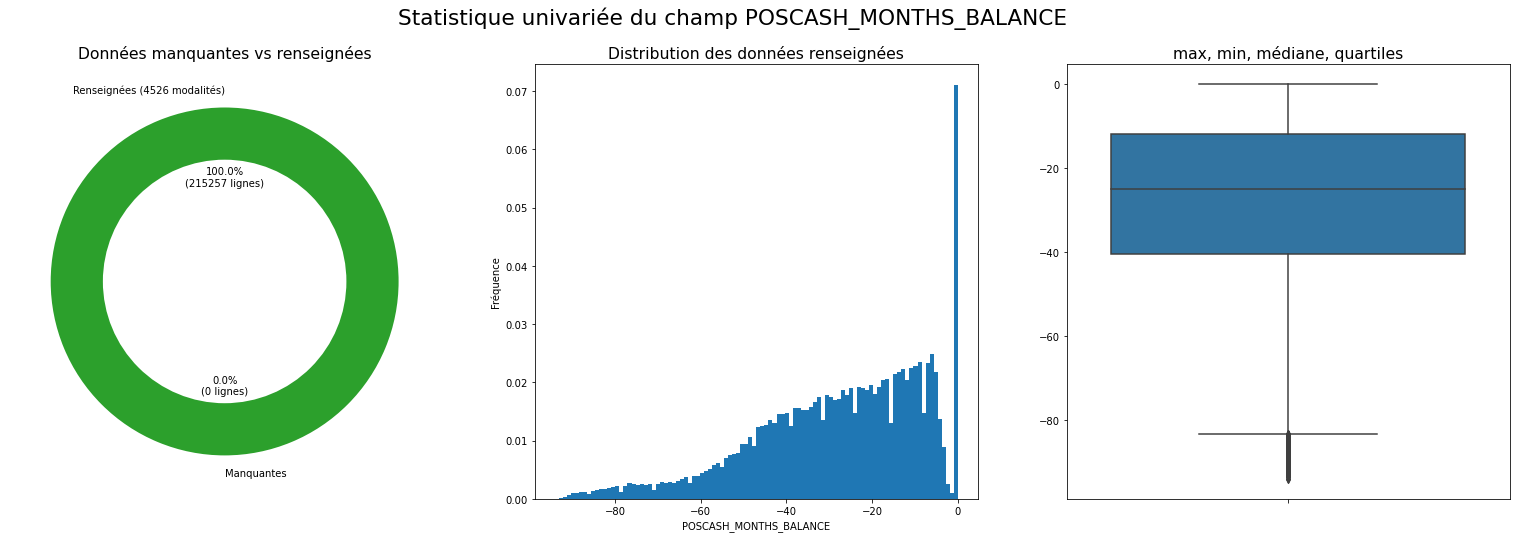

Mesures de position
 - Moyenne: -27.85
 - Médiane: -25.0
Mesures de dispertion
 - Ecart type: 19.68
 - Min: -94.0
 - Q25: -40.5
 - Q75: -12.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.71
 - Kurtosis (applatissement): 0.06


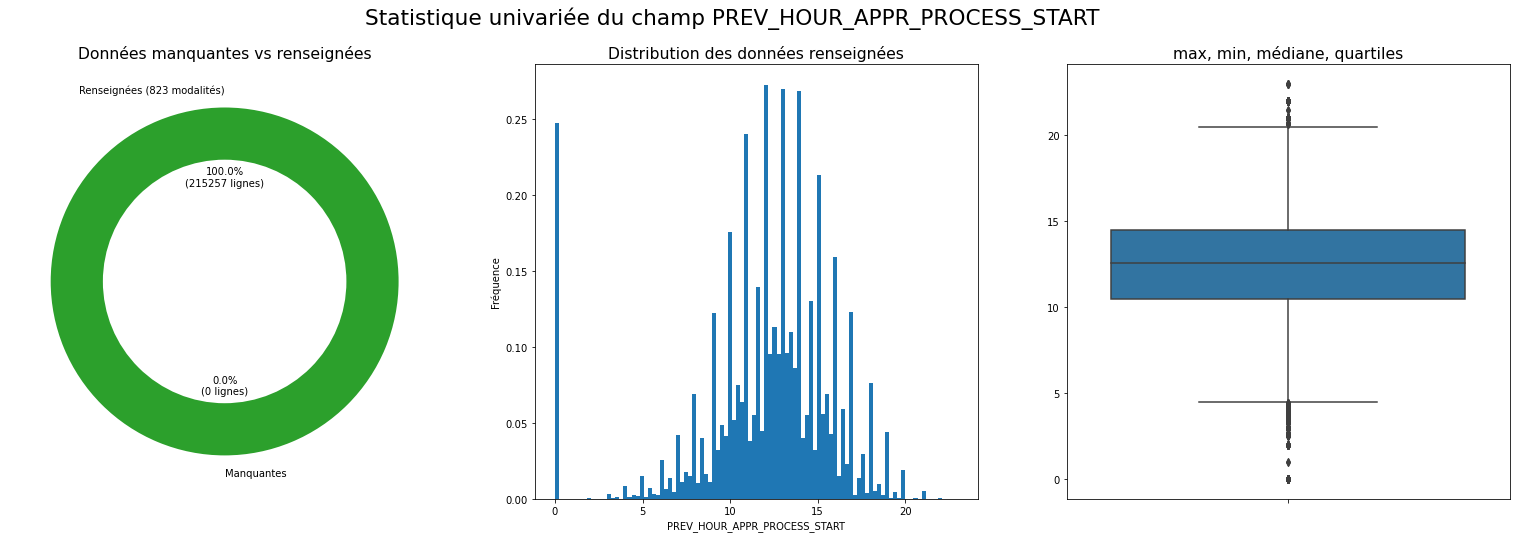

Mesures de position
 - Moyenne: 12.02
 - Médiane: 12.6
Mesures de dispertion
 - Ecart type: 4.06
 - Min: 0.0
 - Q25: 10.5
 - Q75: 14.5
 - Max: 23.0
Mesures de forme
 - Skewness (asymétrie): -1.27
 - Kurtosis (applatissement): 2.17


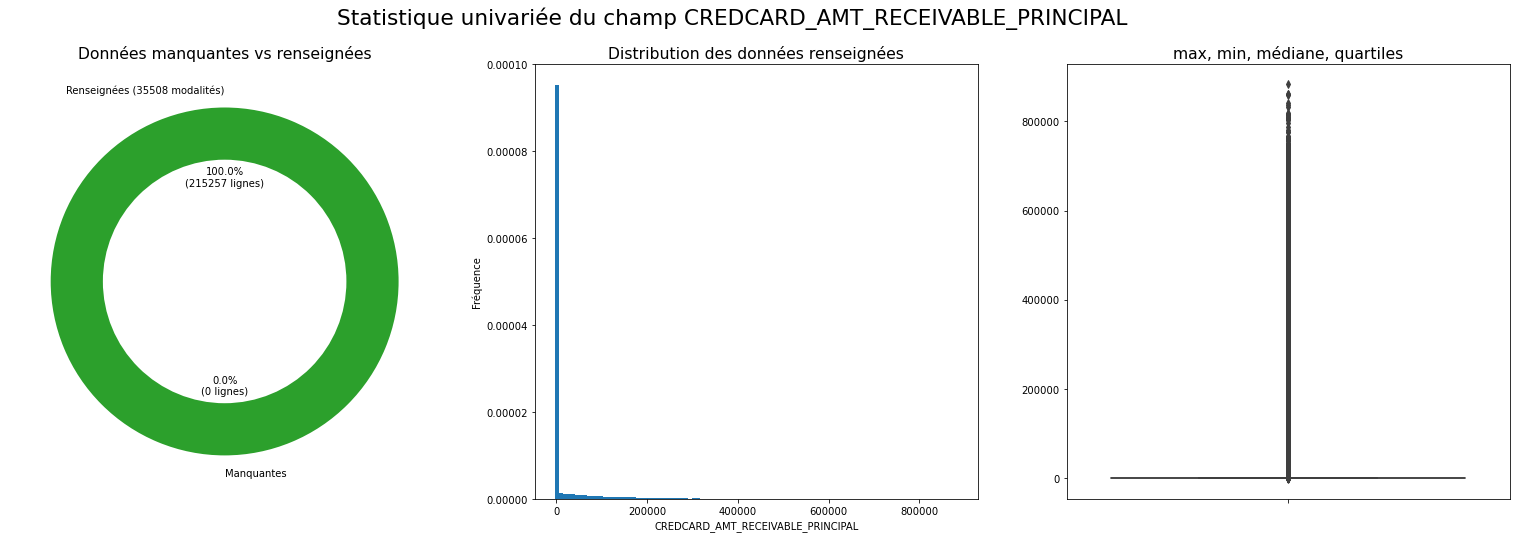

Mesures de position
 - Moyenne: 18312.7
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 63115.18
 - Min: -2625.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 884547.88
Mesures de forme
 - Skewness (asymétrie): 5.27
 - Kurtosis (applatissement): 35.49


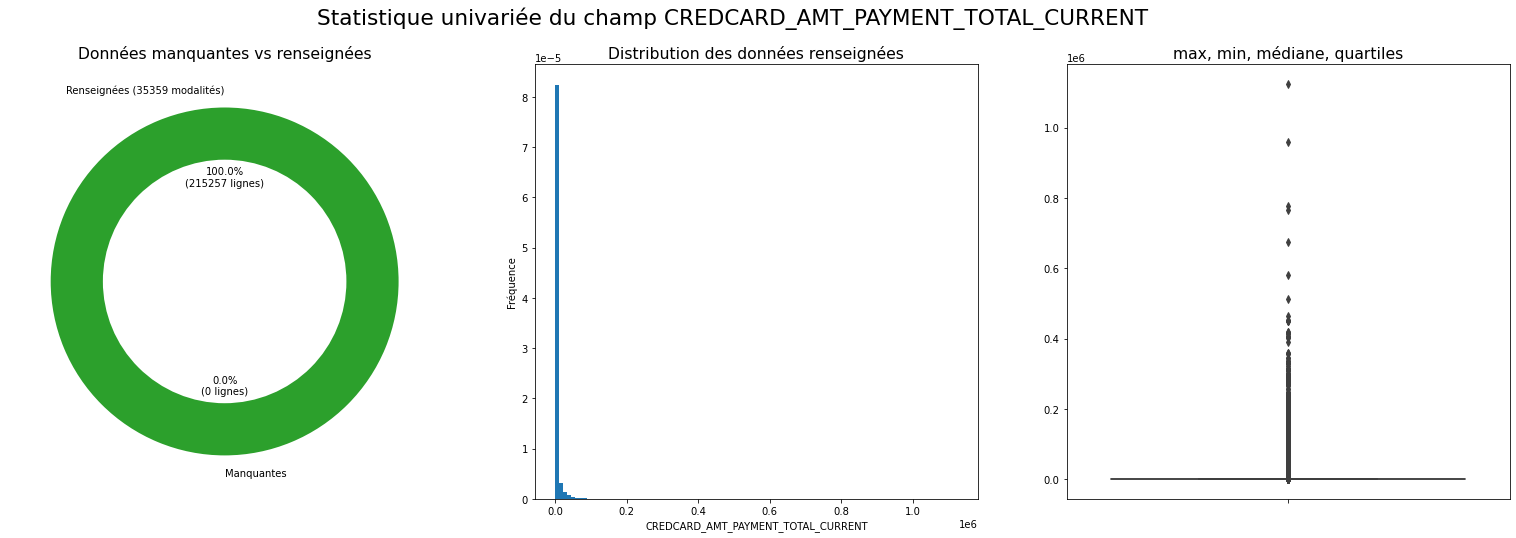

Mesures de position
 - Moyenne: 2834.94
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 12659.84
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1125000.0
Mesures de forme
 - Skewness (asymétrie): 18.31
 - Kurtosis (applatissement): 819.84


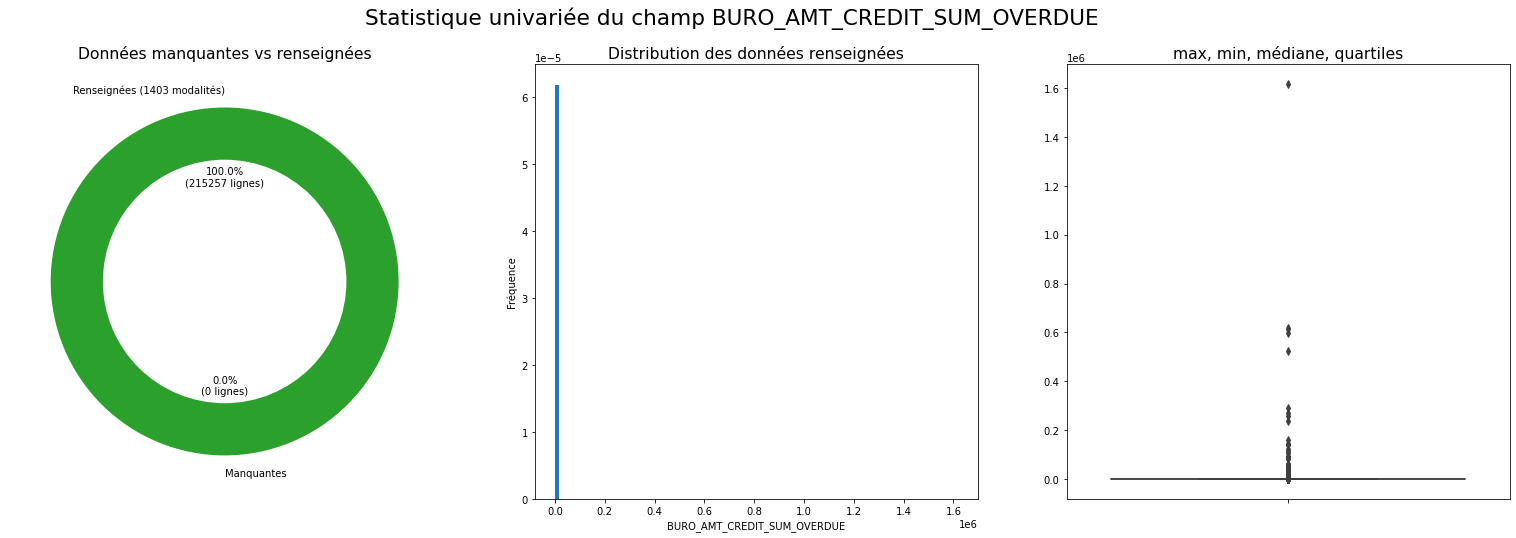

Mesures de position
 - Moyenne: 41.13
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 4570.79
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1617403.5
Mesures de forme
 - Skewness (asymétrie): 250.57
 - Kurtosis (applatissement): 78272.65


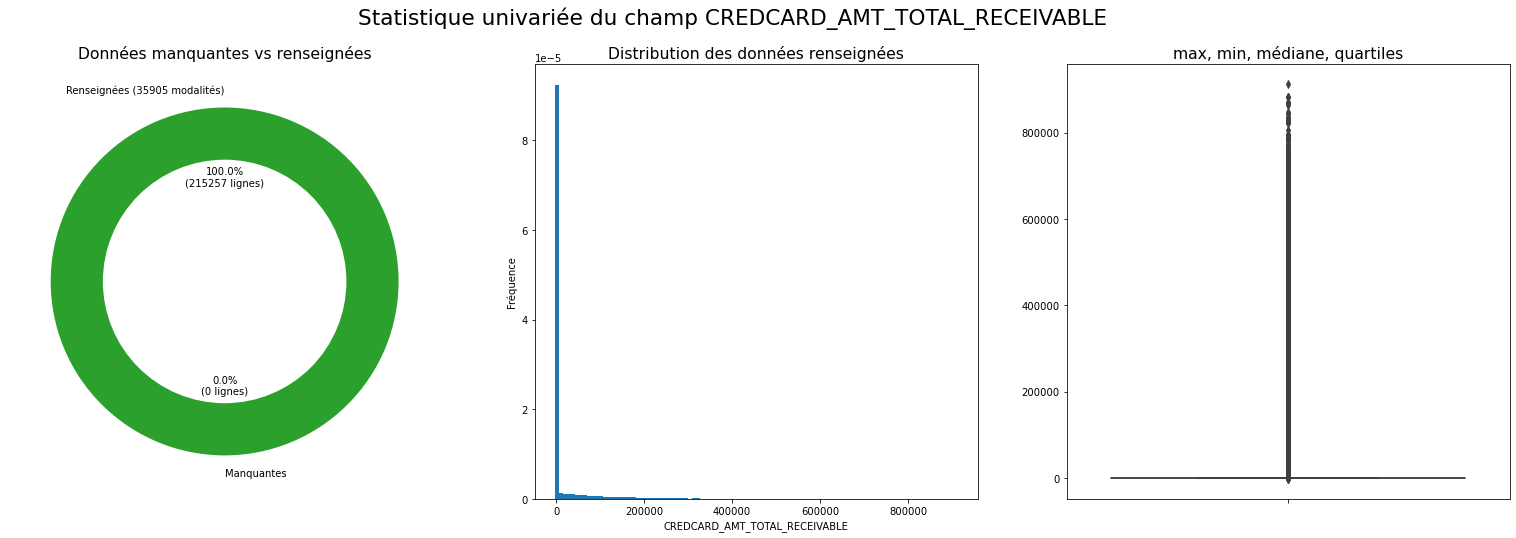

Mesures de position
 - Moyenne: 18895.08
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 65024.88
 - Min: -2625.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 913096.64
Mesures de forme
 - Skewness (asymétrie): 5.25
 - Kurtosis (applatissement): 35.24


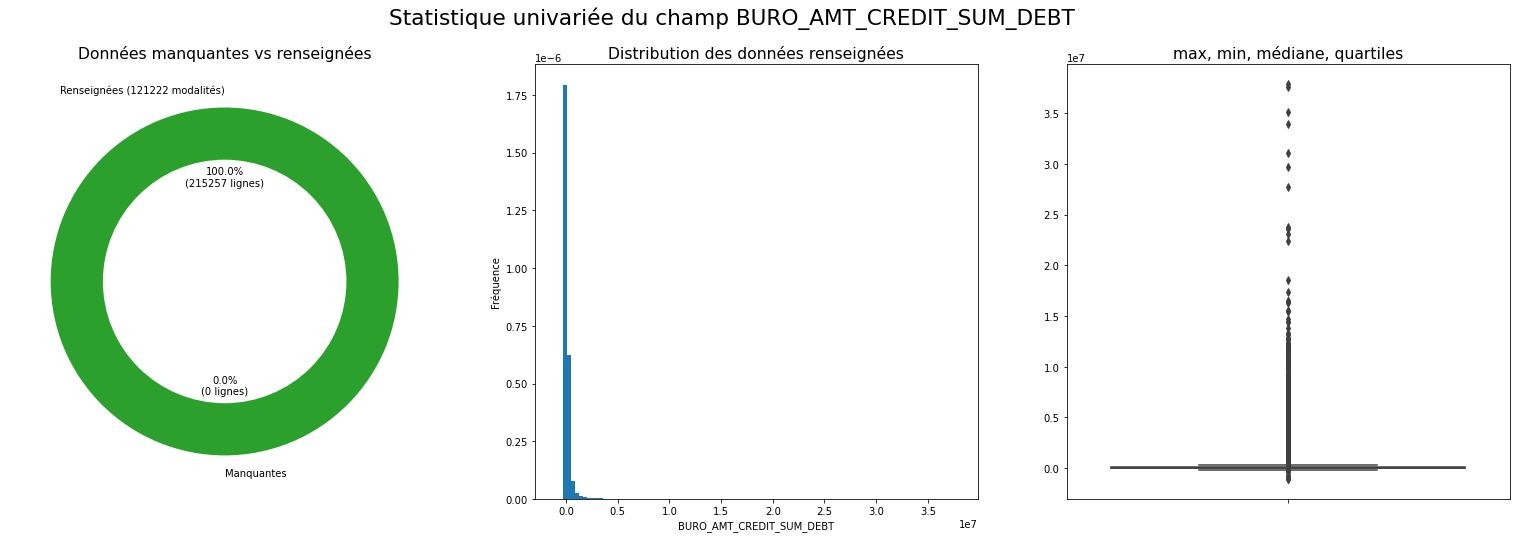

Mesures de position
 - Moyenne: 133311.43
 - Médiane: 22309.2
Mesures de dispertion
 - Ecart type: 490854.27
 - Min: -1083614.67
 - Q25: 0.0
 - Q75: 112641.75
 - Max: 37904382.0
Mesures de forme
 - Skewness (asymétrie): 21.76
 - Kurtosis (applatissement): 993.55


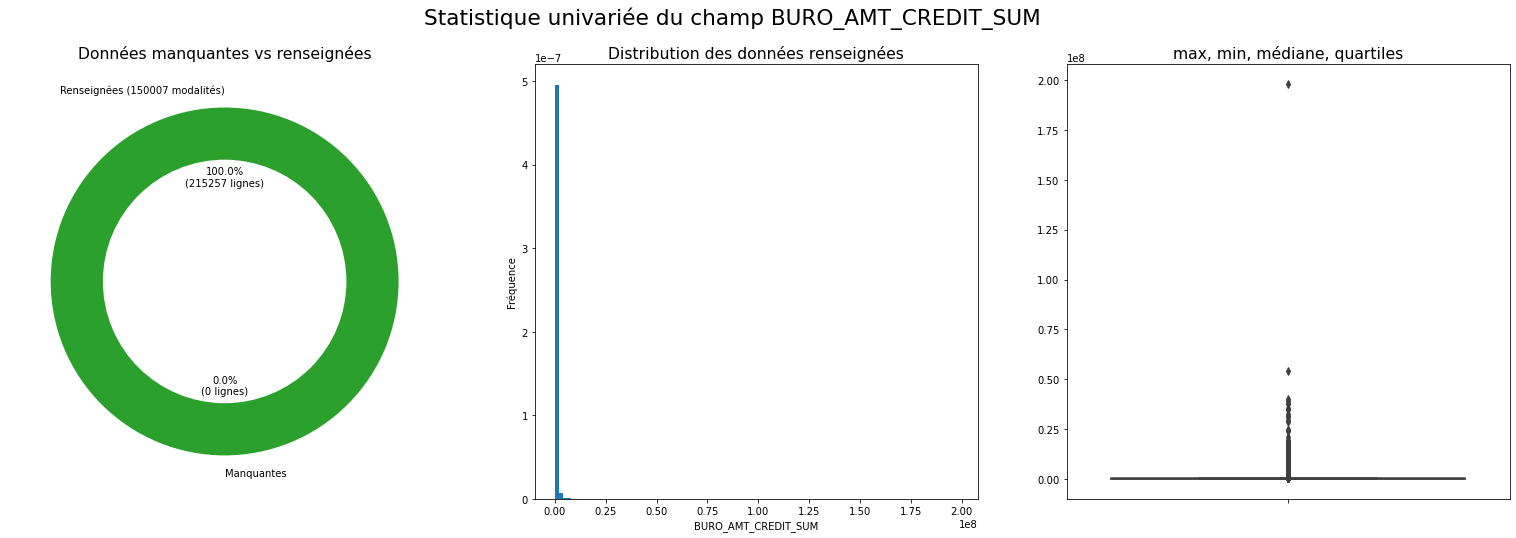

Mesures de position
 - Moyenne: 322531.91
 - Médiane: 158490.0
Mesures de dispertion
 - Ecart type: 818018.07
 - Min: 0.0
 - Q25: 67099.72
 - Q75: 344009.64
 - Max: 198072344.25
Mesures de forme
 - Skewness (asymétrie): 75.87
 - Kurtosis (applatissement): 16198.97


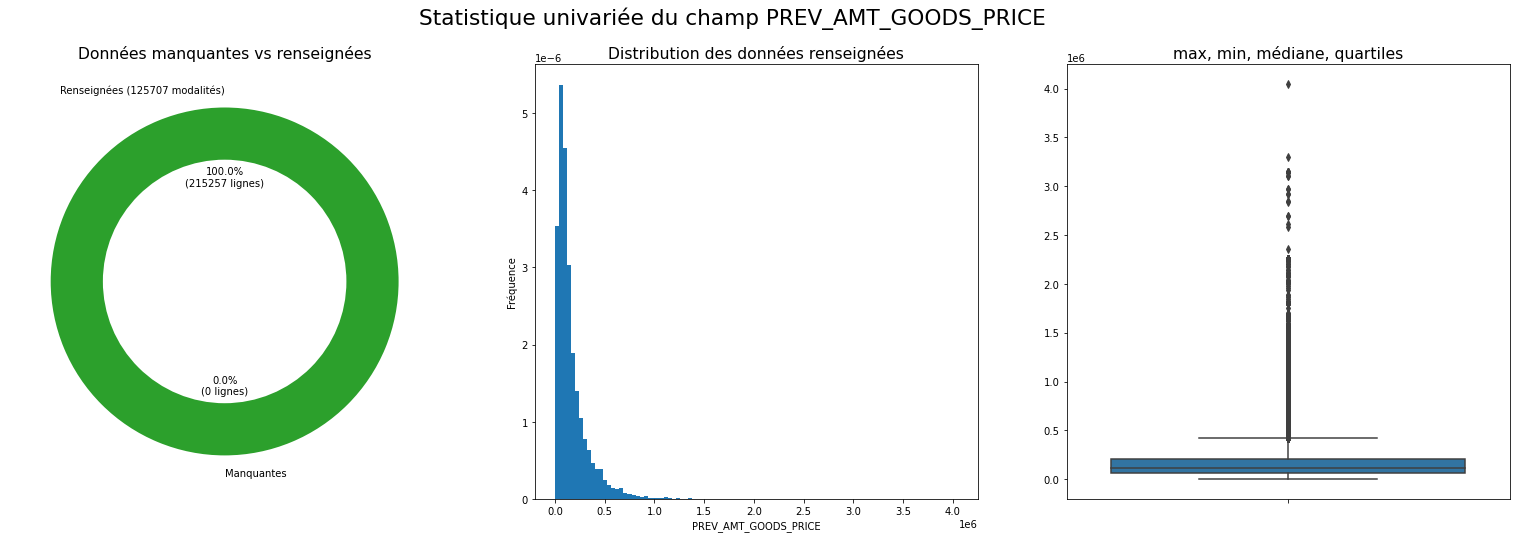

Mesures de position
 - Moyenne: 162859.89
 - Médiane: 110241.0
Mesures de dispertion
 - Ecart type: 170523.19
 - Min: 0.0
 - Q25: 60833.25
 - Q75: 206170.5
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 3.31
 - Kurtosis (applatissement): 23.57


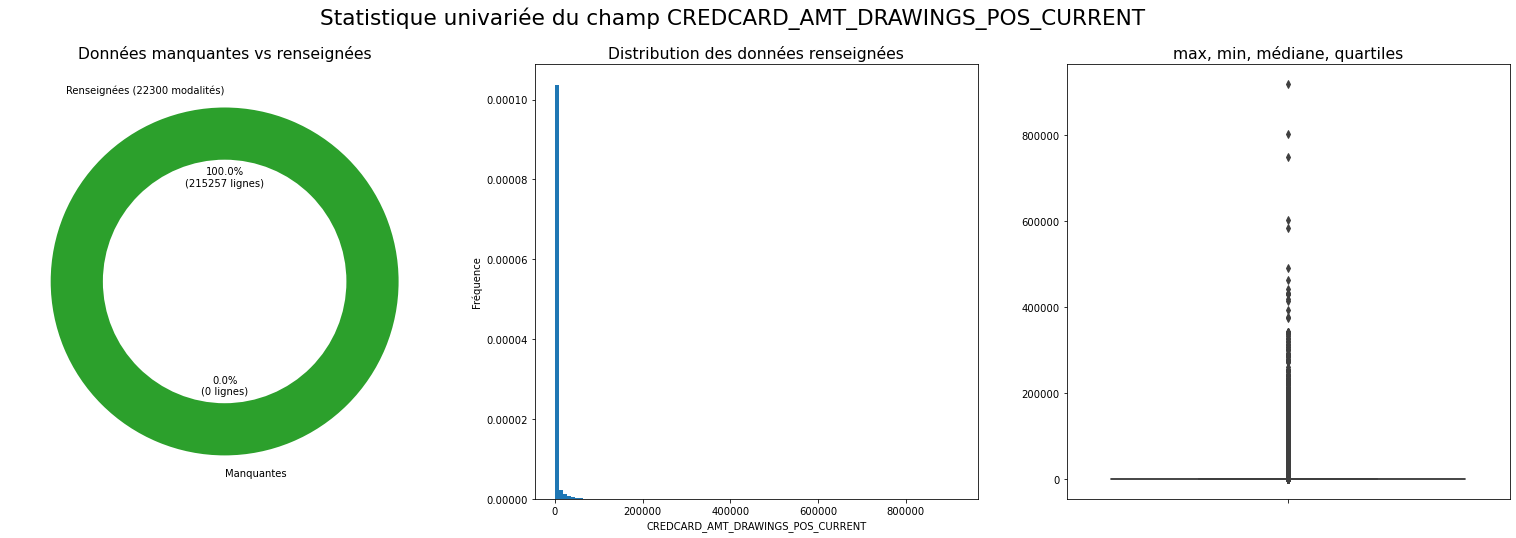

Mesures de position
 - Moyenne: 1648.29
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 10466.18
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 918645.46
Mesures de forme
 - Skewness (asymétrie): 22.02
 - Kurtosis (applatissement): 991.94


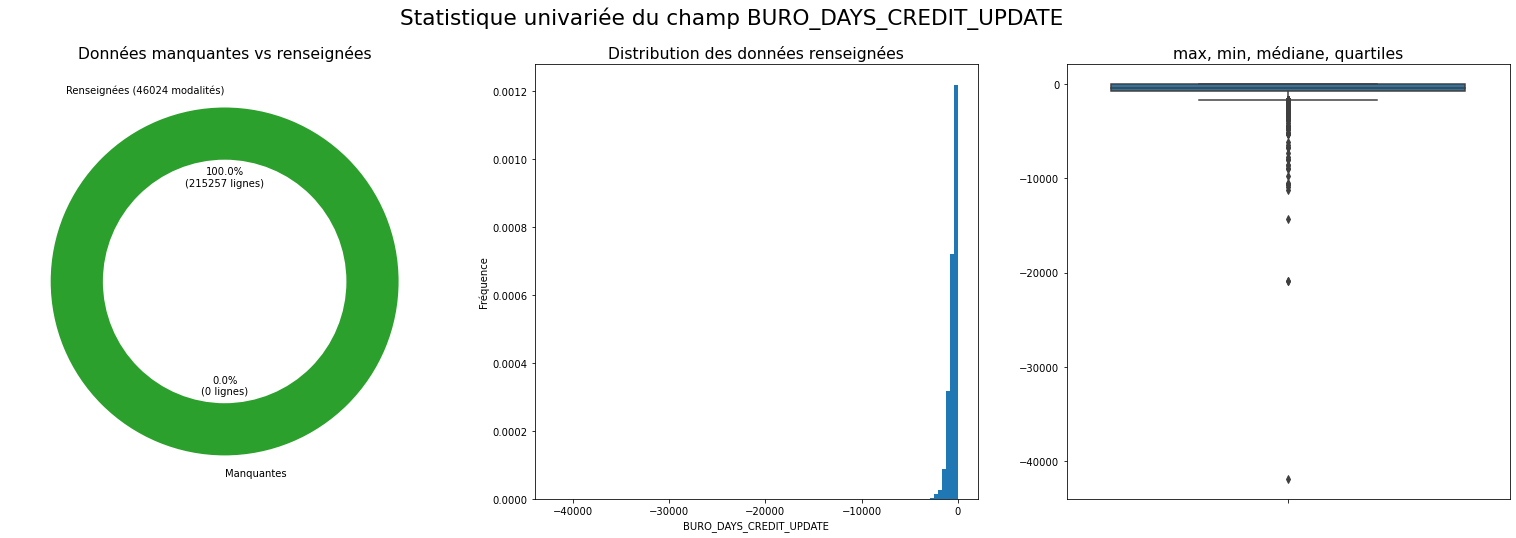

Mesures de position
 - Moyenne: -467.76
 - Médiane: -392.0
Mesures de dispertion
 - Ecart type: 465.53
 - Min: -41890.0
 - Q25: -720.12
 - Q75: -57.17
 - Max: 14.0
Mesures de forme
 - Skewness (asymétrie): -5.81
 - Kurtosis (applatissement): 341.35


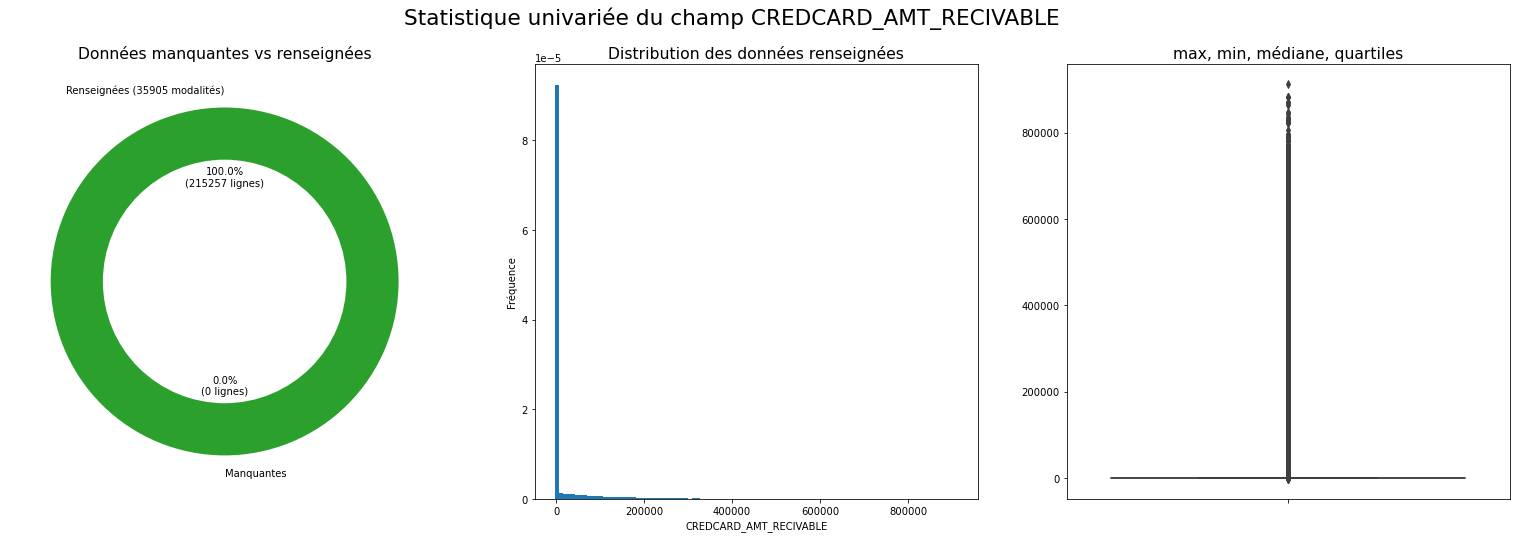

Mesures de position
 - Moyenne: 18894.85
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 65024.6
 - Min: -2625.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 913096.64
Mesures de forme
 - Skewness (asymétrie): 5.25
 - Kurtosis (applatissement): 35.24


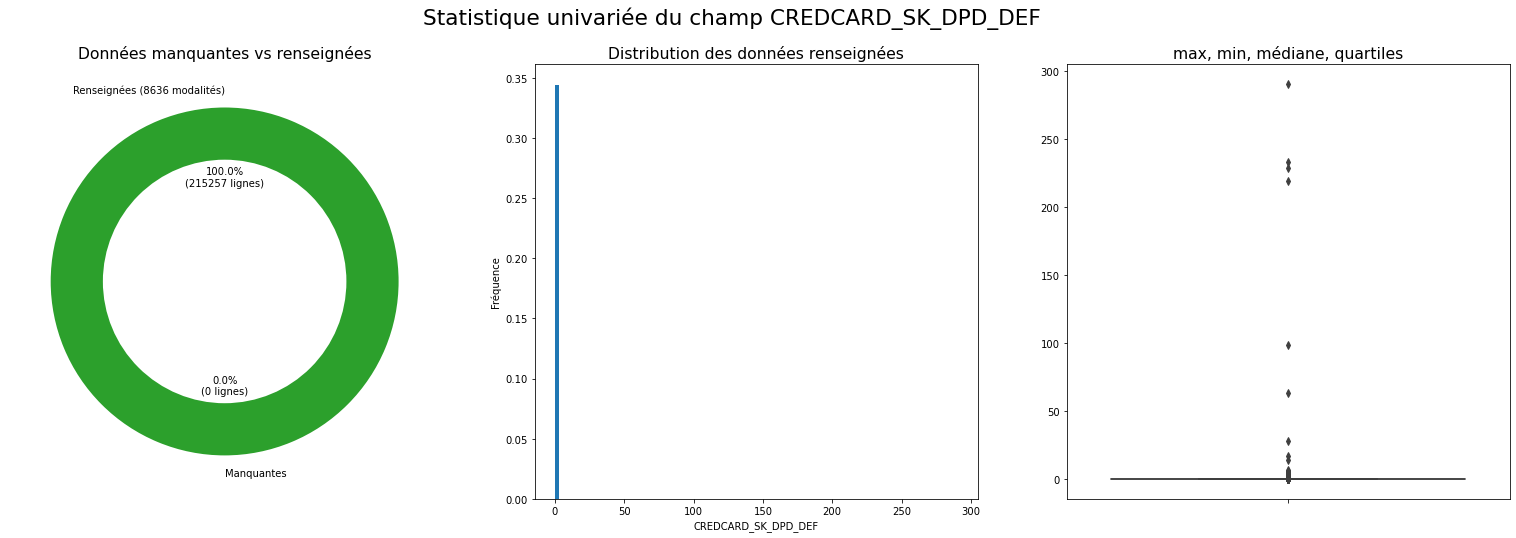

Mesures de position
 - Moyenne: 0.01
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 1.09
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 290.52
Mesures de forme
 - Skewness (asymétrie): 220.35
 - Kurtosis (applatissement): 50683.17


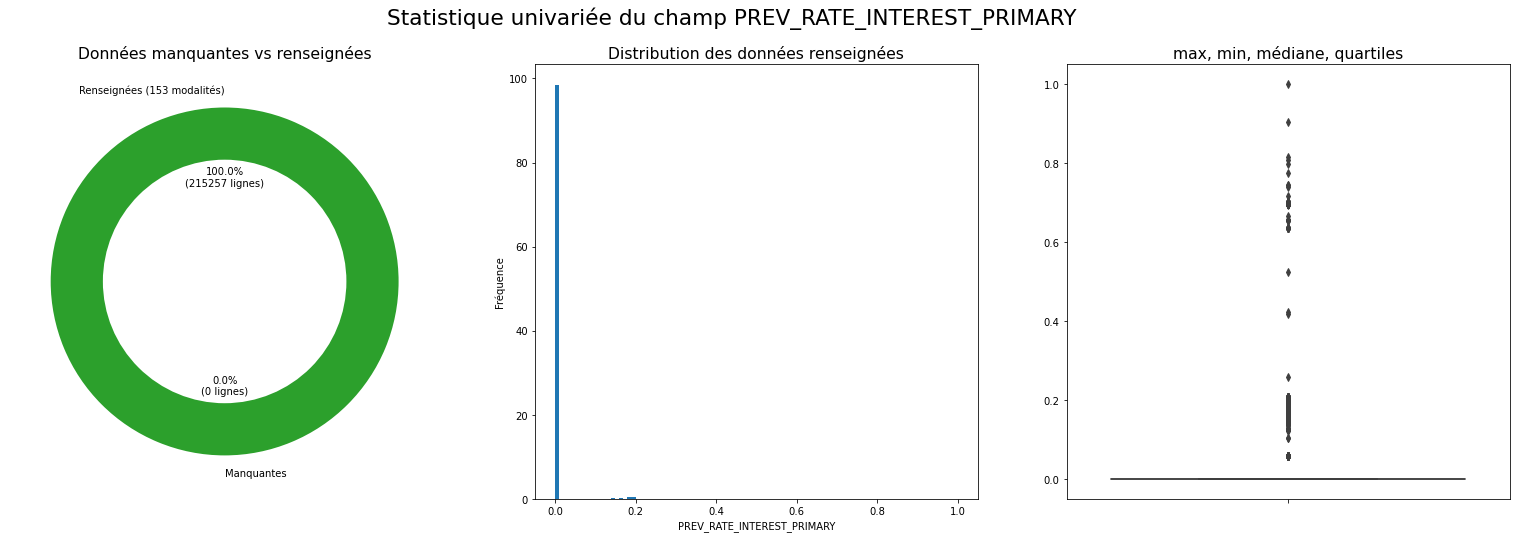

Mesures de position
 - Moyenne: 0.0
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.03
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1.0
Mesures de forme
 - Skewness (asymétrie): 13.23
 - Kurtosis (applatissement): 267.2


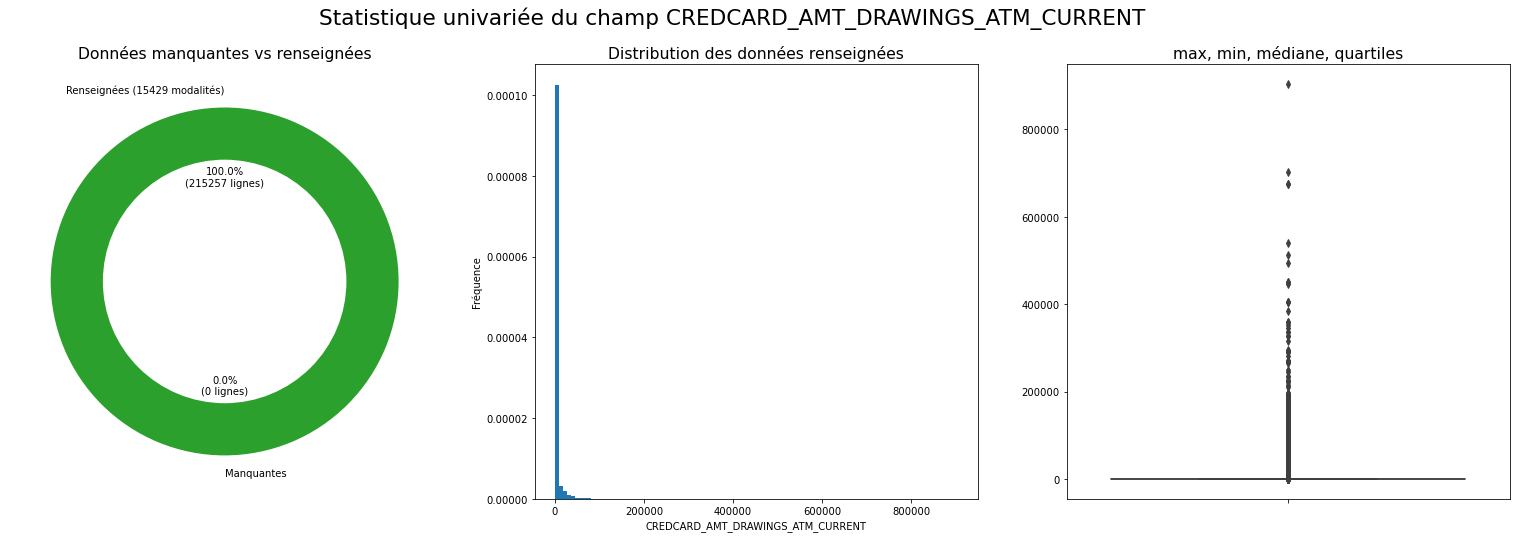

Mesures de position
 - Moyenne: 2390.33
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 11104.17
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 904500.0
Mesures de forme
 - Skewness (asymétrie): 16.22
 - Kurtosis (applatissement): 644.36


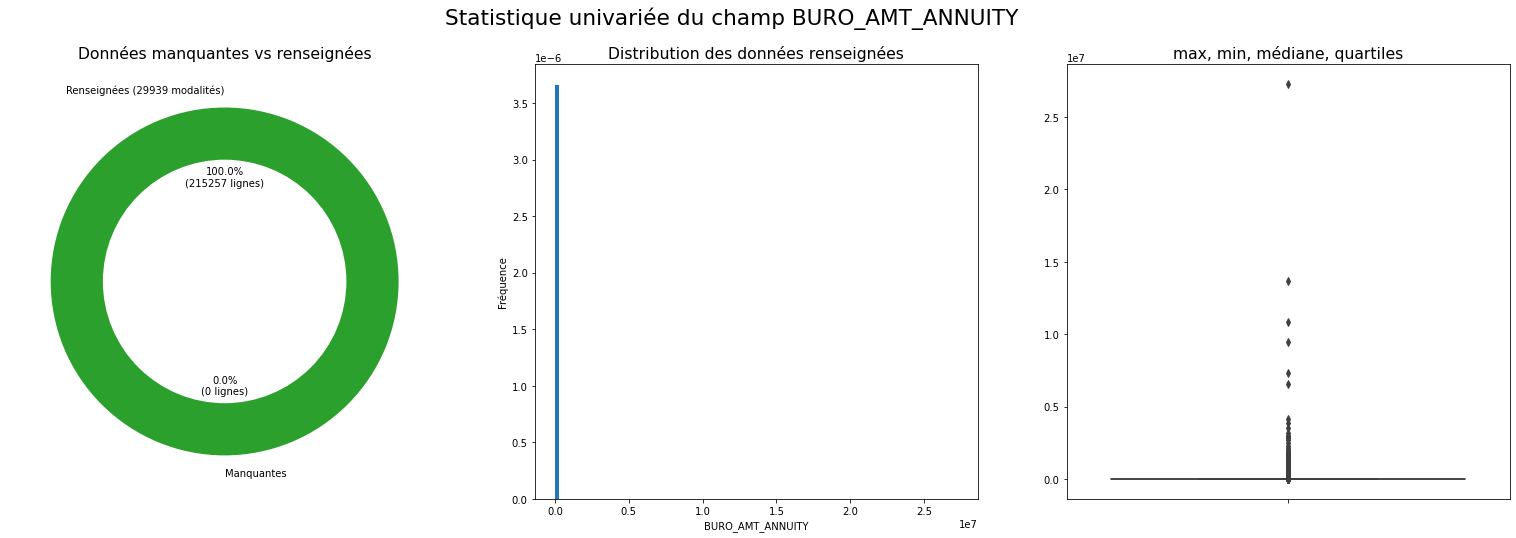

Mesures de position
 - Moyenne: 4098.31
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 82235.98
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 27282428.75
Mesures de forme
 - Skewness (asymétrie): 218.17
 - Kurtosis (applatissement): 62660.42


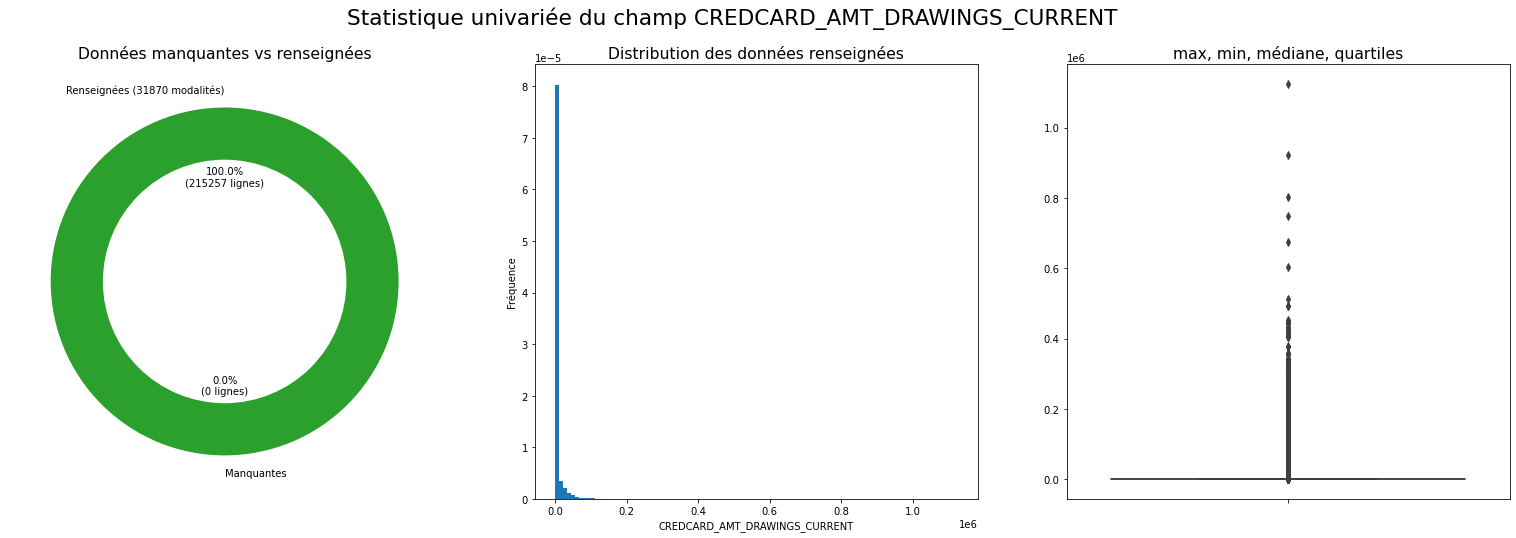

Mesures de position
 - Moyenne: 3874.26
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 15591.32
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 1125000.0
Mesures de forme
 - Skewness (asymétrie): 12.45
 - Kurtosis (applatissement): 387.0


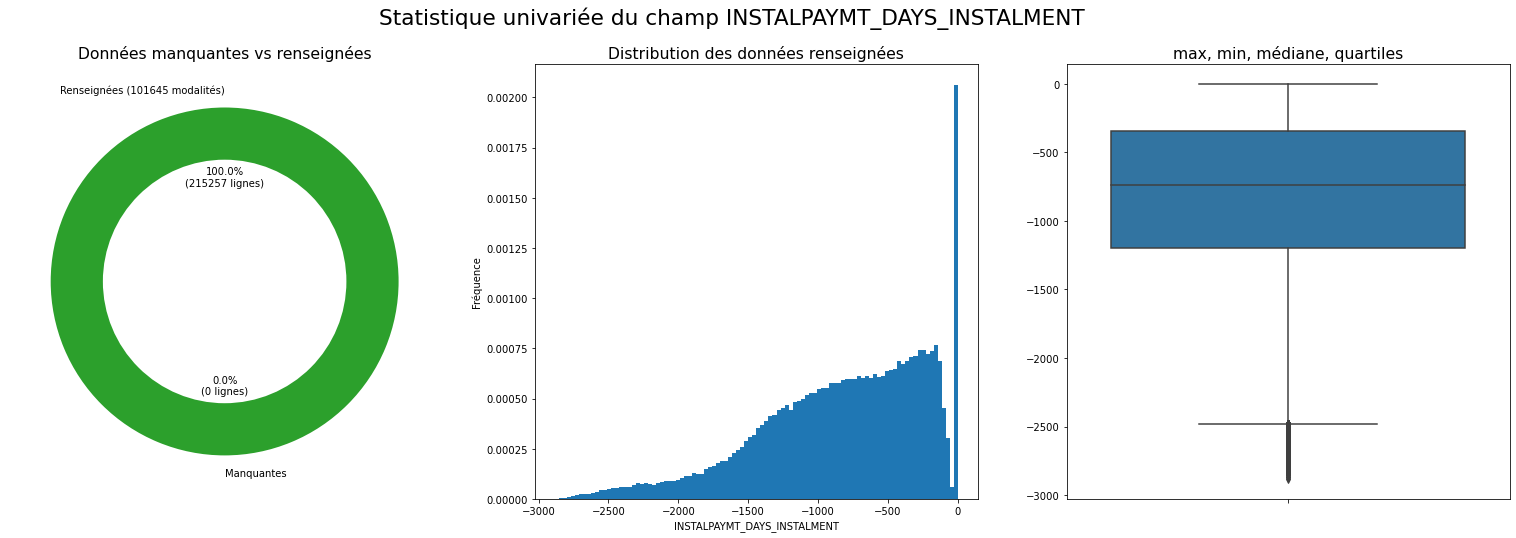

Mesures de position
 - Moyenne: -823.63
 - Médiane: -740.0
Mesures de dispertion
 - Ecart type: 587.33
 - Min: -2883.0
 - Q25: -1198.85
 - Q75: -345.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.73
 - Kurtosis (applatissement): 0.07


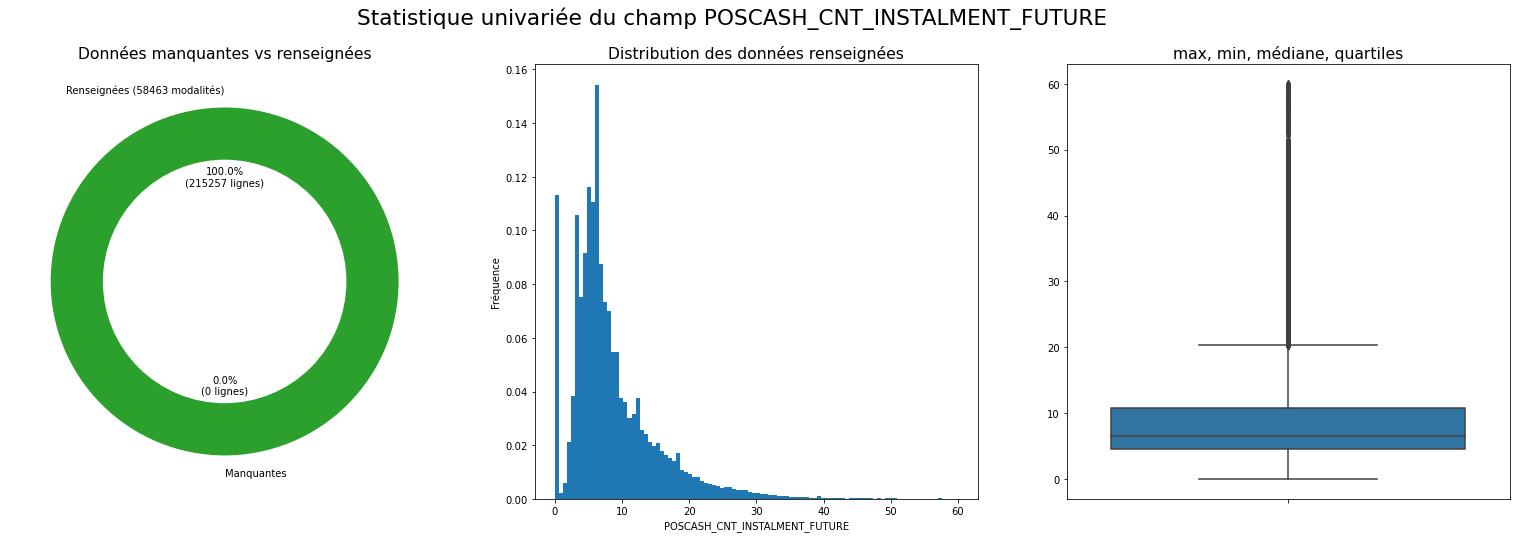

Mesures de position
 - Moyenne: 8.48
 - Médiane: 6.59
Mesures de dispertion
 - Ecart type: 6.56
 - Min: 0.0
 - Q25: 4.55
 - Q75: 10.85
 - Max: 60.0
Mesures de forme
 - Skewness (asymétrie): 1.88
 - Kurtosis (applatissement): 5.61


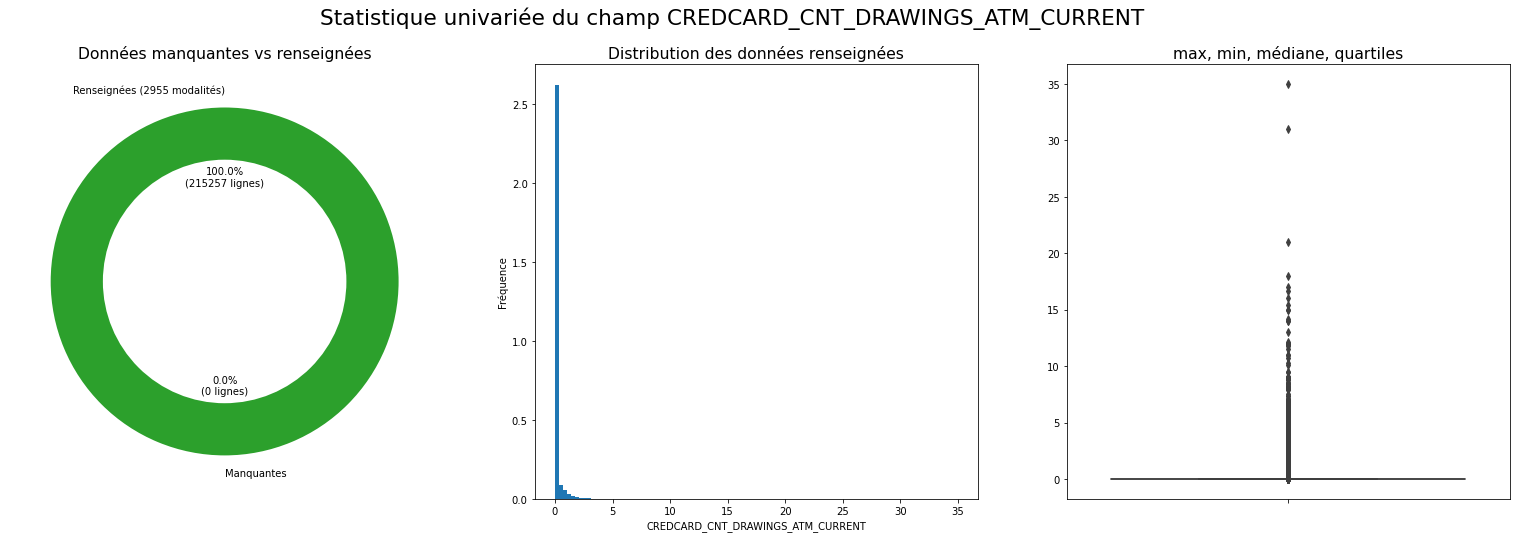

Mesures de position
 - Moyenne: 0.11
 - Médiane: 0.0
Mesures de dispertion
 - Ecart type: 0.46
 - Min: 0.0
 - Q25: 0.0
 - Q75: 0.0
 - Max: 35.0
Mesures de forme
 - Skewness (asymétrie): 12.22
 - Kurtosis (applatissement): 414.11


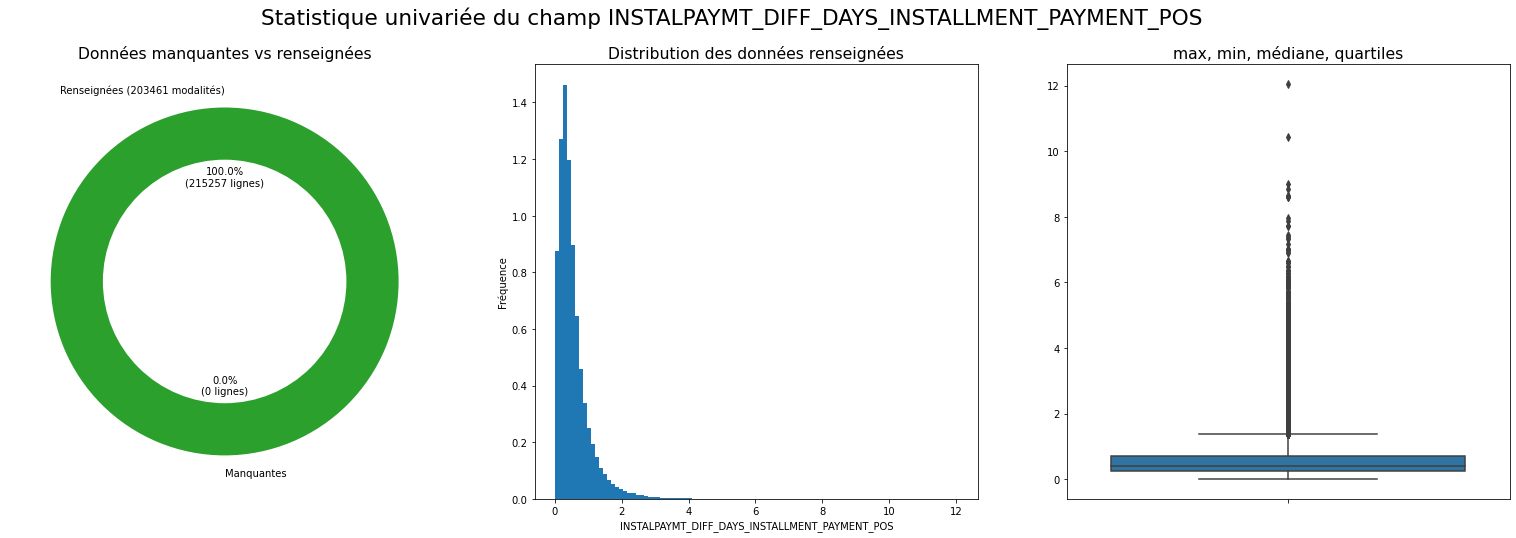

Mesures de position
 - Moyenne: 0.55
 - Médiane: 0.41
Mesures de dispertion
 - Ecart type: 0.51
 - Min: 0.0
 - Q25: 0.24
 - Q75: 0.7
 - Max: 12.05
Mesures de forme
 - Skewness (asymétrie): 2.98
 - Kurtosis (applatissement): 18.14


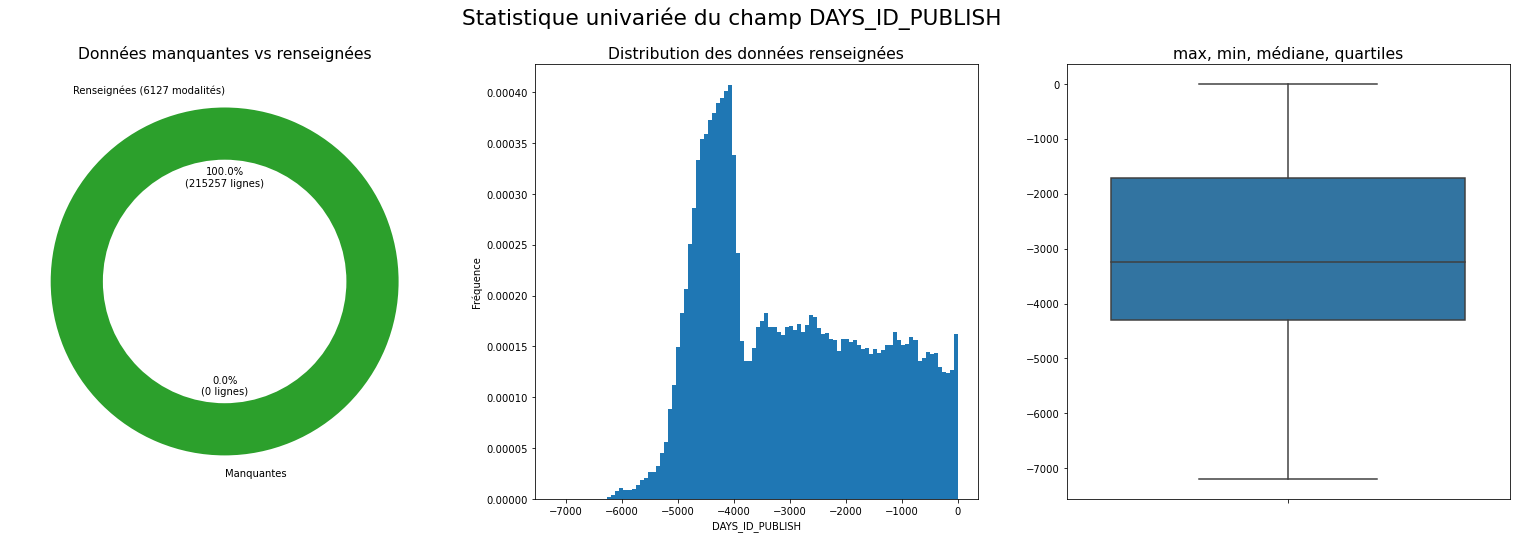

Mesures de position
 - Moyenne: -2993.0
 - Médiane: -3252.0
Mesures de dispertion
 - Ecart type: 1509.6
 - Min: -7197
 - Q25: -4298.0
 - Q75: -1720.0
 - Max: 0
Mesures de forme
 - Skewness (asymétrie): 0.35
 - Kurtosis (applatissement): -1.11


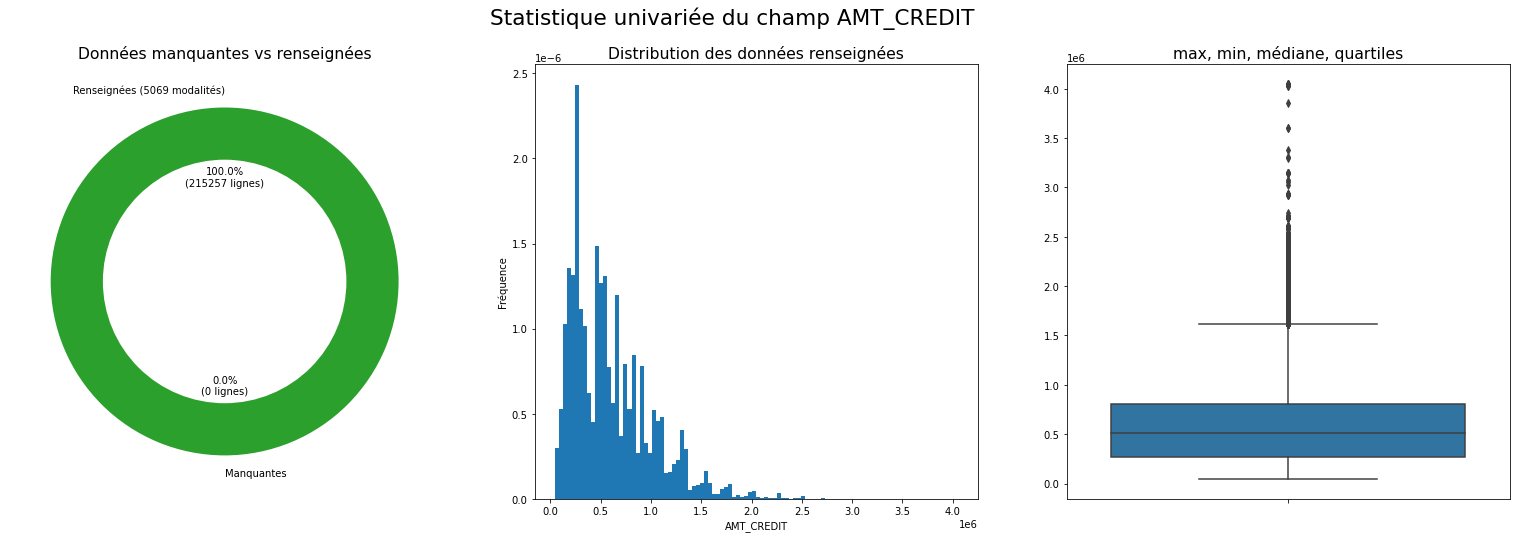

Mesures de position
 - Moyenne: 598734.88
 - Médiane: 513531.0
Mesures de dispertion
 - Ecart type: 402435.05
 - Min: 45000.0
 - Q25: 270000.0
 - Q75: 808650.0
 - Max: 4050000.0
Mesures de forme
 - Skewness (asymétrie): 1.24
 - Kurtosis (applatissement): 1.94


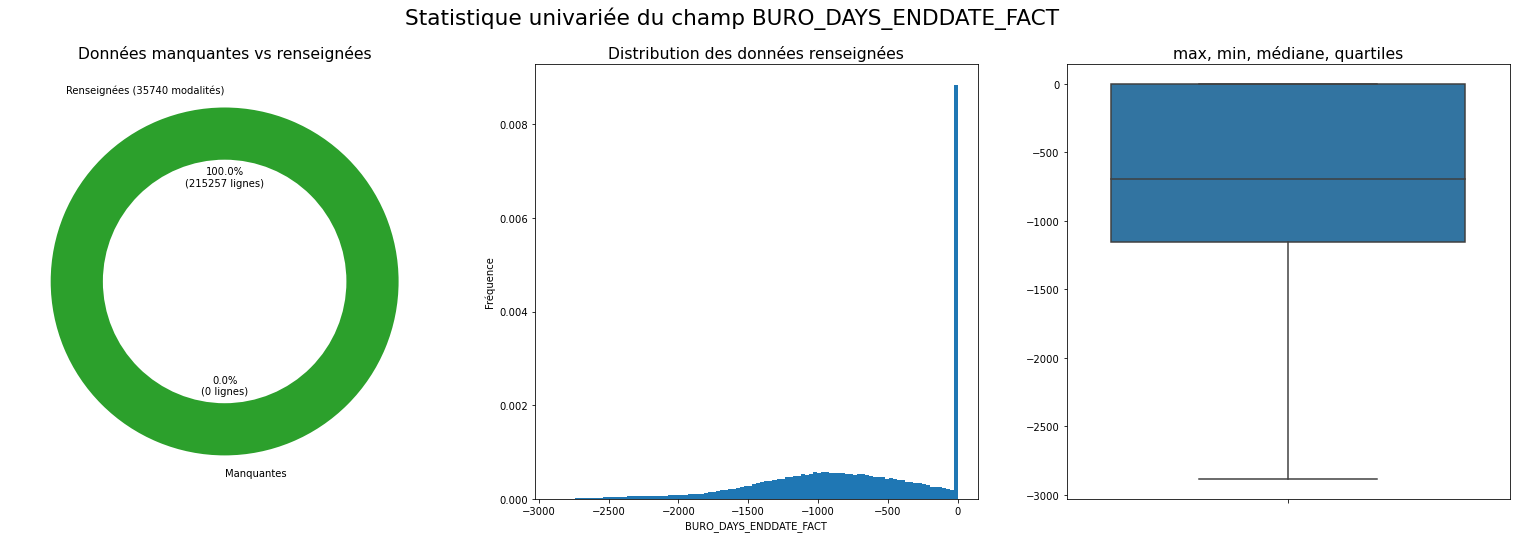

Mesures de position
 - Moyenne: -726.02
 - Médiane: -696.33
Mesures de dispertion
 - Ecart type: 625.84
 - Min: -2884.0
 - Q25: -1156.71
 - Q75: 0.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.56
 - Kurtosis (applatissement): -0.37


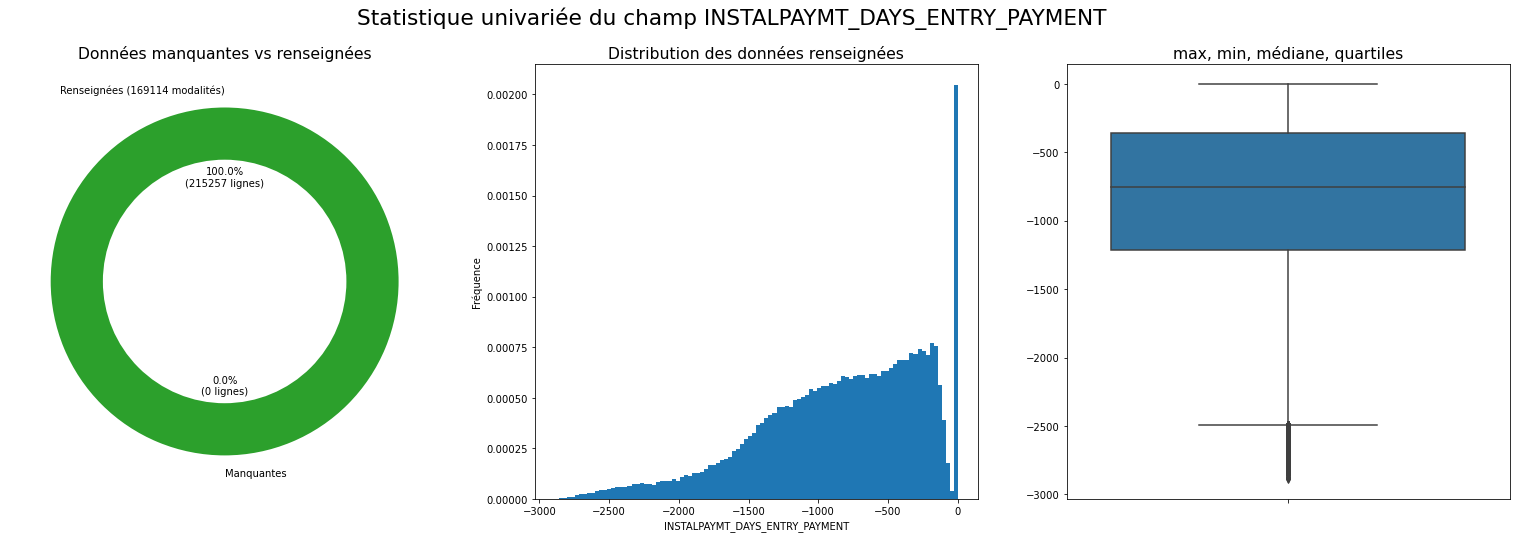

Mesures de position
 - Moyenne: -835.26
 - Médiane: -752.53
Mesures de dispertion
 - Ecart type: 587.46
 - Min: -2888.0
 - Q25: -1210.67
 - Q75: -358.36
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.72
 - Kurtosis (applatissement): 0.07


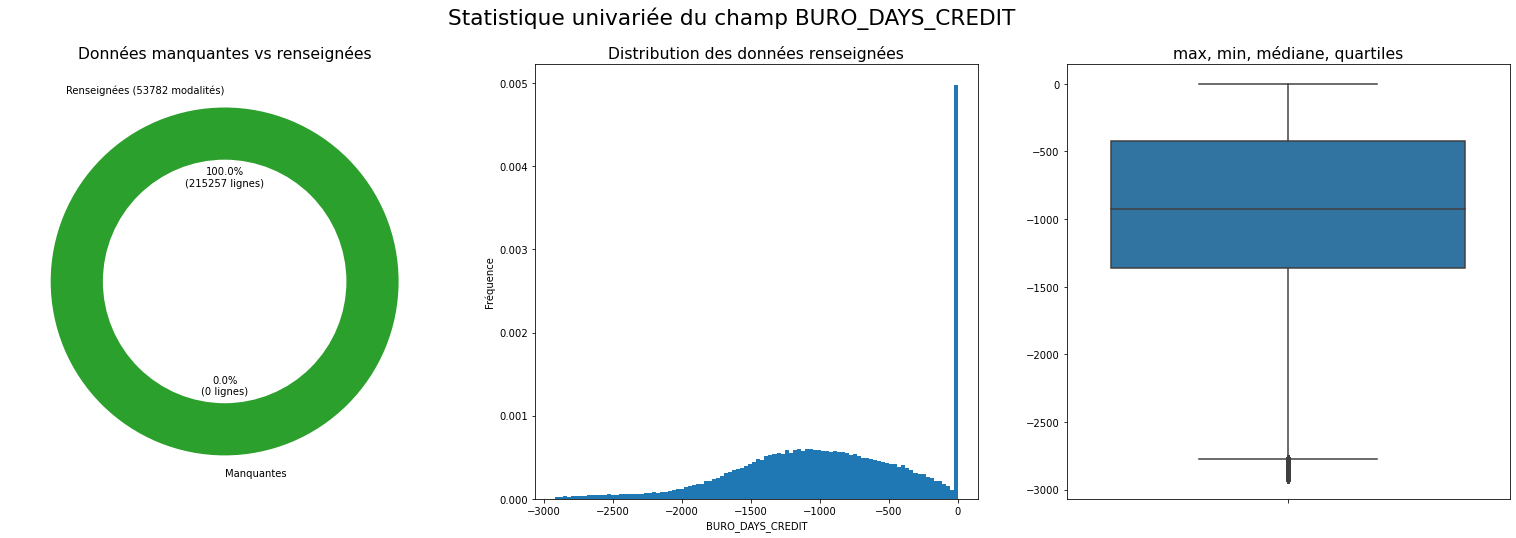

Mesures de position
 - Moyenne: -926.73
 - Médiane: -926.08
Mesures de dispertion
 - Ecart type: 644.67
 - Min: -2922.0
 - Q25: -1361.5
 - Q75: -422.0
 - Max: 0.0
Mesures de forme
 - Skewness (asymétrie): -0.35
 - Kurtosis (applatissement): -0.34


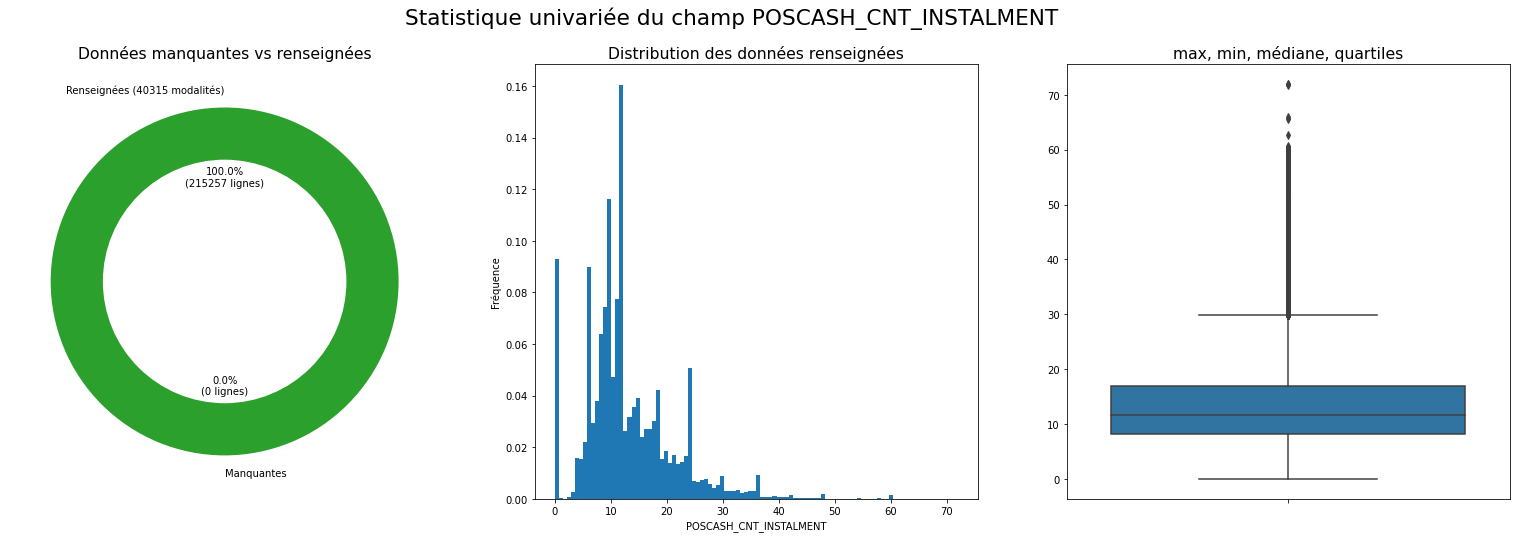

Mesures de position
 - Moyenne: 12.98
 - Médiane: 11.62
Mesures de dispertion
 - Ecart type: 7.98
 - Min: 0.0
 - Q25: 8.25
 - Q75: 16.92
 - Max: 72.0
Mesures de forme
 - Skewness (asymétrie): 1.26
 - Kurtosis (applatissement): 3.21


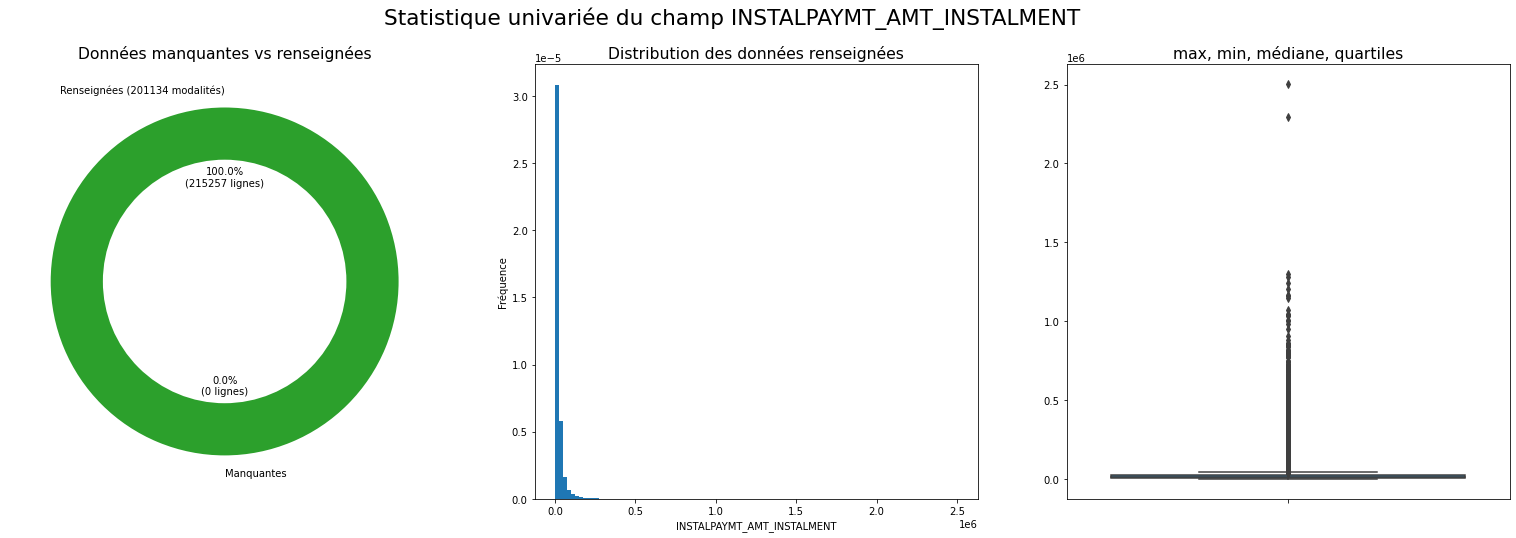

Mesures de position
 - Moyenne: 22019.9
 - Médiane: 12910.19
Mesures de dispertion
 - Ecart type: 37031.48
 - Min: 0.0
 - Q25: 7599.72
 - Q75: 23360.04
 - Max: 2504589.66
Mesures de forme
 - Skewness (asymétrie): 10.92
 - Kurtosis (applatissement): 295.06


In [155]:
for col in numerical_col:
    myDf(dfApplication).Stat(col, statsNan=True)

In [156]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
statFeat[statFeat.nb_unique>=100].sort_values('bestClassement')

feature  nb_unique  missing_prct  \
1                  PREV_DAYS_LAST_DUE_1ST_VERSION      51454         0.000   
4                                 AMT_GOODS_PRICE        834         0.092   
5                            CREDCARD_AMT_BALANCE      36064         0.000   
6                                 LIVINGAREA_MEDI       5058        50.148   
7                   CREDCARD_CNT_DRAWINGS_CURRENT       5576         0.000   
9                          POSCASH_MONTHS_BALANCE       4526         0.000   
10                        PREV_DAYS_FIRST_DRAWING      14084         0.000   
11              CREDCARD_AMT_RECEIVABLE_PRINCIPAL      35508         0.000   
12                   PREV_HOUR_APPR_PROCESS_START        823         0.000   
13             CREDCARD_AMT_PAYMENT_TOTAL_CURRENT      35358         0.000   
14                    BURO_AMT_CREDIT_SUM_OVERDUE       1402         0.000   
16                  CREDCARD_AMT_TOTAL_RECEIVABLE      35905         0.000   
17                       BURO_AMT_CREDIT_SUM_DEBT     121222         0.000   
18                            BURO_AMT_CREDIT_SUM     150007         0.000   
20                           PREV_AMT_GOODS_PRICE     125707         0.000   
21              CREDCARD_AMT_DRAWINGS_POS_CURRENT      22299         0.000   
23                        BURO_DAYS_CREDIT_UPDATE      46024         0.000   
24                         CREDCARD_AMT_RECIVABLE      35905         0.000   
25                            CREDCARD_SK_DPD_DEF       8635         0.000   
26                     PREV_RATE_INTEREST_PRIMARY        153         0.000   
27              CREDCARD_AMT_DRAWINGS_ATM_CURRENT      15428         0.000   
28                               BURO_AMT_ANNUITY      29938         0.000   
29                  CREDCARD_AMT_DRAWINGS_CURRENT      31869         0.000   
30                    INSTALPAYMT_DAYS_INSTALMENT     101645         0.000   
31                  POSCASH_CNT_INSTALMENT_FUTURE      58463         0.000   
35  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_POS     203461         0.000   
34              CREDCARD_CNT_DRAWINGS_ATM_CURRENT       2954         0.000   
36                                DAYS_ID_PUBLISH       6127         0.000   
37                                     AMT_CREDIT       5069         0.000   
38                         BURO_DAYS_ENDDATE_FACT      35739         0.000   
39                 INSTALPAYMT_DAYS_ENTRY_PAYMENT     169114         0.000   
40                               BURO_DAYS_CREDIT      53782         0.000   
41                         POSCASH_CNT_INSTALMENT      40315         0.000   
42                     INSTALPAYMT_AMT_INSTALMENT     201134         0.000   

           mini        q25     median        q75          maxi       mean  \
1     -2798.000   -755.143   -148.250  36316.800    365243.000  28762.195   
4     45000.000 238500.000 450000.000 679500.000   4050000.000 538187.974   
5     -2625.000      0.000      0.000      0.000    928686.324  19030.105   
6         0.000      0.046      0.075      0.130         1.000      0.108   
7         0.000      0.256      0.903      2.818        95.250      2.537   
9       -94.000    -40.500    -25.000    -12.000         0.000    -27.854   
10    -2922.000      0.000 243184.667 273887.750    365243.000 183426.799   
11    -2625.000      0.000      0.000      0.000    884547.881  18312.703   
12        0.000     10.500     12.600     14.500        23.000     12.023   
13        0.000   4261.612   9049.091  19495.447   1125000.000  16560.578   
14        0.000      7.276     37.500    184.500   1617403.500   3814.113   
16    -2625.000      0.000      0.000      0.000    913096.639  18895.081   
17 -1083614.670      0.000  22309.200 112641.750  37904382.000 133311.427   
18        0.000  67099.716 158490.000 344009.637 198072344.250 322531.910   
20        0.000  60833.250 110241.000 206170.500   4050000.000 162859.892   
21        0.000   1862.252   7415.440  19159.178    918645.460  15657.841   
23

# Prétraitements

In [32]:
#https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

In [17]:
dfApplication = load(open('dfApplicationReduced.pkl','rb'))

## Prétraitement des variables numériques

### Transformers

In [159]:
# test transform
cols = numerical_col
transformMetrics = []
cv = 3

listLabel = ['PowerTransformer', 'QuantileTransformer', 'KBinsDiscretizer 10', 'KBinsDiscretizer 50', 'KBinsDiscretizer 100'] 

transformMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))


transformMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))

j = 0
for col in cols:

    j += 1
    print(j)
    print(datetime.datetime.now())

    for i in np.arange(len(listLabel)):


        print(col + ' - ' + listLabel[i])        

        if listLabel[i] == 'PowerTransformer':
            power = [col]
            quantile=[]
            kbins10=[]
            kbins50=[]
            kbins100=[]

        if listLabel[i] == 'QuantileTransformer':
            power = []
            quantile=[col]
            kbins10=[]
            kbins50=[]
            kbins100=[]
        if listLabel[i] == 'KBinsDiscretizer 10':
            power = []
            quantile=[]
            kbins10=[col]
            kbins50=[]
            kbins100=[]
        if listLabel[i] == 'KBinsDiscretizer 50':
            power = []
            quantile=[]
            kbins10=[]
            kbins50=[col]
            kbins100=[]
        if listLabel[i] == 'KBinsDiscretizer 100':
            power = []
            quantile=[]
            kbins10=[]
            kbins50=[]
            kbins100=[col]


        transformMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    model=RFmodel,
                                    display_plot=False,
                                    title_plot = 'Random forest | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        transformMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    model=XGmodel,
                                    display_plot=False,
                                    title_plot = 'XGBoost | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        dump(transformMetrics, open('transformMetrics.pkl','wb'))



1
2021-03-01 14:46:44.210587
PREV_DAYS_LAST_DUE_1ST_VERSION - PowerTransformer
PREV_DAYS_LAST_DUE_1ST_VERSION - QuantileTransformer
PREV_DAYS_LAST_DUE_1ST_VERSION - KBinsDiscretizer 10
PREV_DAYS_LAST_DUE_1ST_VERSION - KBinsDiscretizer 50
PREV_DAYS_LAST_DUE_1ST_VERSION - KBinsDiscretizer 100
2
2021-03-01 14:49:39.894997
AMT_GOODS_PRICE - PowerTransformer
AMT_GOODS_PRICE - QuantileTransformer
AMT_GOODS_PRICE - KBinsDiscretizer 10
AMT_GOODS_PRICE - KBinsDiscretizer 50
AMT_GOODS_PRICE - KBinsDiscretizer 100
3
2021-03-01 14:52:36.761235
CREDCARD_AMT_BALANCE - PowerTransformer
CREDCARD_AMT_BALANCE - QuantileTransformer
CREDCARD_AMT_BALANCE - KBinsDiscretizer 10
CREDCARD_AMT_BALANCE - KBinsDiscretizer 50
CREDCARD_AMT_BALANCE - KBinsDiscretizer 100
4
2021-03-01 14:55:34.180130
LIVINGAREA_MEDI - PowerTransformer
LIVINGAREA_MEDI - QuantileTransformer
LIVINGAREA_MEDI - KBinsDiscretizer 10
LIVINGAREA_MEDI - KBinsDiscretizer 50
LIVINGAREA_MEDI - KBinsDiscretizer 100
5
2021-03-01 14:59:16.307556
CRE

INSTALPAYMT_DAYS_ENTRY_PAYMENT - KBinsDiscretizer 50
INSTALPAYMT_DAYS_ENTRY_PAYMENT - KBinsDiscretizer 100
32
2021-03-01 16:27:00.361823
BURO_DAYS_CREDIT - PowerTransformer
BURO_DAYS_CREDIT - QuantileTransformer
BURO_DAYS_CREDIT - KBinsDiscretizer 10
BURO_DAYS_CREDIT - KBinsDiscretizer 50
BURO_DAYS_CREDIT - KBinsDiscretizer 100
33
2021-03-01 16:29:56.706630
POSCASH_CNT_INSTALMENT - PowerTransformer
POSCASH_CNT_INSTALMENT - QuantileTransformer
POSCASH_CNT_INSTALMENT - KBinsDiscretizer 10
POSCASH_CNT_INSTALMENT - KBinsDiscretizer 50
POSCASH_CNT_INSTALMENT - KBinsDiscretizer 100
34
2021-03-01 16:32:52.190839
INSTALPAYMT_AMT_INSTALMENT - PowerTransformer
INSTALPAYMT_AMT_INSTALMENT - QuantileTransformer
INSTALPAYMT_AMT_INSTALMENT - KBinsDiscretizer 10
INSTALPAYMT_AMT_INSTALMENT - KBinsDiscretizer 50
INSTALPAYMT_AMT_INSTALMENT - KBinsDiscretizer 100


In [71]:
transformMetrics = load(open('transformMetrics.pkl','rb'))

In [72]:
pd.concat(transformMetrics).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  \
0                                                                 Random forest | Initial   
1                                                                       XGBoost | Initial   
2                                           Random forest | AMT_CREDIT | PowerTransformer   
3                                                 XGBoost | AMT_CREDIT | PowerTransformer   
4                                        Random forest | AMT_CREDIT | QuantileTransformer   
5                                              XGBoost | AMT_CREDIT | QuantileTransformer   
6                                        Random forest | AMT_CREDIT | KBinsDiscretizer 10   
7                                              XGBoost | AMT_CREDIT | KBinsDiscretizer 10   
8                                        Random forest | AMT_CREDIT | KBinsDiscretizer 50   
9                                              XGBoost | AMT_CREDIT | KBinsDiscretizer 50   
10                                      Random forest | AMT_CREDIT | KBinsDiscretizer 100   
11                                            XGBoost | AMT_CREDIT | KBinsDiscretizer 100   
12                                     Random forest | AMT_GOODS_PRICE | PowerTransformer   
13                                           XGBoost | AMT_GOODS_PRICE | PowerTransformer   
14                                  Random forest | AMT_GOODS_PRICE | QuantileTransformer   
15                                        XGBoost | AMT_GOODS_PRICE | QuantileTransformer   
16                                  Random forest | AMT_GOODS_PRICE | KBinsDiscretizer 10   
17                                        XGBoost | AMT_GOODS_PRICE | KBinsDiscretizer 10   
18                                  Random forest | AMT_GOODS_PRICE | KBinsDiscretizer 50   
19                                        XGBoost | AMT_GOODS_PRICE | KBinsDiscretizer 50   
20                                 Random forest | AMT_GOODS_PRICE | KBinsDiscretizer 100   
21                                       XGBoost | AMT_GOODS_PRICE | KBinsDiscretizer 100   
22                                     Random forest | LIVINGAREA_MEDI | PowerTransformer   
23                                           XGBoost | LIVINGAREA_MEDI | PowerTransformer   
24                                  Random forest | LIVINGAREA_MEDI | QuantileTransformer   
25                                        XGBoost | LIVINGAREA_MEDI | QuantileTransformer   
26                                  Random forest | LIVINGAREA_MEDI | KBinsDiscretizer 10   
27                                        XGBoost | LIVINGAREA_MEDI | KBinsDiscretizer 10   
28                                  Random forest | LIVINGAREA_MEDI | KBinsDiscretizer 50   
29                                        XGBoost | LIVINGAREA_MEDI | KBinsDiscretizer 50   
30                                 Random forest | LIVINGAREA_MEDI | KBinsDiscretizer 100   
31                                       XGBoost | LIVINGAREA_MEDI | KBinsDiscretizer 100   
32                              Random forest | PREV_AMT_CREDIT_ACTIVE | PowerTransformer   
33                                    XGBoost | PREV_AMT_CREDIT_ACTIVE | PowerTransformer   
34                           Random forest | PREV_AMT_CREDIT_ACTIVE | QuantileTransformer   
35                                 XGBoost | PREV_AMT_CREDIT_ACTIVE | QuantileTransformer   
36                           Random forest | PREV_AMT_CREDIT_ACTIVE | KBinsDiscretizer 10   
37                                 XGBoost | PREV_AMT_CREDIT_ACTIVE | KBinsDiscretizer 10   
38                           Random forest | PREV_AMT_CREDIT_ACTIVE | KBinsDiscretizer 50   
39                                 XGBoost | PREV_AMT_CREDIT_ACTIVE | KBinsDiscretizer 50   
40                          Random forest | PREV_AMT_CREDIT_ACTIVE | KBinsDiscretizer 100   
41                                XGBoost | PREV_AMT_CREDIT_ACTIVE | KBinsDiscretizer 100   
42       Random forest | INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG | PowerTransfo

In [73]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
tmp = pd.concat(transformMetrics).groupby('title').mean().reset_index().sort_values('timestamp')
#tmp = tmp[(tmp.title.str.find('KBinsDiscretizer 10') < 0) & (tmp.title.str.find('KBinsDiscretizer 100') < 0)]

roc_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].roc_auc_test.values[0]
pr_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].pr_auc_test.values[0]
roc_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].roc_auc_test.values[0]
pr_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].pr_auc_test.values[0]

tmp['gain'] = tmp.apply(lambda x: 1000 * (x.roc_auc_test + x.pr_auc_test - np.where(x.title.find('forest') > 0, roc_auc_test_rf + pr_auc_test_rf, roc_auc_test_xg + pr_auc_test_xg)), axis=1)
tmp = tmp[tmp.gain > 0]
tmp['model'] = tmp.apply(lambda x: x.title.split('|')[0].strip(), axis=1)
tmp['feature'] = tmp.apply(lambda x: x.title.split('|')[1].strip(), axis=1)
tmp['transformer'] = tmp.apply(lambda x: x.title.split('|')[2].strip(), axis=1)
del tmp['title']
tmp = tmp[['model','feature','transformer','gain']]
tmp = tmp.merge(tmp.groupby(['model','feature']).agg({'gain':'max'}).reset_index(drop=False), left_on=['model','feature','gain'], right_on=['model','feature','gain'])
tmp = tmp.merge(tmp.groupby(['model','feature','gain']).agg({'transformer':'min'}).reset_index(drop=False), left_on=['model','feature','gain','transformer'], right_on=['model','feature','gain','transformer'])
tmp.sort_values('gain', ascending=False).reset_index(drop=True)

model                                        feature  \
0   Random forest                        BURO_DAYS_CREDIT_UPDATE   
1   Random forest  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG   
2         XGBoost              CREDCARD_AMT_DRAWINGS_ATM_CURRENT   
3   Random forest                     PREV_RATE_INTEREST_PRIMARY   
4   Random forest                  CREDCARD_AMT_TOTAL_RECEIVABLE   
5         XGBoost                   PREV_HOUR_APPR_PROCESS_START   
6   Random forest             CREDCARD_CNT_INSTALMENT_MATURE_CUM   
7   Random forest                         BURO_DAYS_ENDDATE_FACT   
8   Random forest              CREDCARD_AMT_DRAWINGS_ATM_CURRENT   
9   Random forest                               BURO_AMT_ANNUITY   
10  Random forest                  POSCASH_CNT_INSTALMENT_FUTURE   
11  Random forest                  CREDCARD_CNT_DRAWINGS_CURRENT   
12        XGBoost                         POSCASH_CNT_INSTALMENT   
13  Random forest                           CREDCARD_AMT_BALANCE   
14  Random forest                        PREV_DAYS_FIRST_DRAWING   
15  Random forest                            BURO_AMT_CREDIT_SUM   
16  Random forest                         CREDCARD_AMT_RECIVABLE   
17        XGBoost                  POSCASH_CNT_INSTALMENT_FUTURE   
18  Random forest              CREDCARD_CNT_DRAWINGS_ATM_CURRENT   
19  Random forest                   PREV_HOUR_APPR_PROCESS_START   
20  Random forest                         PREV_AMT_CREDIT_ACTIVE   
21        XGBoost                         BURO_DAYS_ENDDATE_FACT   
22  Random forest                         POSCASH_CNT_INSTALMENT   
23  Random forest                 PREV_DAYS_LAST_DUE_1ST_VERSION   
24  Random forest                 PREV_NFLAG_INSURED_ON_APPROVAL   
25  Random forest                    INSTALPAYMT_DAYS_INSTALMENT   
26        XGBoost              CREDCARD_CNT_DRAWINGS_ATM_CURRENT   
27  Random forest              CREDCARD_AMT_RECEIVABLE_PRINCIPAL   
28  Random forest                   CREDCARD_AMT_PAYMENT_CURRENT   
29  Random forest                                     AMT_CREDIT   
30        XGBoost                                LIVINGAREA_MEDI   
31        XGBoost                       BURO_AMT_CREDIT_SUM_DEBT   
32  Random forest                                LIVINGAREA_MEDI   
33  Random forest                           PREV_AMT_GOODS_PRICE   
34  Random forest                       BURO_AMT_CREDIT_SUM_DEBT   
35        XGBoost                        BURO_DAYS_CREDIT_UPDATE   
36  Random forest                                AMT_GOODS_PRICE   
37        XGBoost                        PREV_DAYS_FIRST_DRAWING   
38        XGBoost                 PREV_NFLAG_INSURED_ON_APPROVAL   
39        XGBoost              CREDCARD_AMT_RECEIVABLE_PRINCIPAL   
40        XGBoost                 PREV_DAYS_LAST_DUE_1ST_VERSION   
41  Random forest                    BURO_AMT_CREDIT_SUM_OVERDUE   
42        XGBoost                   CREDCARD_AMT_PAYMENT_CURRENT   
43        XGBoost                    INSTALPAYMT_DAYS_INSTALMENT   
44        XGBoost  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG   
45        XGBoost                           PREV_AMT_GOODS_PRICE   
46        XGBoost                           CREDCARD_AMT_BALANCE   
47        XGBoost             CREDCARD_CNT_INSTALMENT_MATURE_CUM   
48        XGBoost                            BURO_AMT_CREDIT_SUM   

             transformer    gain  
0    KBinsDiscretizer 50 5.46723  
1    QuantileTransformer 3.90450  
2   KBinsDiscretizer 100 2.34878  
3    KBinsDiscretizer 10 2.27077  
4   KBinsDiscretizer 100 2.23736  
5   KBinsDiscretizer 100 2.15601  
6   KBinsDiscretizer 100 2.07145  
7    KBinsDiscretizer 50 2.05852  
8    KBinsDiscretizer 10 2.02822  
9   KBinsDiscretizer 100 2.02757  
10   KBinsDiscretizer 50 1.97941  
11   QuantileTransformer 1.94122  
12   KBinsDiscretizer 50 1.90433  
13   QuantileTransformer 1.86821  
14   KBinsDiscretizer 10 1.86180  
15   QuantileTransformer 1.82193  
16   KBinsDiscre

In [74]:
power_rf = list(tmp[(tmp.model == 'Random forest') & (tmp.transformer == 'PowerTransformer')].feature)
quantile_rf = list(tmp[(tmp.model == 'Random forest') & (tmp.transformer == 'QuantileTransformer')].feature)
kbins10_rf = list(tmp[(tmp.model == 'Random forest') & (tmp.transformer == 'KBinsDiscretizer 10')].feature)
kbins50_rf = list(tmp[(tmp.model == 'Random forest') & (tmp.transformer == 'KBinsDiscretizer 50')].feature)
kbins100_rf = list(tmp[(tmp.model == 'Random forest') & (tmp.transformer == 'KBinsDiscretizer 100')].feature)

In [75]:
power_xg = list(tmp[(tmp.model == 'XGBoost') & (tmp.transformer == 'PowerTransformer')].feature)
quantile_xg = list(tmp[(tmp.model == 'XGBoost') & (tmp.transformer == 'QuantileTransformer')].feature)
kbins10_xg = list(tmp[(tmp.model == 'XGBoost') & (tmp.transformer == 'KBinsDiscretizer 10')].feature)
kbins50_xg = list(tmp[(tmp.model == 'XGBoost') & (tmp.transformer == 'KBinsDiscretizer 50')].feature)
kbins100_xg = list(tmp[(tmp.model == 'XGBoost') & (tmp.transformer == 'KBinsDiscretizer 100')].feature)

In [ ]:
power_rf = []
quantile_rf = []
kbins10_rf = []
kbins50_rf = []
kbins100_rf = []

power_xg = []
quantile_xg = []
kbins10_xg = []
kbins50_xg = []
kbins100_xg = []

In [76]:
cv = 10

transformMetrics2 = []

transformMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))


transformMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))



transformMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            #power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | transform',
                            cv=cv))


transformMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            #power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=[],
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | transform',
                            cv=cv))

pd.concat(transformMetrics2).groupby('title').mean().reset_index().sort_values('timestamp')

title  roc_auc_train  roc_auc_test  pr_auc_train  \
0    Random forest | Initial        0.67452       0.66445       0.17289   
2          XGBoost | Initial        0.75010       0.70930       0.25188   
1  Random forest | transform        0.68024       0.67108       0.17086   
3        XGBoost | transform        0.74582       0.70832       0.24448   

   pr_auc_test  time_train  time_pred  nb_feat     nb_train        timestamp  
0      0.15883     7.13072    0.87319 50.00000 193731.30000 1614675660.00000  
2      0.19205     2.73207    0.58233 50.00000 193731.30000 1614675713.00000  
1      0.15888     7.19579    1.06318 50.00000 193731.30000 1614675817.00000  
3      0.18991     3.36890    0.69423 50.00000 193731.30000 1614675878.00000

In [54]:
tmp[tmp.model == 'XGBoost'].sort_values('gain', ascending=False).reset_index(drop=True)

model                                        feature  \
0   XGBoost              CREDCARD_AMT_DRAWINGS_ATM_CURRENT   
1   XGBoost                   PREV_HOUR_APPR_PROCESS_START   
2   XGBoost                         POSCASH_CNT_INSTALMENT   
3   XGBoost                  POSCASH_CNT_INSTALMENT_FUTURE   
4   XGBoost                         BURO_DAYS_ENDDATE_FACT   
5   XGBoost              CREDCARD_CNT_DRAWINGS_ATM_CURRENT   
6   XGBoost                                LIVINGAREA_MEDI   
7   XGBoost                       BURO_AMT_CREDIT_SUM_DEBT   
8   XGBoost                        BURO_DAYS_CREDIT_UPDATE   
9   XGBoost                        PREV_DAYS_FIRST_DRAWING   
10  XGBoost                 PREV_NFLAG_INSURED_ON_APPROVAL   
11  XGBoost              CREDCARD_AMT_RECEIVABLE_PRINCIPAL   
12  XGBoost                 PREV_DAYS_LAST_DUE_1ST_VERSION   
13  XGBoost                   CREDCARD_AMT_PAYMENT_CURRENT   
14  XGBoost                    INSTALPAYMT_DAYS_INSTALMENT   
15  XGBoost  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG   
16  XGBoost                           PREV_AMT_GOODS_PRICE   
17  XGBoost                           CREDCARD_AMT_BALANCE   
18  XGBoost             CREDCARD_CNT_INSTALMENT_MATURE_CUM   
19  XGBoost                            BURO_AMT_CREDIT_SUM   

             transformer    gain  
0   KBinsDiscretizer 100 2.34878  
1   KBinsDiscretizer 100 2.15601  
2    KBinsDiscretizer 50 1.90433  
3   KBinsDiscretizer 100 1.59475  
4    KBinsDiscretizer 10 1.52940  
5    KBinsDiscretizer 10 1.40680  
6   KBinsDiscretizer 100 1.22515  
7       PowerTransformer 1.14743  
8   KBinsDiscretizer 100 0.79930  
9    KBinsDiscretizer 10 0.77629  
10   KBinsDiscretizer 10 0.70524  
11  KBinsDiscretizer 100 0.67177  
12   KBinsDiscretizer 10 0.48098  
13   KBinsDiscretizer 50 0.27933  
14   KBinsDiscretizer 50 0.24408  
15      PowerTransformer 0.19153  
16  KBinsDiscretizer 100 0.13765  
17      PowerTransformer 0.00706  
18   QuantileTransformer 0.00518  
19      PowerTransformer 0.00001

In [77]:
kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []

In [78]:
transformMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            #power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=[],
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | transform 3',
                            cv=cv))

pd.concat(transformMetrics2).groupby('title').mean().reset_index().sort_values('timestamp')

title  roc_auc_train  roc_auc_test  pr_auc_train  \
0    Random forest | Initial        0.67452       0.66445       0.17289   
2          XGBoost | Initial        0.75010       0.70930       0.25188   
1  Random forest | transform        0.68024       0.67108       0.17086   
3        XGBoost | transform        0.74582       0.70832       0.24448   
4      XGBoost | transform 3        0.74986       0.70933       0.25085   

   pr_auc_test  time_train  time_pred  nb_feat     nb_train        timestamp  
0      0.15883     7.13072    0.87319 50.00000 193731.30000 1614675660.00000  
2      0.19205     2.73207    0.58233 50.00000 193731.30000 1614675713.00000  
1      0.15888     7.19579    1.06318 50.00000 193731.30000 1614675817.00000  
3      0.18991     3.36890    0.69423 50.00000 193731.30000 1614675878.00000  
4      0.19326     2.84012    0.60461 50.00000 193731.30000 1614676026.00000

In [68]:
tmp[tmp.model == 'Random forest'].sort_values('gain', ascending=False).reset_index(drop=True)

model                                        feature  \
0   Random forest                        BURO_DAYS_CREDIT_UPDATE   
1   Random forest  INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG   
2   Random forest                     PREV_RATE_INTEREST_PRIMARY   
3   Random forest                  CREDCARD_AMT_TOTAL_RECEIVABLE   
4   Random forest             CREDCARD_CNT_INSTALMENT_MATURE_CUM   
5   Random forest                         BURO_DAYS_ENDDATE_FACT   
6   Random forest              CREDCARD_AMT_DRAWINGS_ATM_CURRENT   
7   Random forest                               BURO_AMT_ANNUITY   
8   Random forest                  POSCASH_CNT_INSTALMENT_FUTURE   
9   Random forest                  CREDCARD_CNT_DRAWINGS_CURRENT   
10  Random forest                           CREDCARD_AMT_BALANCE   
11  Random forest                        PREV_DAYS_FIRST_DRAWING   
12  Random forest                            BURO_AMT_CREDIT_SUM   
13  Random forest                         CREDCARD_AMT_RECIVABLE   
14  Random forest              CREDCARD_CNT_DRAWINGS_ATM_CURRENT   
15  Random forest                   PREV_HOUR_APPR_PROCESS_START   
16  Random forest                         PREV_AMT_CREDIT_ACTIVE   
17  Random forest                         POSCASH_CNT_INSTALMENT   
18  Random forest                 PREV_DAYS_LAST_DUE_1ST_VERSION   
19  Random forest                 PREV_NFLAG_INSURED_ON_APPROVAL   
20  Random forest                    INSTALPAYMT_DAYS_INSTALMENT   
21  Random forest              CREDCARD_AMT_RECEIVABLE_PRINCIPAL   
22  Random forest                   CREDCARD_AMT_PAYMENT_CURRENT   
23  Random forest                                     AMT_CREDIT   
24  Random forest                                LIVINGAREA_MEDI   
25  Random forest                           PREV_AMT_GOODS_PRICE   
26  Random forest                       BURO_AMT_CREDIT_SUM_DEBT   
27  Random forest                                AMT_GOODS_PRICE   
28  Random forest                    BURO_AMT_CREDIT_SUM_OVERDUE   

             transformer    gain  
0    KBinsDiscretizer 50 5.46723  
1    QuantileTransformer 3.90450  
2    KBinsDiscretizer 10 2.27077  
3   KBinsDiscretizer 100 2.23736  
4   KBinsDiscretizer 100 2.07145  
5    KBinsDiscretizer 50 2.05852  
6    KBinsDiscretizer 10 2.02822  
7   KBinsDiscretizer 100 2.02757  
8    KBinsDiscretizer 50 1.97941  
9    QuantileTransformer 1.94122  
10   QuantileTransformer 1.86821  
11   KBinsDiscretizer 10 1.86180  
12   QuantileTransformer 1.82193  
13   KBinsDiscretizer 10 1.77855  
14   KBinsDiscretizer 50 1.55176  
15   KBinsDiscretizer 10 1.54542  
16      PowerTransformer 1.54210  
17   QuantileTransformer 1.52767  
18   KBinsDiscretizer 50 1.51307  
19   KBinsDiscretizer 10 1.48454  
20  KBinsDiscretizer 100 1.44287  
21  KBinsDiscretizer 100 1.35818  
22   KBinsDiscretizer 50 1.33729  
23   QuantileTransformer 1.27312  
24  KBinsDiscretizer 100 0.98904  
25  KBinsDiscretizer 100 0.98512  
26   QuantileTransformer 0.83882  
27      PowerTransformer 0.79865  
28  KBinsDiscretizer 100 0.46402

In [85]:
kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

In [86]:
transformMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            #power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | transform 10',
                            cv=cv))

tmp_rf = pd.concat(transformMetrics2).groupby('title').mean().reset_index().sort_values('timestamp')
tmp_rf = tmp_rf[tmp_rf.title.str.contains('Random forest')]
tmp_rf

title  roc_auc_train  roc_auc_test  pr_auc_train  \
0       Random forest | Initial        0.67452       0.66445       0.17289   
1     Random forest | transform        0.68024       0.67108       0.17086   
3   Random forest | transform 8        0.67981       0.66990       0.17366   
4   Random forest | transform 9        0.68038       0.67037       0.17405   
2  Random forest | transform 10        0.67997       0.66999       0.17396   

   pr_auc_test  time_train  time_pred  nb_feat     nb_train        timestamp  
0      0.15883     7.13072    0.87319 50.00000 193731.30000 1614675660.00000  
1      0.15888     7.19579    1.06318 50.00000 193731.30000 1614675817.00000  
3      0.16006     7.27602    0.94727 50.00000 193731.30000 1614676187.00000  
4      0.16013     7.40333    1.02432 50.00000 193731.30000 1614676532.00000  
2      0.15967     7.88687    1.02041 50.00000 193731.30000 1614676904.00000

### Scaler

In [89]:
cols = numerical_col
scalerMetrics = []
cv = 3

kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []


listLabel = ['MinMaxScaler', 'StandardScaler', 'RobustScaler'] 
    
scalerMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))


scalerMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=[],
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))

j = 0
for col in cols:
    
    j += 1
    print(j)
    print(datetime.datetime.now())
    
    for i in np.arange(len(listLabel)):
        
        
        print(col + ' - ' + listLabel[i])        
        
        if listLabel[i] == 'MinMaxScaler':
            minmax = [col]
            standard = []
            robust = []
        if listLabel[i] == 'StandardScaler':
            minmax = []
            standard = [col]
            robust = []
        if listLabel[i] == 'RobustScaler':
            minmax = []
            standard = []
            robust = [col]


        scalerMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                                    minmax=minmax, standard=standard, robust=robust, 
                                    ordinal=[], onehot=[],
                                    model=RFmodel,
                                    display_plot=False,
                                    title_plot = 'Random forest | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        scalerMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                                    minmax=minmax, standard=standard, robust=robust,
                                    ordinal=[], onehot=[],
                                    model=XGmodel,
                                    display_plot=False,
                                    title_plot = 'XGBoost | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        dump(scalerMetrics, open('scalerMetrics.pkl','wb'))



1
2021-03-02 10:30:36.605429
AMT_CREDIT - MinMaxScaler
AMT_CREDIT - StandardScaler
AMT_CREDIT - RobustScaler
2
2021-03-02 10:32:26.700790
AMT_GOODS_PRICE - MinMaxScaler
AMT_GOODS_PRICE - StandardScaler
AMT_GOODS_PRICE - RobustScaler


KeyboardInterrupt: 

In [91]:
scalerMetrics = load(open('scalerMetrics.pkl','rb'))

In [93]:
pd.concat(scalerMetrics).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  \
0                                                           Random forest | Initial   
1                                                                 XGBoost | Initial   
2                                         Random forest | AMT_CREDIT | MinMaxScaler   
3                                               XGBoost | AMT_CREDIT | MinMaxScaler   
4                                       Random forest | AMT_CREDIT | StandardScaler   
5                                             XGBoost | AMT_CREDIT | StandardScaler   
6                                         Random forest | AMT_CREDIT | RobustScaler   
7                                               XGBoost | AMT_CREDIT | RobustScaler   
8                                    Random forest | AMT_GOODS_PRICE | MinMaxScaler   
9                                          XGBoost | AMT_GOODS_PRICE | MinMaxScaler   
10                                 Random forest | AMT_GOODS_PRICE | StandardScaler   
11                                       XGBoost | AMT_GOODS_PRICE | StandardScaler   
12                                   Random forest | AMT_GOODS_PRICE | RobustScaler   
13                                         XGBoost | AMT_GOODS_PRICE | RobustScaler   
14                                   Random forest | LIVINGAREA_MEDI | MinMaxScaler   
15                                         XGBoost | LIVINGAREA_MEDI | MinMaxScaler   
16                                 Random forest | LIVINGAREA_MEDI | StandardScaler   
17                                       XGBoost | LIVINGAREA_MEDI | StandardScaler   
18                                   Random forest | LIVINGAREA_MEDI | RobustScaler   
19                                         XGBoost | LIVINGAREA_MEDI | RobustScaler   
20                            Random forest | PREV_AMT_CREDIT_ACTIVE | MinMaxScaler   
21                                  XGBoost | PREV_AMT_CREDIT_ACTIVE | MinMaxScaler   
22                          Random forest | PREV_AMT_CREDIT_ACTIVE | StandardScaler   
23                                XGBoost | PREV_AMT_CREDIT_ACTIVE | StandardScaler   
24                            Random forest | PREV_AMT_CREDIT_ACTIVE | RobustScaler   
25                                  XGBoost | PREV_AMT_CREDIT_ACTIVE | RobustScaler   
26     Random forest | INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG | MinMaxScaler   
27           XGBoost | INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG | MinMaxScaler   
28   Random forest | INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG | StandardScaler   
29         XGBoost | INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG | StandardScaler   
30     Random forest | INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG | RobustScaler   
31           XGBoost | INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG | RobustScaler   
32                              Random forest | PREV_AMT_GOODS_PRICE | MinMaxScaler   
33                                    XGBoost | PREV_AMT_GOODS_PRICE | MinMaxScaler   
34                            Random forest | PREV_AMT_GOODS_PRICE | StandardScaler   
35                                  XGBoost | PREV_AMT_GOODS_PRICE | StandardScaler   
36                              Random forest | PREV_AMT_GOODS_PRICE | RobustScaler   
37                                    XGBoost | PREV_AMT_GOODS_PRICE | RobustScaler   
38                      Random forest | PREV_HOUR_APPR_PROCESS_START | MinMaxScaler   
39                            XGBoost | PREV_HOUR_APPR_PROCESS_START | MinMaxScaler   
40                    Random forest | PREV_HOUR_APPR_PROCESS_START | StandardScaler   
41                          XGBoost | PREV_HOUR_APPR_PROCESS_START | StandardScaler   
42                      Random forest | PREV_HOUR_APPR_PROCESS_START | RobustScaler   
43                            XGBoost | PREV_HOUR_APPR_PROCESS_START | RobustScaler   
44                           Random forest | PREV_DAYS_FIRST_DRAWING | MinMaxScaler   
45                                 XGBoost | PREV_DAYS_FIRST_DRAWING | MinMa

In [95]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
tmp = pd.concat(scalerMetrics).groupby('title').mean().reset_index().sort_values('timestamp')
#tmp = tmp[(tmp.title.str.find('KBinsDiscretizer 10') < 0) & (tmp.title.str.find('KBinsDiscretizer 100') < 0)]

roc_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].roc_auc_test.values[0]
pr_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].pr_auc_test.values[0]
roc_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].roc_auc_test.values[0]
pr_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].pr_auc_test.values[0]

tmp['gain'] = tmp.apply(lambda x: 1000 * (x.roc_auc_test + x.pr_auc_test - np.where(x.title.find('forest') > 0, roc_auc_test_rf + pr_auc_test_rf, roc_auc_test_xg + pr_auc_test_xg)), axis=1)
tmp = tmp[tmp.gain > 0]
tmp['model'] = tmp.apply(lambda x: x.title.split('|')[0].strip(), axis=1)
tmp['feature'] = tmp.apply(lambda x: x.title.split('|')[1].strip(), axis=1)
tmp['scaler'] = tmp.apply(lambda x: x.title.split('|')[2].strip(), axis=1)
del tmp['title']
tmp = tmp[['model','feature','scaler','gain']]
tmp = tmp.merge(tmp.groupby(['model','feature']).agg({'gain':'max'}).reset_index(drop=False), left_on=['model','feature','gain'], right_on=['model','feature','gain'])
tmp = tmp.merge(tmp.groupby(['model','feature','gain']).agg({'scaler':'min'}).reset_index(drop=False), left_on=['model','feature','gain','scaler'], right_on=['model','feature','gain','scaler'])
tmp.sort_values('gain', ascending=False).reset_index(drop=True)

model                            feature          scaler    gain
0   Random forest            PREV_DAYS_FIRST_DRAWING  StandardScaler 0.63260
1   Random forest      POSCASH_CNT_INSTALMENT_FUTURE  StandardScaler 0.39844
2   Random forest               PREV_AMT_GOODS_PRICE    MinMaxScaler 0.34605
3   Random forest               CREDCARD_AMT_BALANCE  StandardScaler 0.32392
4   Random forest     PREV_NFLAG_INSURED_ON_APPROVAL    RobustScaler 0.20693
5   Random forest                   BURO_AMT_ANNUITY    MinMaxScaler 0.17552
6   Random forest                         AMT_CREDIT  StandardScaler 0.11642
7   Random forest     PREV_DAYS_LAST_DUE_1ST_VERSION    MinMaxScaler 0.04483
8   Random forest           BURO_AMT_CREDIT_SUM_DEBT  StandardScaler 0.02272
9         XGBoost  CREDCARD_AMT_RECEIVABLE_PRINCIPAL    RobustScaler 0.02008
10        XGBoost            PREV_DAYS_FIRST_DRAWING    RobustScaler 0.00300
11        XGBoost               CREDCARD_AMT_BALANCE    RobustScaler 0.00025
12        XGBoost            BURO_DAYS_CREDIT_UPDATE    RobustScaler 0.00012
13        XGBoost           BURO_AMT_CREDIT_SUM_DEBT    RobustScaler 0.00000

In [103]:
cols = numerical_col
scalerMetrics2 = []
cv = 3

kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

standard_rf = ['PREV_DAYS_FIRST_DRAWING','POSCASH_CNT_INSTALMENT_FUTURE','CREDCARD_AMT_BALANCE','AMT_CREDIT']
robust_rf = ['PREV_NFLAG_INSURED_ON_APPROVAL']


kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []

cv = 10

scalerMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | initial',
                            cv=cv))

scalerMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | transform',
                            cv=cv))

scalerMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, 
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | transform + scaler',
                            cv=cv))

In [105]:
pd.concat(scalerMetrics2).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  \
0             Random forest | initial        0.67855       0.66561   
1           Random forest | transform        0.68113       0.66931   
2  Random forest | transform + scaler        0.68284       0.67015   

   pr_auc_train  pr_auc_test  time_train  time_pred  nb_feat     nb_train  \
0       0.17822      0.15900     5.13018    0.63990 50.00000 143504.66667   
1       0.17808      0.15985     4.77867    0.67458 50.00000 143504.66667   
2       0.17904      0.16018     4.85703    0.68516 50.00000 143504.66667   

         timestamp  
0 1614701621.00000  
1 1614701643.00000  
2 1614701665.00000

### Imputer - categorical

In [115]:
cols = categorical_col
catImputerMetrics = []
cv = 10

kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

standard_rf = ['PREV_DAYS_FIRST_DRAWING','POSCASH_CNT_INSTALMENT_FUTURE','CREDCARD_AMT_BALANCE','AMT_CREDIT']
robust_rf = ['PREV_NFLAG_INSURED_ON_APPROVAL']


kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []


listLabel = ['MostFrequent'] 

    
catImputerMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, 
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))


catImputerMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=[],
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))

j = 0
for col in cols:
    
    j += 1
    print(j)
    print(datetime.datetime.now())
    
    for i in np.arange(len(listLabel)):
        
        
        print(col + ' - ' + listLabel[i])        
        
        if listLabel[i] == 'MostFrequent':
            mostFrequentImputer = [col]

        catImputerMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                                    minmax=[], standard=standard_rf, robust=robust_rf, 
                                    mostFrequentImputer=mostFrequentImputer,
                                    ordinal=[], onehot=[],
                                    model=RFmodel,
                                    display_plot=False,
                                    title_plot = 'Random forest | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        catImputerMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                                    minmax=[], standard=[], robust=[],
                                    mostFrequentImputer=mostFrequentImputer,
                                    ordinal=[], onehot=[],
                                    model=XGmodel,
                                    display_plot=False,
                                    title_plot = 'XGBoost | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        dump(catImputerMetrics, open('catImputerMetrics.pkl','wb'))



1
2021-03-02 20:23:14.645502
NAME_CONTRACT_TYPE - MostFrequent
2
2021-03-02 20:25:49.250145
CODE_GENDER - MostFrequent
3
2021-03-02 20:28:22.719119
NAME_TYPE_SUITE - MostFrequent
4
2021-03-02 20:30:55.426674
NAME_FAMILY_STATUS - MostFrequent
5
2021-03-02 20:33:27.447583
PREV_NAME_CONTRACT_TYPE - MostFrequent
6
2021-03-02 20:36:43.519425
PREV_WEEKDAY_APPR_PROCESS_START - MostFrequent
7
2021-03-02 20:40:15.548214
PREV_NAME_GOODS_CATEGORY - MostFrequent
8
2021-03-02 20:43:42.716662
PREV_NAME_PRODUCT_TYPE - MostFrequent
9
2021-03-02 20:47:08.257423
BURO_CREDIT_CURRENCY - MostFrequent
10
2021-03-02 20:50:50.309886
PREV_NAME_CONTRACT_STATUS - MostFrequent


In [116]:
pd.concat(catImputerMetrics).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  \
0                                          Random forest | Initial   
1                                                XGBoost | Initial   
2                Random forest | NAME_CONTRACT_TYPE | MostFrequent   
3                      XGBoost | NAME_CONTRACT_TYPE | MostFrequent   
4                       Random forest | CODE_GENDER | MostFrequent   
5                             XGBoost | CODE_GENDER | MostFrequent   
6                   Random forest | NAME_TYPE_SUITE | MostFrequent   
7                         XGBoost | NAME_TYPE_SUITE | MostFrequent   
8                Random forest | NAME_FAMILY_STATUS | MostFrequent   
9                      XGBoost | NAME_FAMILY_STATUS | MostFrequent   
10          Random forest | PREV_NAME_CONTRACT_TYPE | MostFrequent   
11                XGBoost | PREV_NAME_CONTRACT_TYPE | MostFrequent   
12  Random forest | PREV_WEEKDAY_APPR_PROCESS_START | MostFrequent   
13        XGBoost | PREV_WEEKDAY_APPR_PROCESS_START | MostFrequent   
14         Random forest | PREV_NAME_GOODS_CATEGORY | MostFrequent   
15               XGBoost | PREV_NAME_GOODS_CATEGORY | MostFrequent   
16           Random forest | PREV_NAME_PRODUCT_TYPE | MostFrequent   
17                 XGBoost | PREV_NAME_PRODUCT_TYPE | MostFrequent   
18             Random forest | BURO_CREDIT_CURRENCY | MostFrequent   
19                   XGBoost | BURO_CREDIT_CURRENCY | MostFrequent   
20        Random forest | PREV_NAME_CONTRACT_STATUS | MostFrequent   
21              XGBoost | PREV_NAME_CONTRACT_STATUS | MostFrequent   

    roc_auc_train  roc_auc_test  pr_auc_train  pr_auc_test  time_train  \
0         0.67980       0.67021       0.17332      0.15941     6.87671   
1         0.74986       0.70933       0.25085      0.19326     2.77772   
2         0.67968       0.67012       0.17331      0.15969     6.91556   
3         0.74986       0.70933       0.25085      0.19326     2.86652   
4         0.67969       0.67002       0.17351      0.15986     6.88054   
5         0.74986       0.70933       0.25085      0.19326     2.84226   
6         0.68015       0.67074       0.17390      0.15992     6.85601   
7         0.74986       0.70933       0.25085      0.19326     2.79170   
8         0.67995       0.67008       0.17348      0.16006     6.81106   
9         0.74986       0.70933       0.25085      0.19326     2.75848   
10        0.67974       0.66989       0.17338      0.15955     7.55882   
11        0.74986       0.70933       0.25085      0.19326     6.18175   
12        0.67961       0.67000       0.17396      0.16019     8.21987   
13        0.74986       0.70933       0.25085      0.19326     6.68154   
14        0.67981       0.66994       0.17366      0.15977     7.97895   
15        0.74986       0.70933       0.25085      0.19326     6.78790   
16        0.68009       0.67039       0.17429      0.16034     8.00796   
17        0.74986       0.70933       0.25085      0.19326     6.21145   
18        0.67978       0.66980       0.17368      0.15960     8.54029   
19        0.74986       0.70933       0.25085      0.19326     7.38734   
20        0.68042       0.67066       0.17424      0.16035     8.47502   
21        0.74986       0.70933       0.25085      0.19326     7.06816   

    time_pred  nb_feat     nb_train        timestamp  
0     0.93770 50.00000 193731.30000 1614712940.00000  
1     0.61830 50.00000 193731.30000 1614712995.00000  
2     0.94708 50.00000 193731.30000 1614713094.00000  
3     0.62610 50.00000 193731.30000 1614713149.00000  
4     0.93502 50.00000 193731.30000 1614713248.00000  
5     0.60837 50.00000 193731.30000 1614713303.00000  
6     0.94677 50.00000 193731.30000 1614713401.00000  
7     0.61341 50.00000 193731.30000 1614713455.00000  
8     0.94644 50.00000 193731.30000 1614713554.00000  
9     0.61354 50.00000 193731.30000 1614713607.00000  
10    0.98863 50.00000 193731.30000 1614713714.00000  
11    0.69774 50.00000 193731.30000 1614713804.00000  
12    1.01579 50.00000 193731.30

In [117]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
tmp = pd.concat(catImputerMetrics).groupby('title').mean().reset_index().sort_values('timestamp')
#tmp = tmp[(tmp.title.str.find('KBinsDiscretizer 10') < 0) & (tmp.title.str.find('KBinsDiscretizer 100') < 0)]

roc_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].roc_auc_test.values[0]
pr_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].pr_auc_test.values[0]
roc_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].roc_auc_test.values[0]
pr_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].pr_auc_test.values[0]

tmp['gain'] = tmp.apply(lambda x: 1000 * (x.roc_auc_test + x.pr_auc_test - np.where(x.title.find('forest') > 0, roc_auc_test_rf + pr_auc_test_rf, roc_auc_test_xg + pr_auc_test_xg)), axis=1)
tmp = tmp[tmp.gain > 0]
tmp['model'] = tmp.apply(lambda x: x.title.split('|')[0].strip(), axis=1)
tmp['feature'] = tmp.apply(lambda x: x.title.split('|')[1].strip(), axis=1)
tmp['scaler'] = tmp.apply(lambda x: x.title.split('|')[2].strip(), axis=1)
del tmp['title']
tmp = tmp[['model','feature','scaler','gain']]
tmp = tmp.merge(tmp.groupby(['model','feature']).agg({'gain':'max'}).reset_index(drop=False), left_on=['model','feature','gain'], right_on=['model','feature','gain'])
tmp = tmp.merge(tmp.groupby(['model','feature','gain']).agg({'scaler':'min'}).reset_index(drop=False), left_on=['model','feature','gain','scaler'], right_on=['model','feature','gain','scaler'])
tmp.sort_values('gain', ascending=False).reset_index(drop=True)

model                          feature        scaler    gain
0  Random forest        PREV_NAME_CONTRACT_STATUS  MostFrequent 1.38057
1  Random forest           PREV_NAME_PRODUCT_TYPE  MostFrequent 1.10832
2  Random forest                  NAME_TYPE_SUITE  MostFrequent 1.04038
3  Random forest  PREV_WEEKDAY_APPR_PROCESS_START  MostFrequent 0.56437
4  Random forest               NAME_FAMILY_STATUS  MostFrequent 0.51491
5  Random forest                      CODE_GENDER  MostFrequent 0.24938
6  Random forest               NAME_CONTRACT_TYPE  MostFrequent 0.18421
7  Random forest         PREV_NAME_GOODS_CATEGORY  MostFrequent 0.08556

In [120]:
cols = numerical_col
catImputerMetrics2 = []
cv = 3

kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

standard_rf = ['PREV_DAYS_FIRST_DRAWING','POSCASH_CNT_INSTALMENT_FUTURE','CREDCARD_AMT_BALANCE','AMT_CREDIT']
robust_rf = ['PREV_NFLAG_INSURED_ON_APPROVAL']

most_frequent_rf = ['PREV_NAME_CONTRACT_STATUS','PREV_NAME_PRODUCT_TYPE','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','CODE_GENDER','NAME_CONTRACT_TYPE','PREV_NAME_GOODS_CATEGORY']


kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []

cv = 10

catImputerMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, 
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | transform + scaler',
                            cv=cv))

catImputerMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, 
                            mostFrequentImputer=most_frequent_rf,
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | transform + scaler + cat most_frequent',
                            cv=cv))

pd.concat(catImputerMetrics2).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  \
0                      Random forest | transform + scaler        0.67984   
1  Random forest | transform + scaler + cat most_frequent        0.67988   

   roc_auc_test  pr_auc_train  pr_auc_test  time_train  time_pred  nb_feat  \
0       0.66983       0.17363      0.15964     8.37992    1.06811 50.00000   
1       0.66996       0.17393      0.16075     8.44416    1.04636 50.00000   

      nb_train        timestamp  
0 193731.30000 1614716070.00000  
1 193731.30000 1614716188.00000

### Encoder

In [23]:
cols = categorical_col
encoderMetrics = []
cv = 10

kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

standard_rf = ['PREV_DAYS_FIRST_DRAWING','POSCASH_CNT_INSTALMENT_FUTURE','CREDCARD_AMT_BALANCE','AMT_CREDIT']
robust_rf = ['PREV_NFLAG_INSURED_ON_APPROVAL']

most_frequent_rf = ['PREV_NAME_CONTRACT_STATUS','PREV_NAME_PRODUCT_TYPE','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','CODE_GENDER','NAME_CONTRACT_TYPE','PREV_NAME_GOODS_CATEGORY']



kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []


listLabel = ['OneHotEncoder'] 

    
encoderMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, 
                            mostFrequentImputer = most_frequent_rf,
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))


encoderMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=[],
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))

j = 0
for col in cols:
    
    j += 1
    print(j)
    print(datetime.datetime.now())
    
    for i in np.arange(len(listLabel)):
        
        
        print(col + ' - ' + listLabel[i])        
        
        if listLabel[i] == 'OneHotEncoder':
            onehot = [col]

        encoderMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                                    minmax=[], standard=standard_rf, robust=robust_rf, 
                                    mostFrequentImputer=most_frequent_rf,
                                    ordinal=[], onehot=onehot,
                                    model=RFmodel,
                                    display_plot=False,
                                    title_plot = 'Random forest | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        encoderMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                                    minmax=[], standard=[], robust=[],
                                    mostFrequentImputer=[],
                                    ordinal=[], onehot=onehot,
                                    model=XGmodel,
                                    display_plot=False,
                                    title_plot = 'XGBoost | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        dump(encoderMetrics, open('encoderMetrics.pkl','wb'))



1
2021-03-03 14:53:08.876385
NAME_CONTRACT_TYPE - OneHotEncoder
2
2021-03-03 14:56:16.624236
CODE_GENDER - OneHotEncoder
3
2021-03-03 14:59:28.591581
NAME_TYPE_SUITE - OneHotEncoder
4
2021-03-03 15:02:36.268457
NAME_FAMILY_STATUS - OneHotEncoder
5
2021-03-03 15:05:57.193929
PREV_NAME_CONTRACT_TYPE - OneHotEncoder
6
2021-03-03 15:09:33.964193
PREV_WEEKDAY_APPR_PROCESS_START - OneHotEncoder
7
2021-03-03 15:13:04.642232
PREV_NAME_GOODS_CATEGORY - OneHotEncoder
8
2021-03-03 15:16:41.329583
PREV_NAME_PRODUCT_TYPE - OneHotEncoder
9
2021-03-03 15:19:52.556026
BURO_CREDIT_CURRENCY - OneHotEncoder
10
2021-03-03 15:23:05.527735
PREV_NAME_CONTRACT_STATUS - OneHotEncoder


In [26]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
tmp = pd.concat(encoderMetrics).groupby('title').mean().reset_index().sort_values('timestamp')
#tmp = tmp[(tmp.title.str.find('KBinsDiscretizer 10') < 0) & (tmp.title.str.find('KBinsDiscretizer 100') < 0)]

roc_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].roc_auc_test.values[0]
pr_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].pr_auc_test.values[0]
roc_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].roc_auc_test.values[0]
pr_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].pr_auc_test.values[0]

tmp['gain'] = tmp.apply(lambda x: 1000 * (x.roc_auc_test + x.pr_auc_test - np.where(x.title.find('forest') > 0, roc_auc_test_rf + pr_auc_test_rf, roc_auc_test_xg + pr_auc_test_xg)), axis=1)
tmp = tmp[tmp.gain > 0]
tmp['model'] = tmp.apply(lambda x: x.title.split('|')[0].strip(), axis=1)
tmp['feature'] = tmp.apply(lambda x: x.title.split('|')[1].strip(), axis=1)
tmp['encoder'] = tmp.apply(lambda x: x.title.split('|')[2].strip(), axis=1)
del tmp['title']
tmp = tmp[['model','feature','encoder','gain']]
tmp = tmp.merge(tmp.groupby(['model','feature']).agg({'gain':'max'}).reset_index(drop=False), left_on=['model','feature','gain'], right_on=['model','feature','gain'])
tmp = tmp.merge(tmp.groupby(['model','feature','gain']).agg({'encoder':'min'}).reset_index(drop=False), left_on=['model','feature','gain','encoder'], right_on=['model','feature','gain','encoder'])
tmp.sort_values('gain', ascending=False).reset_index(drop=True)

model                          feature        encoder    gain
0  Random forest         PREV_NAME_GOODS_CATEGORY  OneHotEncoder 1.09355
1  Random forest  PREV_WEEKDAY_APPR_PROCESS_START  OneHotEncoder 0.93325
2  Random forest               NAME_FAMILY_STATUS  OneHotEncoder 0.90614
3  Random forest               NAME_CONTRACT_TYPE  OneHotEncoder 0.76579
4  Random forest           PREV_NAME_PRODUCT_TYPE  OneHotEncoder 0.38304
5        XGBoost                  NAME_TYPE_SUITE  OneHotEncoder 0.16535
6  Random forest          PREV_NAME_CONTRACT_TYPE  OneHotEncoder 0.08567
7        XGBoost                      CODE_GENDER  OneHotEncoder 0.02301

In [29]:
encoderMetrics2 = []
cv = 10

kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

standard_rf = ['PREV_DAYS_FIRST_DRAWING','POSCASH_CNT_INSTALMENT_FUTURE','CREDCARD_AMT_BALANCE','AMT_CREDIT']
robust_rf = ['PREV_NFLAG_INSURED_ON_APPROVAL']

most_frequent_rf = ['PREV_NAME_CONTRACT_STATUS','PREV_NAME_PRODUCT_TYPE','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','CODE_GENDER','NAME_CONTRACT_TYPE','PREV_NAME_GOODS_CATEGORY']

onehot_rf = ['PREV_NAME_GOODS_CATEGORY','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','NAME_CONTRACT_TYPE']#,'PREV_NAME_PRODUCT_TYPE','PREV_NAME_CONTRACT_TYPE']
onehot_xg = ['NAME_TYPE_SUITE','CODE_GENDER']


kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []




    
encoderMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, 
                            mostFrequentImputer = most_frequent_rf,
                            ordinal=[], onehot=[],
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))


encoderMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=[],
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))


encoderMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, 
                            mostFrequentImputer=most_frequent_rf,
                            ordinal=[], onehot=onehot_rf,
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | onehot',
                            cv=cv))

encoderMetrics2.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[],
                            mostFrequentImputer=[],
                            ordinal=[], onehot=onehot_xg,
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | onehot',
                            cv=cv))

pd.concat(encoderMetrics2).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  \
0  Random forest | Initial        0.67985       0.67032       0.17376   
1        XGBoost | Initial        0.74986       0.70933       0.25085   
2   Random forest | onehot        0.68235       0.67234       0.17273   
3         XGBoost | onehot        0.74994       0.70961       0.25182   

   pr_auc_test  time_train  time_pred  nb_feat     nb_train        timestamp  
0      0.16033     9.51365    1.09680 50.00000 193731.30000 1614782754.00000  
1      0.19326     6.03542    0.77614 50.00000 193731.30000 1614782847.00000  
2      0.15934     9.45764    1.47895 50.00000 193731.30000 1614782994.00000  
3      0.19321     6.12505    1.27702 50.00000 193731.30000 1614783110.00000

### Scaler - categorical

In [33]:
cols = categorical_col
scalerCatMetrics = []
cv = 10

kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

standard_rf = ['PREV_DAYS_FIRST_DRAWING','POSCASH_CNT_INSTALMENT_FUTURE','CREDCARD_AMT_BALANCE','AMT_CREDIT']
robust_rf = ['PREV_NFLAG_INSURED_ON_APPROVAL']

most_frequent_rf = ['PREV_NAME_CONTRACT_STATUS','PREV_NAME_PRODUCT_TYPE','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','CODE_GENDER','NAME_CONTRACT_TYPE','PREV_NAME_GOODS_CATEGORY']

onehot_rf = ['PREV_NAME_GOODS_CATEGORY','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','NAME_CONTRACT_TYPE']#,'PREV_NAME_PRODUCT_TYPE','PREV_NAME_CONTRACT_TYPE']
onehot_xg = ['NAME_TYPE_SUITE','CODE_GENDER']


kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []


listLabel = ['NoScale'] 

    
scalerCatMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, 
                            mostFrequentImputer = most_frequent_rf,
                            ordinal=[], onehot=onehot_rf,
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))


scalerCatMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=onehot_xg,
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))

j = 0
for col in cols:
    
    j += 1
    print(j)
    print(datetime.datetime.now())
    
    for i in np.arange(len(listLabel)):
        
        
        print(col + ' - ' + listLabel[i])        
        
        if listLabel[i] == 'NoScale':
            noScale = [col]

        scalerCatMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                                    minmax=[], standard=standard_rf, robust=robust_rf, noScale=noScale,
                                    mostFrequentImputer=most_frequent_rf,
                                    ordinal=[], onehot=onehot_rf,
                                    model=RFmodel,
                                    display_plot=False,
                                    title_plot = 'Random forest | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        scalerCatMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                                    minmax=[], standard=[], robust=[], noScale=noScale,
                                    mostFrequentImputer=[],
                                    ordinal=[], onehot=onehot_xg,
                                    model=XGmodel,
                                    display_plot=False,
                                    title_plot = 'XGBoost | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        dump(scalerCatMetrics, open('scalerCatMetrics.pkl','wb'))



1
2021-03-03 16:22:36.196860
NAME_CONTRACT_TYPE - NoScale
2
2021-03-03 16:25:13.210437
CODE_GENDER - NoScale
3
2021-03-03 16:27:45.490785
NAME_TYPE_SUITE - NoScale
4
2021-03-03 16:30:17.880040
NAME_FAMILY_STATUS - NoScale
5
2021-03-03 16:32:49.806228
PREV_NAME_CONTRACT_TYPE - NoScale
6
2021-03-03 16:35:21.912522
PREV_WEEKDAY_APPR_PROCESS_START - NoScale
7
2021-03-03 16:37:53.889315
PREV_NAME_GOODS_CATEGORY - NoScale
8
2021-03-03 16:40:38.173450
PREV_NAME_PRODUCT_TYPE - NoScale
9
2021-03-03 16:43:30.383648
BURO_CREDIT_CURRENCY - NoScale
10
2021-03-03 16:46:08.026778
PREV_NAME_CONTRACT_STATUS - NoScale


In [48]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
tmp = pd.concat(scalerCatMetrics).groupby('title').mean().reset_index().sort_values('timestamp')
#tmp = tmp[(tmp.title.str.find('KBinsDiscretizer 10') < 0) & (tmp.title.str.find('KBinsDiscretizer 100') < 0)]

roc_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].roc_auc_test.values[0]
pr_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].pr_auc_test.values[0]
roc_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].roc_auc_test.values[0]
pr_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].pr_auc_test.values[0]

tmp['gain'] = tmp.apply(lambda x: 1000 * (x.roc_auc_test + x.pr_auc_test - np.where(x.title.find('forest') > 0, roc_auc_test_rf + pr_auc_test_rf, roc_auc_test_xg + pr_auc_test_xg)), axis=1)
tmp = tmp[tmp.gain > 0]
tmp['model'] = tmp.apply(lambda x: x.title.split('|')[0].strip(), axis=1)
tmp['feature'] = tmp.apply(lambda x: x.title.split('|')[1].strip(), axis=1)
tmp['encoder'] = tmp.apply(lambda x: x.title.split('|')[2].strip(), axis=1)
del tmp['title']
tmp = tmp[['model','feature','encoder','gain']]
tmp = tmp.merge(tmp.groupby(['model','feature']).agg({'gain':'max'}).reset_index(drop=False), left_on=['model','feature','gain'], right_on=['model','feature','gain'])
tmp = tmp.merge(tmp.groupby(['model','feature','gain']).agg({'encoder':'min'}).reset_index(drop=False), left_on=['model','feature','gain','encoder'], right_on=['model','feature','gain','encoder'])
tmp.sort_values('gain', ascending=False).reset_index(drop=True)

model                          feature  encoder    gain
0  Random forest               NAME_CONTRACT_TYPE  NoScale 1.36953
1  Random forest          PREV_NAME_CONTRACT_TYPE  NoScale 1.32569
2  Random forest               NAME_FAMILY_STATUS  NoScale 0.69987
3  Random forest             BURO_CREDIT_CURRENCY  NoScale 0.40607
4  Random forest         PREV_NAME_GOODS_CATEGORY  NoScale 0.23942
5  Random forest                  NAME_TYPE_SUITE  NoScale 0.23680
6  Random forest  PREV_WEEKDAY_APPR_PROCESS_START  NoScale 0.20951
7  Random forest        PREV_NAME_CONTRACT_STATUS  NoScale 0.03879

### Scaler - ordinal

In [21]:
cols = ordinal_col
scalerOrdMetrics = []
cv = 10


most_frequent_rf = ['PREV_NAME_CONTRACT_STATUS','PREV_NAME_PRODUCT_TYPE','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','CODE_GENDER','NAME_CONTRACT_TYPE','PREV_NAME_GOODS_CATEGORY']

kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

standard_rf = ['PREV_DAYS_FIRST_DRAWING','POSCASH_CNT_INSTALMENT_FUTURE','CREDCARD_AMT_BALANCE','AMT_CREDIT']
robust_rf = ['PREV_NFLAG_INSURED_ON_APPROVAL']
noScale_rf = ['NAME_CONTRACT_TYPE','PREV_NAME_CONTRACT_TYPE','NAME_FAMILY_STATUS','BURO_CREDIT_CURRENCY','PREV_NAME_GOODS_CATEGORY','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START']


onehot_rf = ['PREV_NAME_GOODS_CATEGORY','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','NAME_CONTRACT_TYPE']#,'PREV_NAME_PRODUCT_TYPE','PREV_NAME_CONTRACT_TYPE']
onehot_xg = ['NAME_TYPE_SUITE','CODE_GENDER']


kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []


listLabel = ['StandardScaler', 'RobustScaler', 'NoScale'] 
    
scalerOrdMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, 
                            mostFrequentImputer = most_frequent_rf,
                            ordinal=[], onehot=onehot_rf,
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))


scalerOrdMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[], 
                            ordinal=[], onehot=onehot_xg,
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))

j = 0
for col in cols:
    
    j += 1
    print(j)
    print(datetime.datetime.now())
    
    for i in np.arange(len(listLabel)):
        
        
        print(col + ' - ' + listLabel[i])        
        
        if listLabel[i] == 'NoScale':
            noScale = [col]
            standard = []
            robust = []
        if listLabel[i] == 'StandardScaler':
            noScale = []
            standard = [col]
            robust = []
        if listLabel[i] == 'RobustScaler':
            noScale = []
            standard = []
            robust = [col]


        scalerOrdMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                                    minmax=[], standard=standard, robust=robust, noScale=noScale,
                                    mostFrequentImputer = most_frequent_rf,
                                    ordinal=[], onehot=onehot_rf,
                                    model=RFmodel,
                                    display_plot=False,
                                    title_plot = 'Random forest | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        scalerOrdMetrics.append(evaluateRocPrCurves(dfApplication, 
                                    target='TARGET', 
                                    identifier='SK_ID_CURR', 
                                    power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                                    minmax=[], standard=standard, robust=robust, noScale=noScale,
                                    ordinal=[], onehot=onehot_xg,
                                    model=XGmodel,
                                    display_plot=False,
                                    title_plot = 'XGBoost | ' + col + ' | ' + listLabel[i],
                                    cv=cv))

        dump(scalerOrdMetrics, open('scalerOrdMetrics.pkl','wb'))



1
2021-03-04 16:05:30.692755
FLAG_EMP_PHONE - StandardScaler
FLAG_EMP_PHONE - RobustScaler
FLAG_EMP_PHONE - NoScale
2
2021-03-04 16:16:08.553990
HOUR_APPR_PROCESS_START - StandardScaler
HOUR_APPR_PROCESS_START - RobustScaler
HOUR_APPR_PROCESS_START - NoScale
3
2021-03-04 16:26:29.989621
OBS_30_CNT_SOCIAL_CIRCLE - StandardScaler
OBS_30_CNT_SOCIAL_CIRCLE - RobustScaler
OBS_30_CNT_SOCIAL_CIRCLE - NoScale
4
2021-03-04 16:36:56.287850
DEF_30_CNT_SOCIAL_CIRCLE - StandardScaler
DEF_30_CNT_SOCIAL_CIRCLE - RobustScaler
DEF_30_CNT_SOCIAL_CIRCLE - NoScale
5
2021-03-04 16:44:27.836953
FLAG_DOCUMENT_5 - StandardScaler
FLAG_DOCUMENT_5 - RobustScaler
FLAG_DOCUMENT_5 - NoScale
6
2021-03-04 16:52:40.515168
FLAG_DOCUMENT_7 - StandardScaler
FLAG_DOCUMENT_7 - RobustScaler
FLAG_DOCUMENT_7 - NoScale
7
2021-03-04 17:00:14.319059
FLAG_DOCUMENT_11 - StandardScaler
FLAG_DOCUMENT_11 - RobustScaler
FLAG_DOCUMENT_11 - NoScale
8
2021-03-04 17:07:48.985213
PREV_NB_COMPLETED - StandardScaler
PREV_NB_COMPLETED - Robus

In [22]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)
tmp = pd.concat(scalerOrdMetrics).groupby('title').mean().reset_index().sort_values('timestamp')
#tmp = tmp[(tmp.title.str.find('KBinsDiscretizer 10') < 0) & (tmp.title.str.find('KBinsDiscretizer 100') < 0)]

roc_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].roc_auc_test.values[0]
pr_auc_test_rf = tmp[tmp.title == 'Random forest | Initial'].pr_auc_test.values[0]
roc_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].roc_auc_test.values[0]
pr_auc_test_xg = tmp[tmp.title == 'XGBoost | Initial'].pr_auc_test.values[0]

tmp['gain'] = tmp.apply(lambda x: 1000 * (x.roc_auc_test + x.pr_auc_test - np.where(x.title.find('forest') > 0, roc_auc_test_rf + pr_auc_test_rf, roc_auc_test_xg + pr_auc_test_xg)), axis=1)
tmp = tmp[tmp.gain > 0]
tmp['model'] = tmp.apply(lambda x: x.title.split('|')[0].strip(), axis=1)
tmp['feature'] = tmp.apply(lambda x: x.title.split('|')[1].strip(), axis=1)
tmp['encoder'] = tmp.apply(lambda x: x.title.split('|')[2].strip(), axis=1)
del tmp['title']
tmp = tmp[['model','feature','encoder','gain']]
tmp = tmp.merge(tmp.groupby(['model','feature']).agg({'gain':'max'}).reset_index(drop=False), left_on=['model','feature','gain'], right_on=['model','feature','gain'])
tmp = tmp.merge(tmp.groupby(['model','feature','gain']).agg({'encoder':'min'}).reset_index(drop=False), left_on=['model','feature','gain','encoder'], right_on=['model','feature','gain','encoder'])
tmp.sort_values('gain', ascending=False).reset_index(drop=True)

model                        feature         encoder    gain
0  Random forest  PREV_RATE_INTEREST_PRIVILEGED  StandardScaler 0.56406
1  Random forest                FLAG_DOCUMENT_7  StandardScaler 0.09324
2  Random forest                 FLAG_EMP_PHONE  StandardScaler 0.08127

### Metrics avant et après transformations

In [29]:
most_frequent_rf = ['PREV_NAME_PRODUCT_TYPE','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','CODE_GENDER','NAME_CONTRACT_TYPE','PREV_NAME_GOODS_CATEGORY']
onehot_rf = ['PREV_NAME_GOODS_CATEGORY','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','NAME_CONTRACT_TYPE']#,'PREV_NAME_PRODUCT_TYPE','PREV_NAME_CONTRACT_TYPE']

kbins100_rf = [] #['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT']
kbins10_rf = [] #['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

standard_rf = [] #['PREV_DAYS_FIRST_DRAWING','POSCASH_CNT_INSTALMENT_FUTURE','CREDCARD_AMT_BALANCE','AMT_CREDIT','PREV_RATE_INTEREST_PRIVILEGED','FLAG_DOCUMENT_7','FLAG_EMP_PHONE']
robust_rf = ['PREV_NFLAG_INSURED_ON_APPROVAL']
noScale_rf = ['NAME_CONTRACT_TYPE','PREV_NAME_CONTRACT_TYPE','NAME_FAMILY_STATUS','BURO_CREDIT_CURRENCY','PREV_NAME_GOODS_CATEGORY','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START']




onehot_xg = ['NAME_TYPE_SUITE','CODE_GENDER']

kbins100_xg = [] #['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = [] #['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []

In [53]:
most_frequent_rf = ['PREV_NAME_CONTRACT_STATUS','PREV_NAME_PRODUCT_TYPE','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','CODE_GENDER','NAME_CONTRACT_TYPE','PREV_NAME_GOODS_CATEGORY']
onehot_rf = ['PREV_NAME_GOODS_CATEGORY','PREV_WEEKDAY_APPR_PROCESS_START','NAME_FAMILY_STATUS','NAME_CONTRACT_TYPE']#,'PREV_NAME_PRODUCT_TYPE','PREV_NAME_CONTRACT_TYPE']

kbins100_rf = ['CREDCARD_AMT_TOTAL_RECEIVABLE','CREDCARD_CNT_INSTALMENT_MATURE_CUM','BURO_AMT_ANNUITY']
kbins50_rf = ['BURO_DAYS_CREDIT_UPDATE','BURO_DAYS_ENDDATE_FACT','POSCASH_CNT_INSTALMENT_FUTURE']
kbins10_rf = ['PREV_RATE_INTEREST_PRIMARY','CREDCARD_AMT_DRAWINGS_ATM_CURRENT']
power_rf = []
quantile_rf = ['INSTALPAYMT_DIFF_DAYS_INSTALLMENT_PAYMENT_NEG']

standard_rf = ['PREV_DAYS_FIRST_DRAWING','POSCASH_CNT_INSTALMENT_FUTURE','CREDCARD_AMT_BALANCE','AMT_CREDIT','PREV_RATE_INTEREST_PRIVILEGED','FLAG_DOCUMENT_7','FLAG_EMP_PHONE']
robust_rf = ['PREV_NFLAG_INSURED_ON_APPROVAL']
noScale_rf = ['NAME_CONTRACT_TYPE','PREV_NAME_CONTRACT_TYPE','NAME_FAMILY_STATUS','BURO_CREDIT_CURRENCY','PREV_NAME_GOODS_CATEGORY','NAME_TYPE_SUITE','PREV_WEEKDAY_APPR_PROCESS_START']




onehot_xg = ['NAME_TYPE_SUITE','CODE_GENDER']

kbins100_xg = ['CREDCARD_AMT_DRAWINGS_ATM_CURRENT','PREV_HOUR_APPR_PROCESS_START']
kbins50_xg = ['POSCASH_CNT_INSTALMENT']
kbins10_xg = []
power_xg = []
quantile_xg = []

In [54]:
cv = 3
lastMetrics = []
RFmodel = model=RandomForestClassifier(n_estimators=150, max_depth=5, n_jobs=-1)
XGmodel = XGBClassifier(n_estimators=30, max_depth=5)

lastMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))
print('1')

lastMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))

print('2')

lastMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, noScale = noScale_rf,
                            mostFrequentImputer=most_frequent_rf,
                            ordinal=[], onehot=onehot_rf,
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | with transforms',
                            cv=cv))

print('3')

lastMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[],
                            mostFrequentImputer=[],
                            ordinal=[], onehot=onehot_xg,
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | with transforms',
                            cv=cv))


pd.concat(lastMetrics).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

1
2
3


title  roc_auc_train  roc_auc_test  pr_auc_train  \
0          Random forest | Initial       0.707316      0.694345      0.198923   
1                XGBoost | Initial       0.788778      0.742580      0.301149   
2  Random forest | with transforms       0.710161      0.696868      0.200676   
3        XGBoost | with transforms       0.788372      0.743511      0.302313   

   pr_auc_test  time_train  time_pred  nb_feat       nb_train     timestamp  
0     0.179209   16.414894   3.065110    224.0  192962.666667  1.624807e+09  
1     0.219936   14.757557   2.750302    224.0  192962.666667  1.624807e+09  
2     0.179909   17.061043   3.075868    224.0  192962.666667  1.624807e+09  
3     0.220947   15.270305   2.790636    224.0  192962.666667  1.624807e+09

In [26]:
lastMetrics = []

lastMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | Initial',
                            cv=cv))


lastMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | Initial',
                            cv=cv))


lastMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_rf,quantile=quantile_rf,kbins10=kbins10_rf,kbins50=kbins50_rf,kbins100=kbins100_rf,
                            minmax=[], standard=standard_rf, robust=robust_rf, noScale = noScale_rf,
                            mostFrequentImputer=most_frequent_rf,
                            ordinal=[], onehot=onehot_rf,
                            model=RFmodel,
                            display_plot=False,
                            title_plot = 'Random forest | with transforms',
                            cv=cv))

lastMetrics.append(evaluateRocPrCurves(dfApplication, 
                            target='TARGET', 
                            identifier='SK_ID_CURR', 
                            power=power_xg,quantile=quantile_xg,kbins10=kbins10_xg,kbins50=kbins50_xg,kbins100=kbins100_xg,
                            minmax=[], standard=[], robust=[],
                            mostFrequentImputer=[],
                            ordinal=[], onehot=onehot_xg,
                            model=XGmodel,
                            display_plot=False,
                            title_plot = 'XGBoost | with transforms',
                            cv=cv))

pd.concat(lastMetrics).groupby('title').mean().reset_index().sort_values('timestamp').reset_index(drop=True)

title  roc_auc_train  roc_auc_test  pr_auc_train  \
0          Random forest | Initial        0.67500       0.66522       0.17298   
1                XGBoost | Initial        0.75010       0.70930       0.25188   
2  Random forest | with transforms        0.68219       0.67228       0.17221   
3        XGBoost | with transforms        0.74994       0.70961       0.25182   

   pr_auc_test  time_train  time_pred  nb_feat     nb_train        timestamp  
0      0.15892     6.77279    0.81557 50.00000 193731.30000 1614877819.00000  
1      0.19205     2.55881    0.58607 50.00000 193731.30000 1614877870.00000  
2      0.15937     6.78318    0.96966 50.00000 193731.30000 1614877968.00000  
3      0.19321     2.71785    0.60657 50.00000 193731.30000 1614878021.00000